In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/Capstone_Accenture4/Meet2/Missing data

Mounted at /content/drive
/content/drive/MyDrive/Capstone_Accenture4/Meet2/Missing data


#### Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow import keras

### Global

In [ ]:
dic_country = \
{'CHN': 'China',
 'HKG': 'Hong Kong SAR, China',
 'IND': 'India',
 'VNM': 'Vietnam',
 'USA': 'United States',
 'GBR': 'United Kingdom',
 'RUS': 'Russian Federation',
 'ZAF': 'South Africa',
 'ITA': 'Italy',
 'IRN': 'Iran, Islamic Rep.'}
pd.DataFrame(dic_country,index=[0]).T.reset_index().rename(columns = {'index': 'country_code', 0: 'country_name'})

country_code          country_name
0          CHN                 China
1          HKG  Hong Kong SAR, China
2          IND                 India
3          VNM               Vietnam
4          USA         United States
5          GBR        United Kingdom
6          RUS    Russian Federation
7          ZAF          South Africa
8          ITA                 Italy
9          IRN    Iran, Islamic Rep.

### Data

Use (country_code, imputation_method) to store corresponding df
- m_dfs: manufacturing data
- s_dfs: service data

In [ ]:
Data_dic_m = pd.ExcelFile('Manufacturing_filled.xlsx')
Data_dic_s = pd.ExcelFile('Service_filled.xlsx')

In [ ]:
def get_sheet_by_methods(data, method_num, verbose = 0):
  sheet_names = data.sheet_names
  sheet_imputation_map = pd.DataFrame([[s, s[:3].strip(),s[3:]] for s in sheet_names], columns = ['sheet_name', 'country_code', 'imputation method'])
  methods = sheet_imputation_map['imputation method'].unique()
  if verbose:
    print('methods tried:',methods, len(methods))
  return list(sheet_imputation_map.loc[sheet_imputation_map['imputation method'] == methods[method_num]]['sheet_name'].values)

In [ ]:
m_dfs = {}
for i in range(len(Data_dic_m.sheet_names) // 10):
  for sheet in get_sheet_by_methods(Data_dic_m, i):
    df = pd.read_excel(Data_dic_m, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    m_dfs[(sheet[:3], sheet[3:].strip())] = df

In [ ]:
s_dfs = {}
for i in range(len(Data_dic_s.sheet_names) // 10):
  for sheet in get_sheet_by_methods(Data_dic_s, i):
    df = pd.read_excel(Data_dic_s, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    s_dfs[(sheet[:3], sheet[3:].strip())] = df

### Scaling

In [ ]:
class MRobustScaler():
      """
      Scale features using statistics that are robust to outliers.
      """
      def __init__(self, q1=0.2, q2=0.8):
          self.q1 = q1
          self.q2 = q2

      def fit(self, df, eps):
          """
          Return quantile range and median of all features

          Set qrange be 1 if feature has very small range, otherwise calculate
          the quantile range with specified quantile
          """
          df = df.astype('float64') # convert object to float
          self.df_median = df.median() #pd median uses np.nanmedian
          df_q1 = df.quantile(self.q1)
          df_q2 = df.quantile(self.q2)
          qrange = np.array(df_q2 - df_q1) #Near constant features have a very small range
          if np.isscalar(qrange):
                if qrange < eps:
                      qrange = 1.0
          elif isinstance(qrange, np.ndarray):
                constant_mask = qrange < np.ones_like(qrange)*eps
                qrange[constant_mask] = 1.0
          self.qrange = qrange
          self.df_qrange = pd.Series(index = self.df_median.index, data=qrange)
          return self.qrange, self.df_median
      
      def get_fitted(self):
        return self.df_median, self.qrange

      def transform(self, df, eps = 0.1):
          qrange, df_median = self.fit(df, eps = eps)
          return (df - df_median)/qrange

##### ** problem: using quantile scaler, but also median imputation method cause 0

### Make dataset

#### Split dataset 

In [ ]:
def train_test_split(df, train_ratio = 0.7, val_ratio = 0.9, IW = 3):
  """
  By default: train:val:test = 0.7:0.2:0.1
  """
  n = len(df)
  train_df = df[0:int(n*train_ratio)]
  val_df = df[(int(n*train_ratio)-IW):int(n*val_ratio)]
  test_df = df[(int(n*val_ratio)-IW):]
  return train_df, val_df, test_df

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, scaled_data,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.scaled_data = scaled_data

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels
  
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=32,)
    ds = ds.map(self.split_window)
    return ds
  
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)
  
  @property
  def all_data(self):
    return self.make_dataset(self.scaled_data)

#### Model

In [ ]:
class LSTM_base:

  def __init__(self, lookback_width, num_features, loss=None, layer1=512, layer2=256, layer3=256, label_width=1):
    self.lookback_width = lookback_width
    self.num_features = num_features
    self.loss = loss 
    self.layer1 = layer1
    self.layer2 = layer2
    self.layer3 = layer3
    self.label_width = label_width
    self.create_model()
    self.history = None

  def create_model(self):
    input = layers.Input(shape=(self.lookback_width, self.num_features), name='input')
    x = layers.LSTM(self.layer1, return_sequences=True)(input)
    x = layers.Dropout(0.05)(x)
    x = layers.LSTM(self.layer2, return_sequences=True)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.LSTM(self.layer3)(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(self.label_width)(x)
    model = keras.Model(input, outputs=output)
    self.model = model

  def compile_and_fit(self, data_window, epochs, batch_size, verbose, learning_rate, patience=4):
    loss=self.loss,
    history = History()
    batch_size = batch_size[0] if isinstance(batch_size, tuple) else batch_size
    self.model.compile(loss=loss,
                       optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
    self.history = self.model.fit(data_window.train,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  validation_data=data_window.val, 
                                  callbacks=[history, EarlyStopping(monitor='val_loss',
                                                           patience=patience,
                                                           mode='min',
                                                           restore_best_weights=True)],
                                  verbose=verbose,
                                  shuffle=False)
    return self.history

  def plot(self):
    display(tf.keras.utils.plot_model(self.model, show_shapes=True))
  
  def train(self, data_window, MAX_EPOCHS, bs, verbose, lr, patience):
    start = time()
    self.data_window = data_window
    self.compile_and_fit(data_window=data_window,
                                epochs=MAX_EPOCHS,
                                batch_size=bs,
                                verbose=verbose,
                                learning_rate=lr,
                                patience=patience)
    delta=time()-start
    self.delta = delta
    print('Total Modelling Time: ',delta)

#### Evaluation

MAE, MSE, RMSE, COD (Coefficient of Determination)

In [ ]:
def fetch_pred_real(rbscaler, model):
  med, qrg = rbscaler.get_fitted()
  target_median, qrange = med.values[-1], qrg[-1]
  y_pred = model.model.predict(model.data_window.test)
  y_pred = np.array(y_pred)*qrange+target_median
  y_real = np.array([y*qrange+target_median for _, y in model.data_window.test]).reshape(y_pred.shape)
  return y_pred, y_real

In [ ]:
def MAE(y_pred, y_real, verbose = 1):
  E = y_pred-y_real
  return np.mean(np.abs(E), axis = 0), np.mean(np.abs(E))

def MSE(y_pred, y_real):
  E = y_pred-y_real
  return np.mean(np.square(E), axis = 0), np.mean(np.square(E))

def RMSE(y_pred, y_real):
  np.sqrt(MSE(y_pred, y_real)[0])
  return np.sqrt(MSE(y_pred, y_real)[0]), np.sqrt(MSE(y_pred, y_real)[1])

In [ ]:
def fetch_all_pred_real(rbscaler, model):
  med, qrg = rbscaler.get_fitted()
  target_median, qrange = med.values[-1], qrg[-1]
  y_pred = model.model.predict(model.data_window.all_data)
  y_pred = np.array(y_pred)*qrange+target_median
  y = None
  for _, j in  model.data_window.all_data:
    if y is None:
      y = j*qrange+target_median
    else:
      y = np.concatenate((y, j*qrange+target_median))
  y_real = y.reshape(y_pred.shape)
  return y_pred, y_real

In [ ]:
def pat_pred(y, data):
  """
  y could be y_real or y_pred
  """
  d = pd.DataFrame({})
  for i in range(y.shape[1]):
    d[f'gap_{i}'] =  [np.nan] * i + list(y[:, i]) + [np.nan] * (y.shape[1]-i-1)
  d.index = data[IW:].index
  return d

In [ ]:
def forecast(rbscaler, scaled_data, model, name = 'Manufacturing_value added_%_of_GDP'):
  med, qrg = rbscaler.get_fitted()
  target_median, qrange = med.values[-1], qrg[-1]
  y = model.model.predict(np.expand_dims(scaled_data.iloc[-3:, :], axis = 0))
  df =  pd.DataFrame({name: (np.array(y)*qrange+target_median).tolist()[0]}, index =  [scaled_data.index[-1]+i for i in range(1, 6)])
  return df

### Pipeline

Pipeline example of china, median

In [ ]:
SHIFT = 5
LW = 5
IW = 3
MAX_EPOCHS = 50
bs = 32
verbose = True
lr = 0.001
patience = 50
LOSS = tf.keras.losses.MeanAbsoluteError()

In [37]:
data = m_dfs[('CHN', 'Median')]
rbscaler = MRobustScaler() 
scaled_data = rbscaler.transform(data, 0.1)

In [38]:
train_df, val_df, test_df=train_test_split(scaled_data, IW = IW + SHIFT)
# use 4 year to predict 1 year ahead
wg = WindowGenerator(input_width=IW, label_width=LW, shift=SHIFT,
                     train_df = train_df, val_df = val_df, test_df = test_df, 
                     scaled_data = scaled_data,
                     label_columns=[scaled_data.columns[-1]])
wg

Total window size: 8
Input indices: [0 1 2]
Label indices: [3 4 5 6 7]
Label column name(s): ['Manufacturing_value added_%_of_GDP']

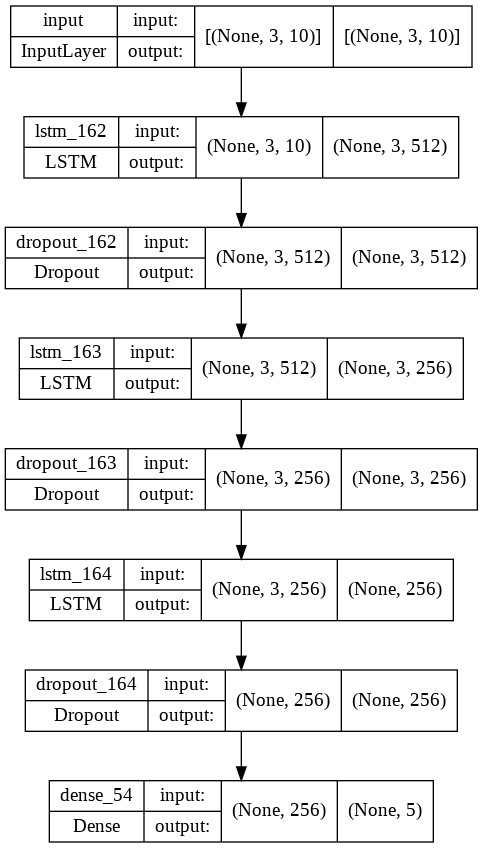

In [39]:
model = LSTM_base(lookback_width=IW, num_features = len(scaled_data.columns),label_width=LW, loss = LOSS)
model.plot()

In [ ]:
model.train(data_window=wg, MAX_EPOCHS = MAX_EPOCHS, bs=bs, verbose=verbose, lr=lr, patience = patience)

Epoch 1/50
1/1 [==============================] - 9s 9s/step - loss: 0.2132 - val_loss: 1.2992
Epoch 2/50
1/1 [==============================] - 1s 529ms/step - loss: 0.2173 - val_loss: 1.2933
Epoch 3/50
1/1 [==============================] - 0s 161ms/step - loss: 0.2149 - val_loss: 1.2875
Epoch 4/50
1/1 [==============================] - 0s 165ms/step - loss: 0.2137 - val_loss: 1.2828
Epoch 5/50
1/1 [==============================] - 0s 164ms/step - loss: 0.2112 - val_loss: 1.2776
Epoch 6/50
1/1 [==============================] - 0s 159ms/step - loss: 0.2074 - val_loss: 1.2698
Epoch 7/50
1/1 [==============================] - 0s 161ms/step - loss: 0.2058 - val_loss: 1.2565
Epoch 8/50
1/1 [==============================] - 0s 162ms/step - loss: 0.2040 - val_loss: 1.2364
Epoch 9/50
1/1 [==============================] - 0s 171ms/step - loss: 0.1980 - val_loss: 1.2081
Epoch 10/50
1/1 [==============================] - 0s 176ms/step - loss: 0.1940 - val_loss: 1.1706
Epoch 11/50
1/1 [=====

In [ ]:
y_pred, y_real = fetch_pred_real(rbscaler, model)
print(
'MAE', list(MAE(y_pred, y_real)[0]), ' Mean MAE', MAE(y_pred, y_real)[1],
'\nMSE', list(MSE(y_pred, y_real)[0]),' Mean MSE', MSE(y_pred, y_real)[1],
'\nRMSE', list(RMSE(y_pred, y_real)[0]), 'Mean RMSE', RMSE(y_pred, y_real)[1]
)

MAE [1.6256021, 2.0120442, 2.4226687, 3.0711157, 3.2895849]  Mean MAE 2.484203 
MSE [3.9650023, 5.0994496, 6.5102844, 9.775352, 11.056514]  Mean MSE 7.2813196 
RMSE [1.9912313, 2.258196, 2.5515258, 3.126556, 3.3251336] Mean RMSE 2.6983922


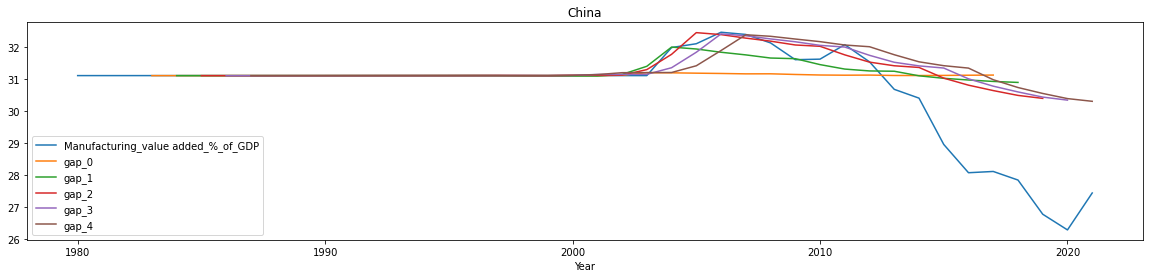

In [ ]:
y_pred, y_real = fetch_all_pred_real(rbscaler, model)
### predict 5 years at once (gap as prediction gap : 0, 1, 2, 3, 4)
pd.concat([data.iloc[:, -1], pat_pred(y_pred)], axis = 1).plot(figsize = (20, 4), title = 'China')

In [ ]:
forecast(rbscaler, model)

Manufacturing_value added_%_of_GDP
2022                           31.135271
2023                           30.804632
2024                           30.064445
2025                           29.995934
2026                           29.958288

#### pipeline function

In [ ]:
SHIFT = 5
LW = 5
IW = 3
MAX_EPOCHS = 50
bs = 32
verbose = False
lr = 0.001
patience = 50
LOSS = tf.keras.losses.MeanAbsoluteError()

In [ ]:
def pipeline(country = 'CHN', method = 'Median'):
  data = m_dfs[(country, method)].dropna(axis = 1)
  rbscaler = MRobustScaler() 
  scaled_data = rbscaler.transform(data, 0.1)
  train_df, val_df, test_df=train_test_split(scaled_data, IW = IW + SHIFT)
  wg = WindowGenerator(input_width=IW, label_width=LW, shift=SHIFT,
                      train_df = train_df, val_df = val_df, test_df = test_df, 
                      scaled_data = scaled_data,
                      label_columns=[scaled_data.columns[-1]])
  model = LSTM_base(lookback_width=IW, num_features = len(scaled_data.columns),label_width=LW, loss = LOSS)
  model.train(data_window=wg, MAX_EPOCHS = MAX_EPOCHS, bs=bs, verbose=verbose, lr=lr, patience = patience)
  y_pred, y_real = fetch_pred_real(rbscaler, model)
  print(
  'MAE', list(MAE(y_pred, y_real)[0]), ' Mean MAE', MAE(y_pred, y_real)[1],
  '\nMSE', list(MSE(y_pred, y_real)[0]),' Mean MSE', MSE(y_pred, y_real)[1],
  '\nRMSE', list(RMSE(y_pred, y_real)[0]), 'Mean RMSE', RMSE(y_pred, y_real)[1]
  )
  y_pred1, y_real1 = fetch_all_pred_real(rbscaler, model)
  ### predict 5 years at once (gap as prediction gap : 0, 1, 2, 3, 4)
  display(pd.concat([data.iloc[:, -1], pat_pred(y_pred1, data)], axis = 1).plot(figsize = (20, 4), title = dic_country[country] + ' (' +  method + ') :' \
                                                                         + '\nMean MAE: ' + str(MAE(y_pred, y_real)[1]) \
                                                                         + '\nMean MSE: ' + str(MSE(y_pred, y_real)[1]) \
                                                                         + '\nMean RMSE: ' + str(RMSE(y_pred, y_real)[1]) \
                                                                         ))
  display(forecast(rbscaler, scaled_data, model, name = country + '_' + method))
  return  MAE(y_pred, y_real)[1], MSE(y_pred, y_real)[1], RMSE(y_pred, y_real)[1]

Total Modelling Time:  18.200592756271362
MAE [1.64814, 2.0171678, 2.3960912, 2.9806826, 3.2654457]  Mean MAE 2.4615054 
MSE [4.074885, 5.145677, 6.3639503, 9.145062, 10.892636]  Mean MSE 7.124442 
RMSE [2.0186343, 2.2684085, 2.5226872, 3.0240805, 3.3003993] Mean RMSE 2.6691651


CHN_Median
2022   31.237280
2023   30.900455
2024   29.932192
2025   29.566559
2026   29.702703

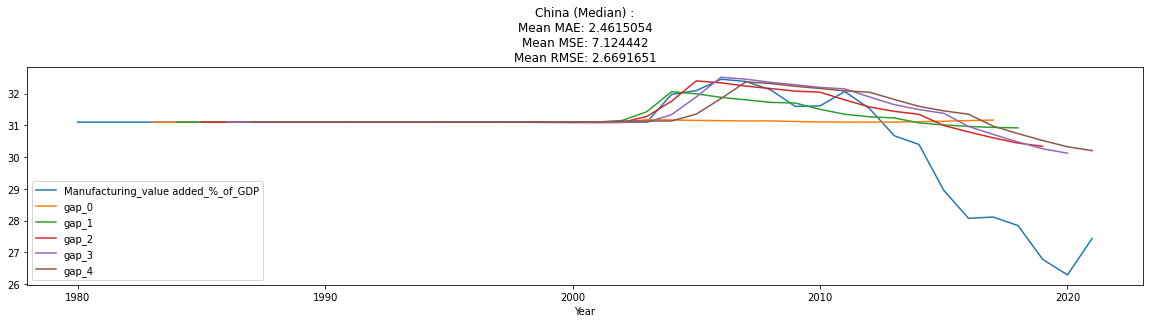

In [ ]:
pipeline()

#### Run all pipelines

##### Manufacturing

In [ ]:
c, m, a, s, r = [], [], [], [], []

###### Mean

China Mean :
Total Modelling Time:  24.99770975112915
MAE [1.2292877, 1.1447138, 1.4760069, 2.0973556, 2.3355446]  Mean MAE 1.6565816 
MSE [1.9790521, 1.9105172, 2.4873428, 4.468968, 5.762035]  Mean MSE 3.321583 
RMSE [1.4067879, 1.3822145, 1.5771312, 2.1139934, 2.400424] Mean RMSE 1.8225211


CHN_Mean
2022  30.159445
2023  29.580532
2024  28.079437
2025  27.713652
2026  27.776398



United Kingdom Mean :
Total Modelling Time:  19.70872712135315
MAE [2.9029121, 3.1590765, 3.2130163, 3.2427294, 3.1324348]  Mean MAE 3.1300342 
MSE [9.885037, 12.044197, 13.399325, 13.79539, 12.7382555]  Mean MSE 12.37244 
RMSE [3.144048, 3.470475, 3.6605089, 3.7142146, 3.5690694] Mean RMSE 3.517448


GBR_Mean
2022  12.308044
2023  12.283053
2024  12.336748
2025  12.364098
2026  12.549086



Hong Kong SAR, China Mean :
Total Modelling Time:  27.237707376480103
MAE [0.3842306, 0.48650956, 0.52824956, 0.5466704, 0.58834964]  Mean MAE 0.50680196 
MSE [0.20508765, 0.29492912, 0.36151972, 0.40926775, 0.48471084]  Mean MSE 0.351103 
RMSE [0.45286605, 0.5430738, 0.60126513, 0.6397404, 0.69621176] Mean RMSE 0.5925394


HKG_Mean
2022  2.012394
2023  2.568648
2024  2.888712
2025  2.879622
2026  3.309780



India Mean :
Total Modelling Time:  21.870324850082397
MAE [0.39303112, 0.31157336, 0.7575572, 1.4408637, 1.7642716]  Mean MAE 0.93345946 
MSE [0.21933842, 0.15225738, 1.0266169, 2.57644, 3.501931]  Mean MSE 1.4953167 
RMSE [0.4683358, 0.39020172, 1.013221, 1.6051294, 1.8713447] Mean RMSE 1.2228315


IND_Mean
2022  15.779952
2023  15.388849
2024  15.229966
2025  14.585152
2026  14.728307



Iran, Islamic Rep. Mean :
Total Modelling Time:  18.32272744178772
MAE [6.353124, 1.1564897, 4.516247, 6.3600388, 7.5590305]  Mean MAE 5.188987 
MSE [49.36185, 1.6634717, 23.077143, 50.189823, 66.20053]  Mean MSE 38.098564 
RMSE [7.025799, 1.2897564, 4.8038673, 7.0844774, 8.136371] Mean RMSE 6.1724033


IRN_Mean
2022  16.387436
2023  17.641729
2024  17.814993
2025  17.031023
2026  17.407425



Italy Mean :
Total Modelling Time:  18.613223791122437
MAE [4.117533, 4.525579, 4.886936, 5.324409, 4.9068284]  Mean MAE 4.752258 
MSE [17.199713, 20.981028, 24.579103, 29.103842, 24.84387]  Mean MSE 23.34151 
RMSE [4.1472535, 4.5805054, 4.9577317, 5.394798, 4.9843626] Mean RMSE 4.8313055


ITA_Mean
2022  19.186432
2023  19.487640
2024  19.373102
2025  19.227285
2026  18.790718



Russian Federation Mean :
Total Modelling Time:  20.293639183044434
MAE [1.6609432, 1.3083576, 0.8594195, 0.85549307, 0.95363075]  Mean MAE 1.127569 
MSE [2.9887993, 2.1179729, 1.0053309, 0.84592867, 1.8249437]  Mean MSE 1.756595 
RMSE [1.7288145, 1.4553257, 1.002662, 0.91974384, 1.3509047] Mean RMSE 1.325366


RUS_Mean
2022  13.480150
2023  13.195106
2024  12.614536
2025  11.852634
2026  11.286889



United States Mean :
Total Modelling Time:  21.785274744033813
MAE [0.81172293, 0.6868612, 0.46868134, 0.5069103, 0.8644869]  Mean MAE 0.66773254 
MSE [0.7973483, 0.6953878, 0.3728387, 0.40943924, 1.1718475]  Mean MSE 0.6893723 
RMSE [0.8929436, 0.83389914, 0.6106052, 0.6398744, 1.082519] Mean RMSE 0.8302845


USA_Mean
2022  15.775126
2023  16.316341
2024  15.933147
2025  15.675301
2026  15.003123



Vietnam Mean :
Total Modelling Time:  18.378211736679077
MAE [0.27471197, 0.26674634, 0.2771277, 0.28715888, 0.2706542]  Mean MAE 0.27527982 
MSE [0.09211602, 0.08564863, 0.09392375, 0.10176686, 0.10019139]  Mean MSE 0.09472934 
RMSE [0.30350623, 0.29265788, 0.30646983, 0.31900918, 0.31653023] Mean RMSE 0.3077813


VNM_Mean
2022  1.240605
2023  1.239631
2024  1.239846
2025  1.239599
2026  1.240923



South Africa Mean :
Total Modelling Time:  18.121347427368164
MAE [4.2903714, 4.2519445, 3.5503, 3.3277714, 3.8692806]  Mean MAE 3.8579335 
MSE [18.496284, 18.166811, 12.69524, 11.311221, 15.209045]  Mean MSE 15.175719 
RMSE [4.3007307, 4.262254, 3.563038, 3.363216, 3.8998775] Mean RMSE 3.8956025


ZAF_Mean
2022  17.639862
2023  17.460897
2024  16.737577
2025  16.390879
2026  16.601168

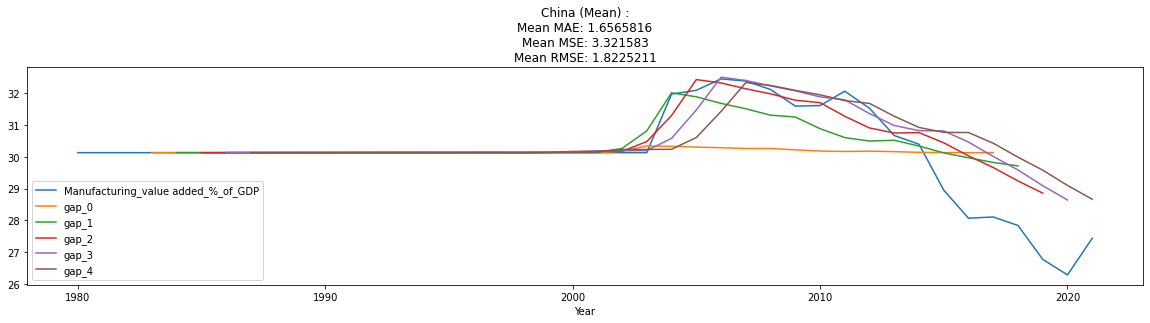

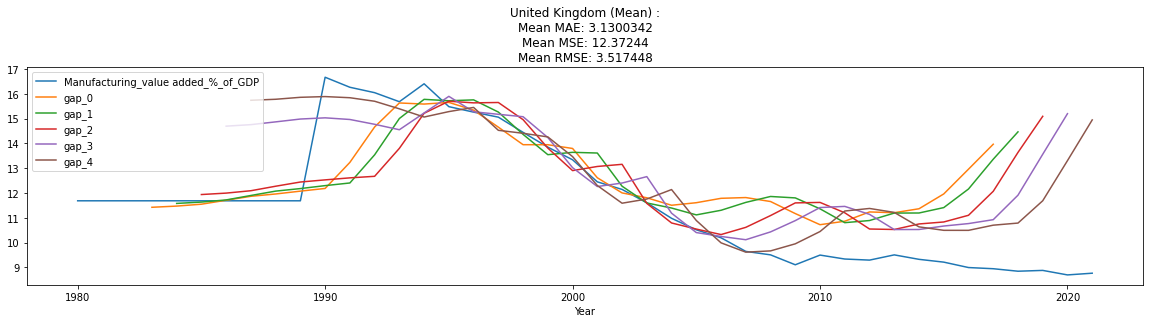

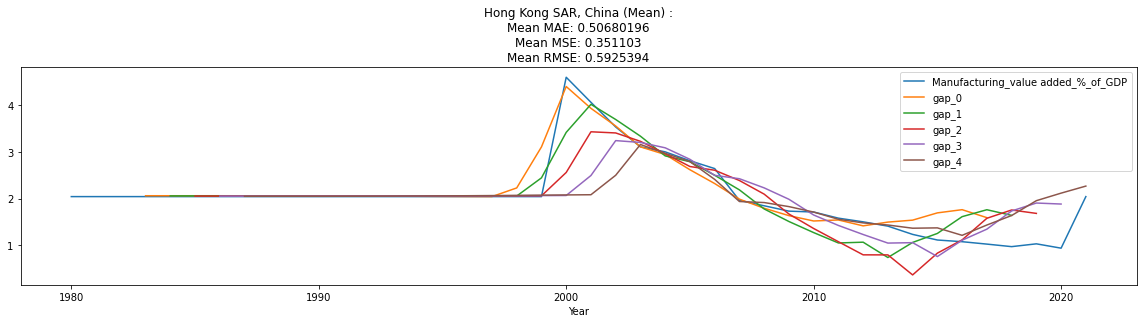

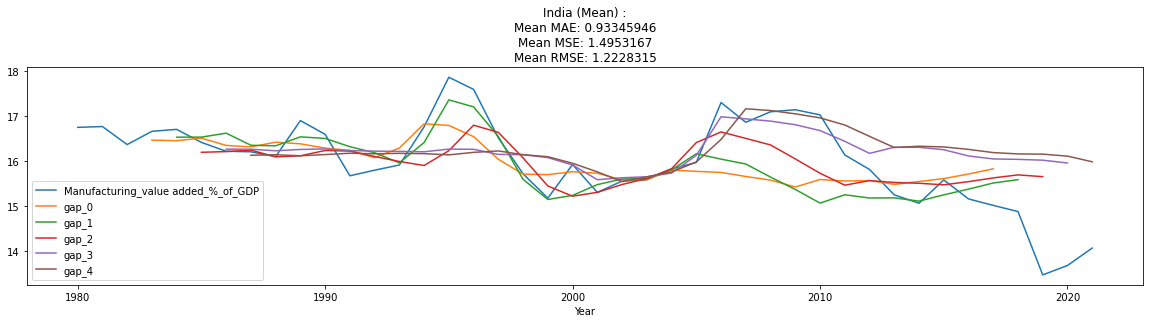

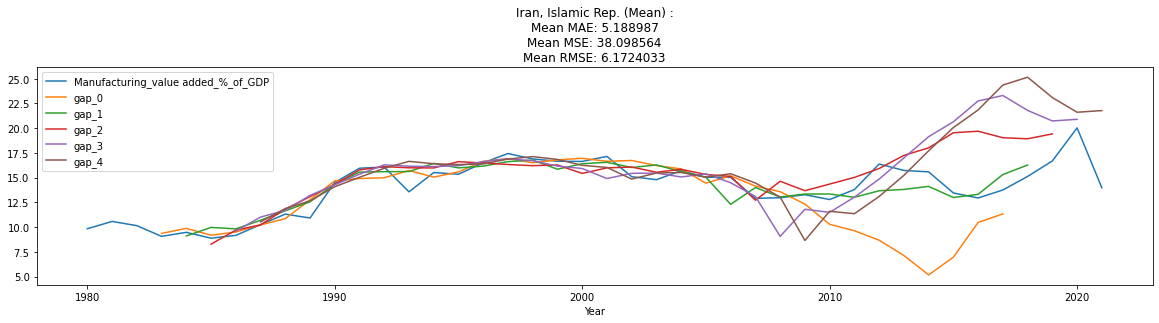

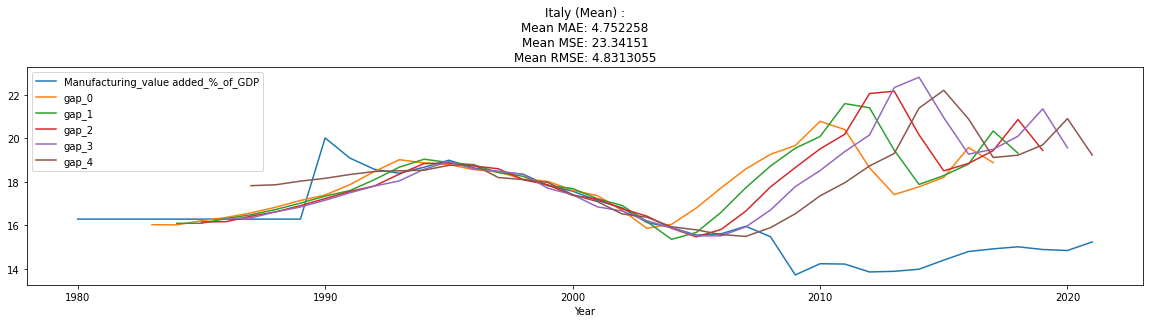

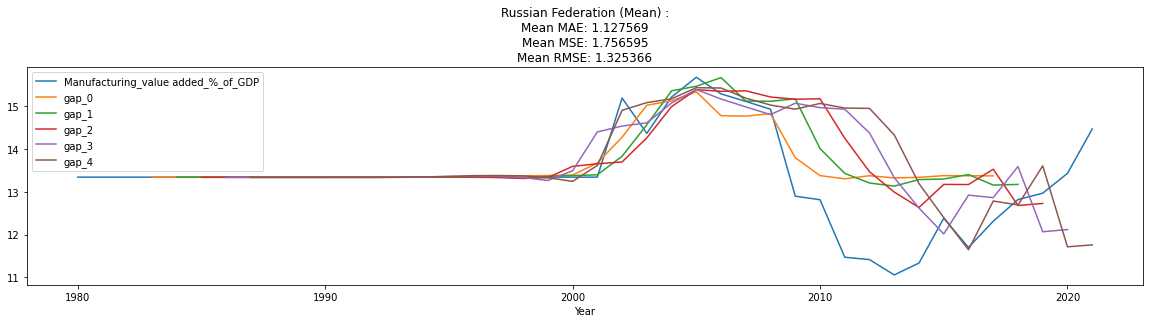

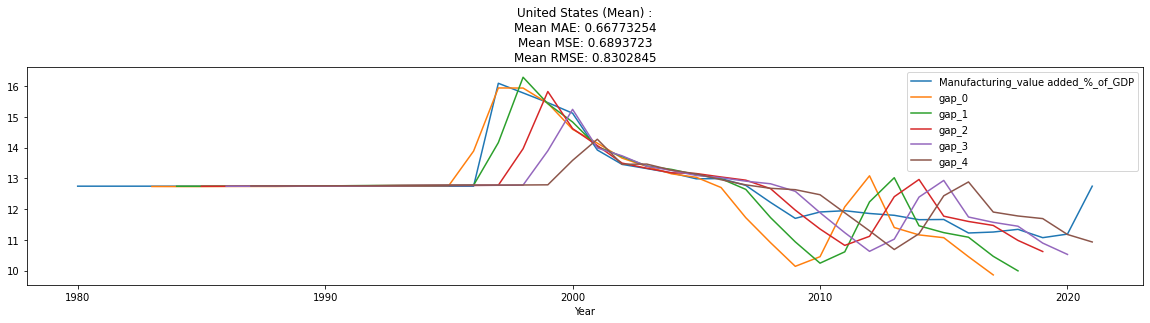

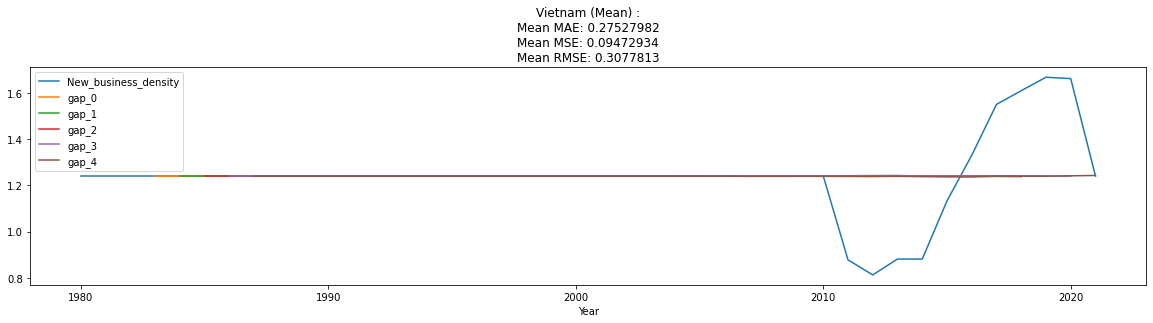

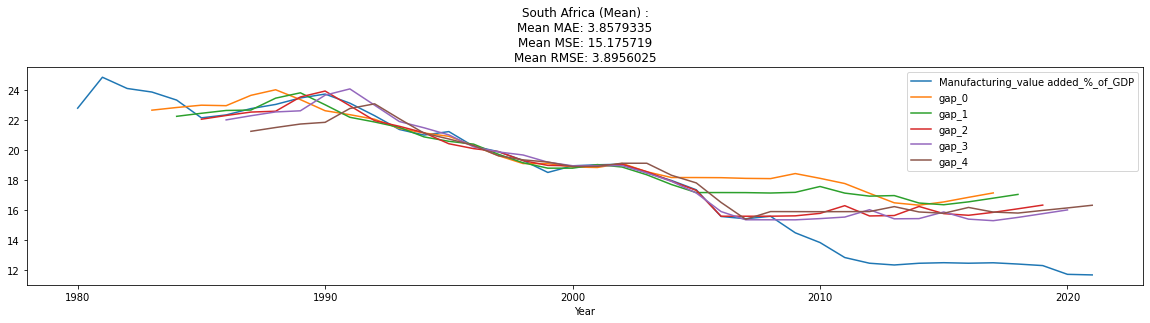

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_m, 0):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  a1, s1, r1 = pipeline(country, method)
  c.append(country)
  m.append(method)
  a.append(a1)
  s.append(s1)
  r.append(r1)
  print('\n')

###### Median

China Median :
Total Modelling Time:  19.375046491622925
MAE [1.6062008, 2.0246723, 2.4811935, 3.1064014, 3.335944]  Mean MAE 2.5108824 
MSE [3.8744895, 5.175438, 6.850818, 9.972779, 11.366855]  Mean MSE 7.448076 
RMSE [1.9683723, 2.2749588, 2.6174068, 3.1579707, 3.3714767] Mean RMSE 2.7291162


CHN_Median
2022   31.070587
2023   30.875320
2024   30.156830
2025   29.950979
2026   29.880146



United Kingdom Median :
Total Modelling Time:  19.039480686187744
MAE [2.6091912, 3.0937805, 3.0774403, 3.1056569, 2.8812268]  Mean MAE 2.953459 
MSE [8.915908, 14.071055, 14.26434, 15.724103, 14.542371]  Mean MSE 13.503555 
RMSE [2.9859517, 3.7511406, 3.7768161, 3.9653628, 3.813446] Mean RMSE 3.6747184


GBR_Median
2022   12.139064
2023   12.995960
2024   12.600943
2025   13.172611
2026   13.614403



Hong Kong SAR, China Median :
Total Modelling Time:  18.776649475097656
MAE [0.42960453, 0.40971088, 0.38479733, 0.45167097, 0.4996748]  Mean MAE 0.4350917 
MSE [0.21785478, 0.1858793, 0.16108106, 0.21310191, 0.2720975]  Mean MSE 0.2100029 
RMSE [0.46674916, 0.43113723, 0.40134904, 0.46162963, 0.52162963] Mean RMSE 0.45826074


HKG_Median
2022    1.684455
2023    1.562403
2024    1.438574
2025    1.441832
2026    1.515158



India Median :
Total Modelling Time:  18.711284160614014
MAE [0.37081194, 0.3363088, 0.7973738, 1.4361577, 1.7864599]  Mean MAE 0.9454225 
MSE [0.18893929, 0.17207418, 1.0253911, 2.3909438, 3.5193424]  Mean MSE 1.4593381 
RMSE [0.43467146, 0.41481826, 1.0126159, 1.5462677, 1.8759911] Mean RMSE 1.2080307


IND_Median
2022   15.733815
2023   15.386074
2024   15.089969
2025   14.606827
2026   14.883936



Iran, Islamic Rep. Median :
Total Modelling Time:  20.27710771560669
MAE [12.20193, 5.6212516, 0.80255765, 3.2850723, 5.2301216]  Mean MAE 5.4281864 
MSE [167.59917, 35.950912, 1.3532449, 15.145772, 34.746136]  Mean MSE 50.959045 
RMSE [12.94601, 5.995908, 1.1632905, 3.891757, 5.894585] Mean RMSE 7.1385603


IRN_Median
2022   15.927202
2023   16.867334
2024   17.298817
2025   16.645475
2026   17.166780



Italy Median :
Total Modelling Time:  22.036134481430054
MAE [3.6760108, 3.8808947, 4.4384046, 4.6929913, 4.055197]  Mean MAE 4.1486993 
MSE [13.878078, 15.919189, 21.230553, 23.55278, 17.828032]  Mean MSE 18.481726 
RMSE [3.7253294, 3.9898858, 4.607662, 4.853121, 4.2223253] Mean RMSE 4.299038


ITA_Median
2022   19.291035
2023   19.708435
2024   20.083324
2025   19.963305
2026   19.353943



Russian Federation Median :
Total Modelling Time:  18.2005455493927
MAE [1.0835179, 0.83533, 0.55629617, 0.7896808, 1.1940104]  Mean MAE 0.89176714 
MSE [1.4156343, 1.047518, 0.43427762, 0.8013838, 2.3892877]  Mean MSE 1.2176204 
RMSE [1.1898043, 1.0234833, 0.6589974, 0.89520043, 1.5457321] Mean RMSE 1.1034584


RUS_Median
2022   12.804973
2023   12.797265
2024   12.580702
2025   11.839605
2026   11.395321



United States Median :
Total Modelling Time:  20.31762146949768
MAE [1.2223334, 0.946336, 0.64718455, 0.530423, 0.8109619]  Mean MAE 0.83144784 
MSE [1.7393547, 1.1426884, 0.6307158, 0.4796292, 1.3481635]  Mean MSE 1.0681103 
RMSE [1.318846, 1.068966, 0.79417616, 0.6925527, 1.1611044] Mean RMSE 1.0334942


USA_Median
2022   15.513824
2023   15.657418
2024   14.920520
2025   14.162857
2026   14.003020



Vietnam Median :
Total Modelling Time:  20.41599678993225
MAE [0.2722713, 0.26504004, 0.2800028, 0.29232273, 0.2777263]  Mean MAE 0.27747262 
MSE [0.09011266, 0.084398754, 0.096119076, 0.10580743, 0.10530344]  Mean MSE 0.09634827 
RMSE [0.3001877, 0.29051465, 0.31003076, 0.32528055, 0.3245049] Mean RMSE 0.3104002


VNM_Median
2022    1.231562
2023    1.230119
2024    1.232931
2025    1.231920
2026    1.229515



South Africa Median :
Total Modelling Time:  18.87798833847046
MAE [5.2821293, 5.079237, 4.102985, 4.1479163, 3.9261558]  Mean MAE 4.507684 
MSE [27.932825, 25.8402, 16.905928, 17.398684, 15.666545]  Mean MSE 20.748837 
RMSE [5.2851515, 5.083326, 4.111682, 4.171173, 3.9580986] Mean RMSE 4.555089


ZAF_Median
2022   18.092354
2023   17.855694
2024   16.906279
2025   16.672140
2026   16.308954

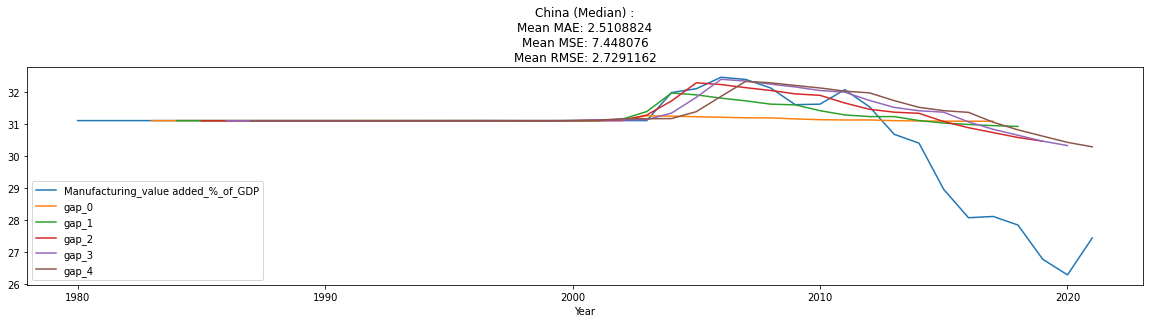

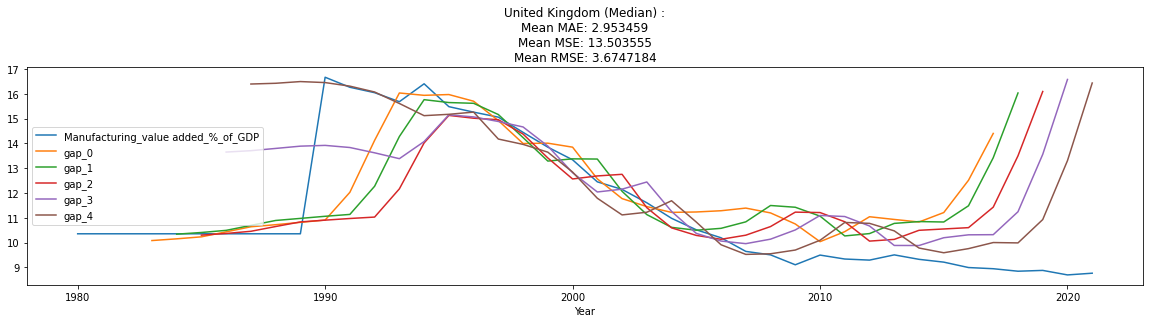

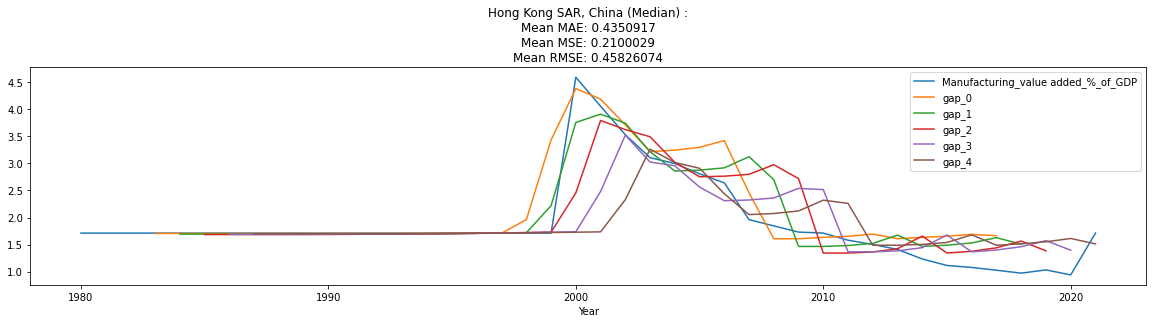

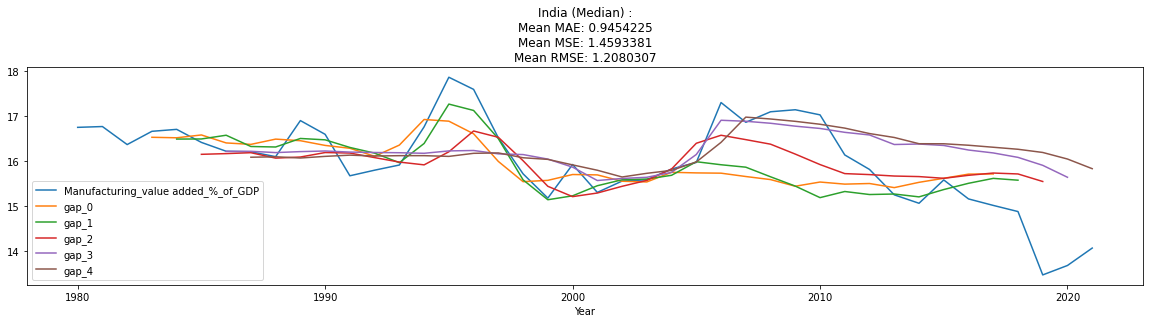

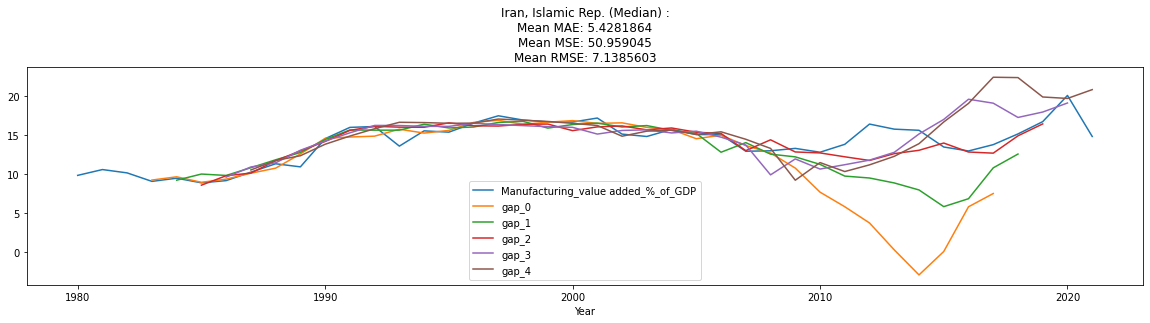

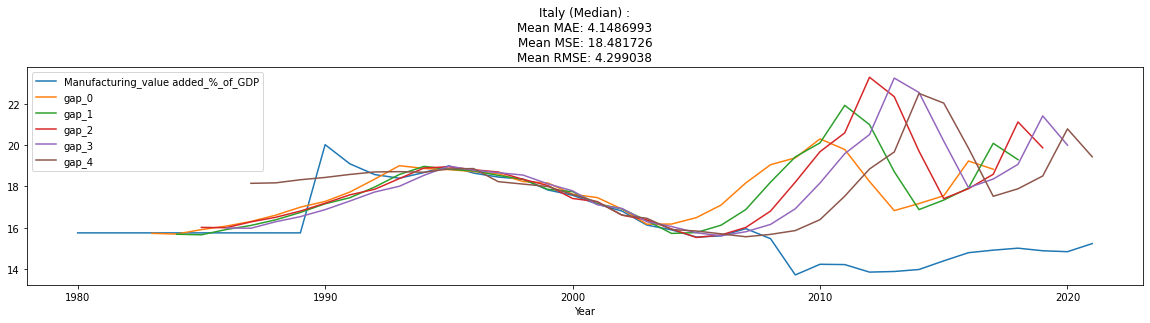

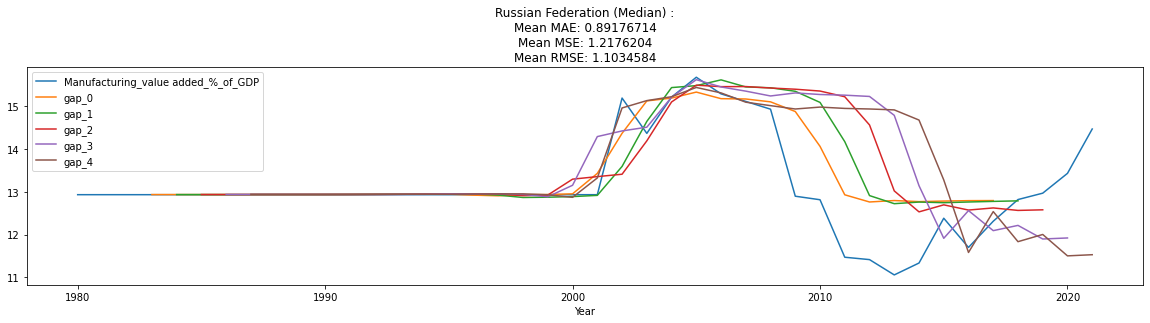

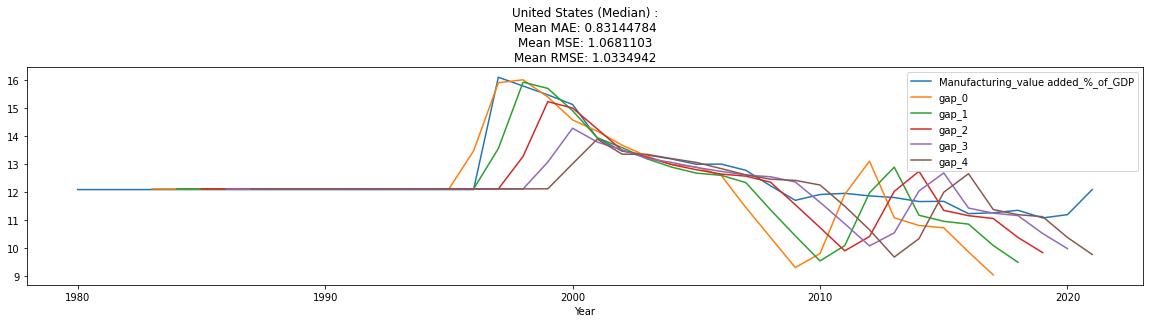

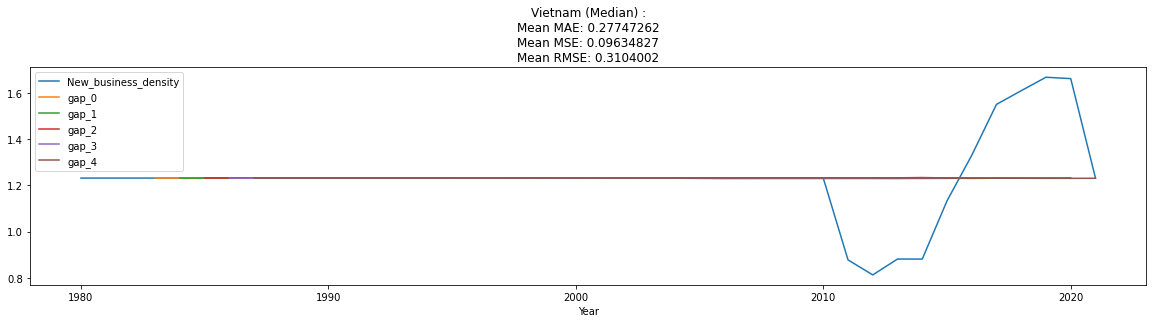

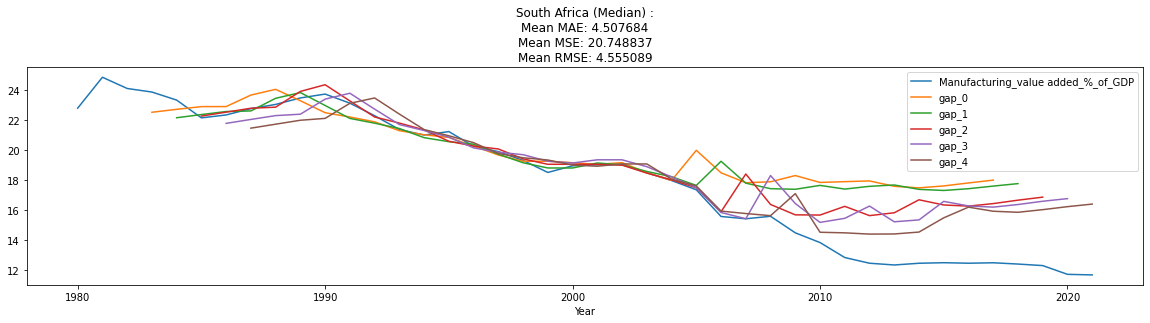

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_m, 1):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  a1, s1, r1 = pipeline(country, method)
  c.append(country)
  m.append(method)
  a.append(a1)
  s.append(s1)
  r.append(r1)
  print('\n')

###### LOCF

China LOCF :
Total Modelling Time:  21.231720209121704
MAE [2656425500000.0, 3030346000000.0, 3212428700000.0, 3021553800000.0, 2325011000000.0]  Mean MAE 2849152700000.0 
MSE [7.392505e+24, 9.633549e+24, 1.0825844e+25, 9.5243935e+24, 5.569356e+24]  Mean MSE 8.5891286e+24 
RMSE [2718916100000.0, 3103796000000.0, 3290265000000.0, 3086161500000.0, 2359948500000.0] Mean RMSE 2930721400000.0


CHN_LOCF
2022  3.555743e+12
2023  3.692350e+12
2024  3.965911e+12
2025  4.742689e+12
2026  6.183075e+12



United Kingdom LOCF :
Total Modelling Time:  19.27012324333191
MAE [176197810000.0, 178684740000.0, 250899810000.0, 600327400000.0, 1185195400000.0]  Mean MAE 478260950000.0 
MSE [3.5206838e+22, 3.8386787e+22, 7.5105653e+22, 4.0994906e+23, 1.4443522e+24]  Mean MSE 4.0060012e+23 
RMSE [187634860000.0, 195925460000.0, 274054100000.0, 640272600000.0, 1201812000000.0] Mean RMSE 632929800000.0


GBR_LOCF
2022  2.350915e+12
2023  2.478666e+12
2024  2.621417e+12
2025  3.019601e+12
2026  3.666258e+12



Hong Kong SAR, China LOCF :
Total Modelling Time:  20.275007963180542
MAE [84414640000.0, 103637740000.0, 120590760000.0, 127977595000.0, 134976110000.0]  Mean MAE 114319385000.0 
MSE [7.448999e+21, 1.1193535e+22, 1.505793e+22, 1.6700248e+22, 1.8427853e+22]  Mean MSE 1.3765713e+22 
RMSE [86307590000.0, 105799500000.0, 122710750000.0, 129229440000.0, 135749230000.0] Mean RMSE 117327370000.0


HKG_LOCF
2022  1.565063e+11
2023  1.484440e+11
2024  1.413920e+11
2025  1.422418e+11
2026  1.423869e+11



India LOCF :
Total Modelling Time:  18.65541434288025
MAE [2.2586968, 2.0137808, 0.6213878, 0.87844294, 5.410979]  Mean MAE 2.2366574 
MSE [5.2978826, 4.2222304, 0.54732746, 0.8454028, 33.30685]  Mean MSE 8.843939 
RMSE [2.301713, 2.0548067, 0.73981583, 0.91945785, 5.771209] Mean RMSE 2.973876


IND_LOCF
2022  11.459272
2023  11.843414
2024  14.831839
2025  14.353088
2026  23.784740



Iran, Islamic Rep. LOCF :
Total Modelling Time:  18.71877884864807
MAE [20.02646, 23.944231, 24.98155, 24.754404, 21.955275]  Mean MAE 23.132383 
MSE [415.79492, 585.63153, 639.0789, 631.2473, 498.52274]  Mean MSE 554.05505 
RMSE [20.39105, 24.199825, 25.28001, 25.124636, 22.327623] Mean RMSE 23.538374


IRN_LOCF
2022  15.101542
2023  15.868248
2024  15.769883
2025  15.510471
2026  15.616853



Italy LOCF :
Total Modelling Time:  21.421226501464844
MAE [1674729600000.0, 1544793500000.0, 1374873700000.0, 1230091500000.0, 1221228900000.0]  Mean MAE 1409143500000.0 
MSE [2.907703e+24, 2.435661e+24, 1.9153893e+24, 1.5190731e+24, 1.4953989e+24]  Mean MSE 2.0546449e+24 
RMSE [1705198700000.0, 1560660400000.0, 1383975900000.0, 1232506800000.0, 1222865000000.0] Mean RMSE 1433403300000.0


ITA_LOCF
2022  5.934940e+11
2023  5.427176e+11
2024  5.527602e+11
2025  5.684344e+11
2026  5.306029e+11



Russian Federation LOCF :
Cannot handle RUS, LOCF
United States LOCF :
Total Modelling Time:  19.804062128067017
MAE [1908792200000.0, 1568082600000.0, 1296287300000.0, 451718840000.0, 558418600000.0]  Mean MAE 1156660000000.0 
MSE [3.9137797e+24, 2.8293757e+24, 2.1331174e+24, 2.5708815e+23, 4.0607232e+23]  Mean MSE 1.9078866e+24 
RMSE [1978327500000.0, 1682074800000.0, 1460519600000.0, 507038600000.0, 637238050000.0] Mean RMSE 1381262700000.0


USA_LOCF
2022  1.454676e+13
2023  1.573278e+13
2024  1.676900e+13
2025  1.912071e+13
2026  2.029470e+13



Vietnam LOCF :
Cannot handle VNM, LOCF
South Africa LOCF :
Total Modelling Time:  19.21148443222046
MAE [0.82488745, 0.40804815, 1.2699877, 0.9203348, 0.4290649]  Mean MAE 0.7704646 
MSE [0.8794523, 0.3127391, 1.717857, 1.0298775, 0.33314422]  Mean MSE 0.85461414 
RMSE [0.93779117, 0.5592308, 1.3106705, 1.0148288, 0.57718647] Mean RMSE 0.92445344


ZAF_LOCF
2022  13.543890
2023  14.074644
2024  14.571430
2025  14.002239
2026  13.423214

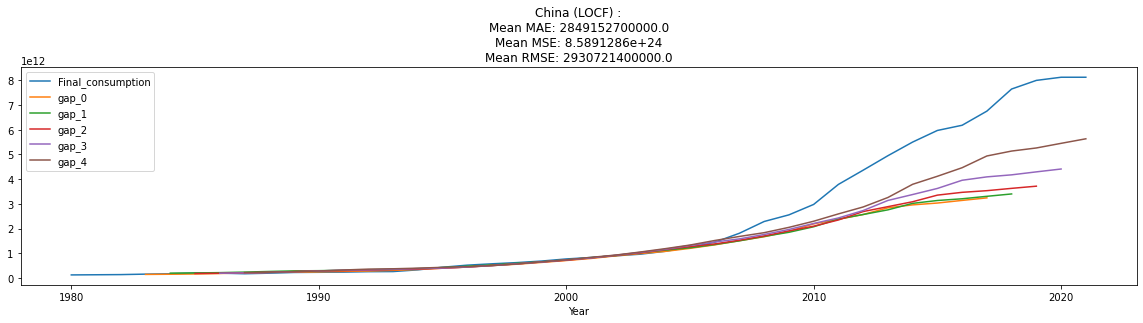

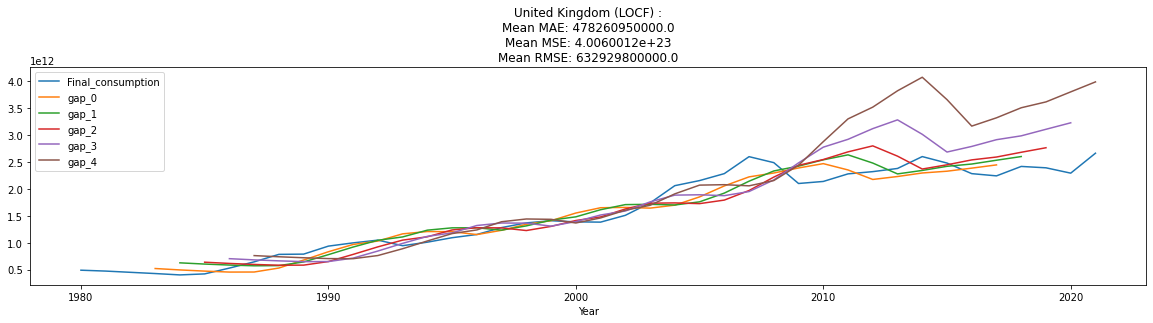

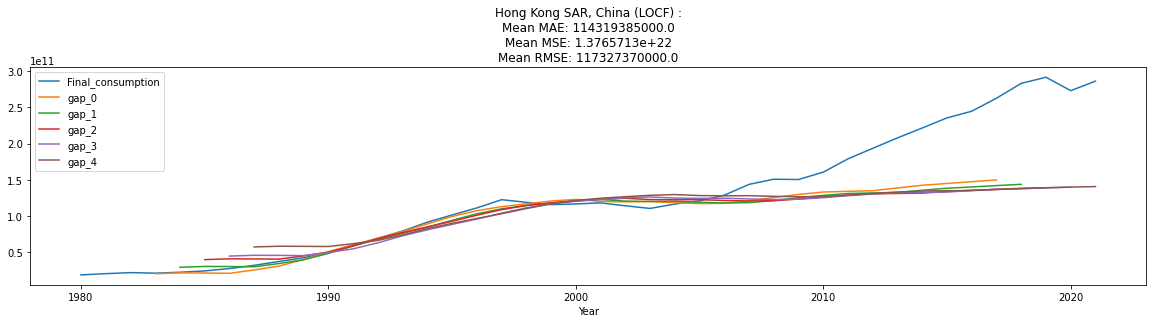

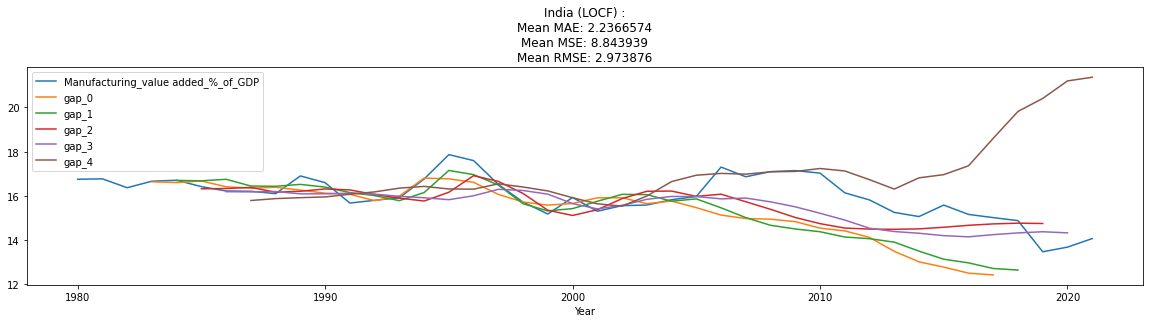

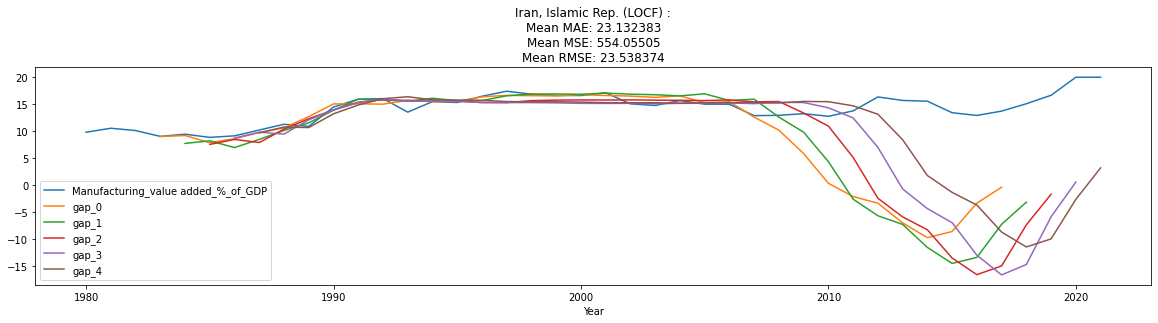

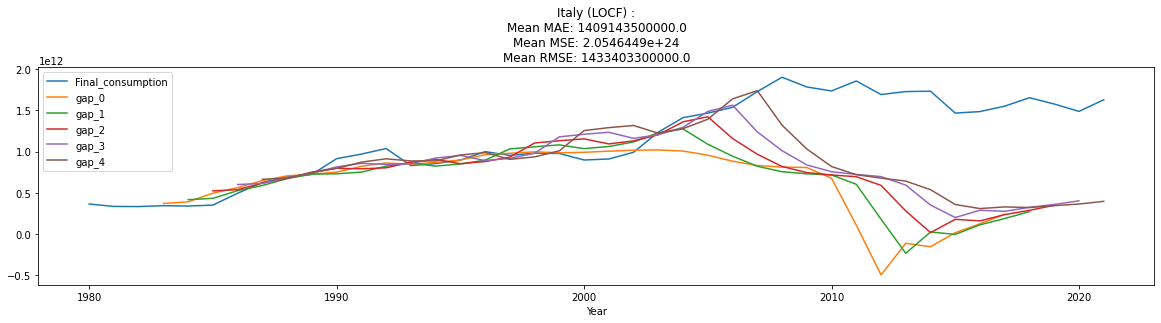

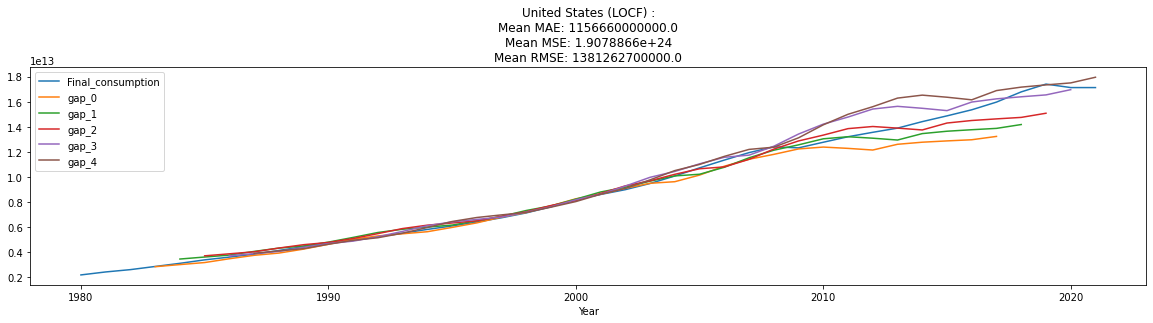

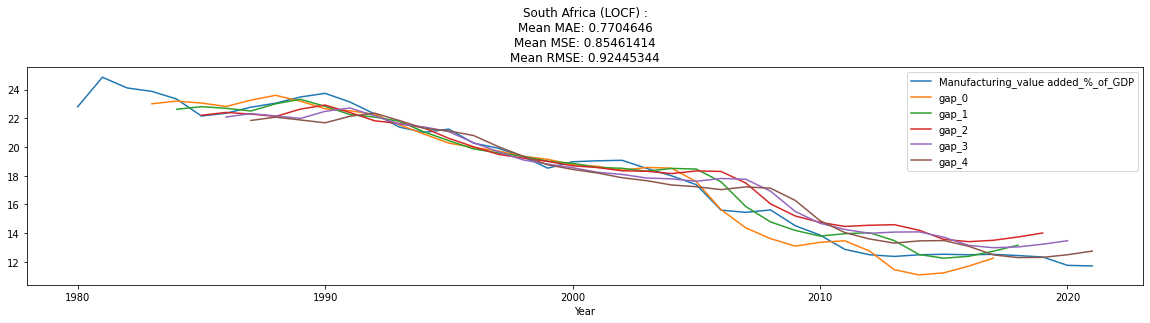

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_m, 2):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### NOCB

China NOCB :
Total Modelling Time:  19.105252265930176
MAE [2.355418, 2.973197, 3.629936, 4.30859, 4.630159]  Mean MAE 3.5794604 
MSE [7.297567, 10.133645, 14.418892, 19.352783, 21.914398]  Mean MSE 14.623458 
RMSE [2.701401, 3.1833386, 3.7972217, 4.39918, 4.6812816] Mean RMSE 3.824063


CHN_NOCB
2022  31.980539
2023  31.983643
2024  31.993015
2025  31.973837
2026  32.083958



United Kingdom NOCB :
Total Modelling Time:  19.65054154396057
MAE [5.8147445, 6.605598, 7.7194767, 8.108631, 9.308502]  Mean MAE 7.51139 
MSE [34.92207, 44.619526, 60.696148, 66.68905, 87.99996]  Mean MSE 58.98535 
RMSE [5.9094896, 6.679785, 7.7907734, 8.166336, 9.38083] Mean RMSE 7.680192


GBR_NOCB
2022  2.918088
2023  2.059281
2024  0.840401
2025  0.378007
2026 -0.943700



Hong Kong SAR, China NOCB :
Total Modelling Time:  19.9878249168396
MAE [79579850000.0, 102534220000.0, 118846350000.0, 131421086000.0, 138179820000.0]  Mean MAE 114112260000.0 
MSE [6.610197e+21, 1.0950792e+22, 1.4610365e+22, 1.7622994e+22, 1.9323933e+22]  Mean MSE 1.3823656e+22 
RMSE [81303120000.0, 104646030000.0, 120873345000.0, 132751620000.0, 139010560000.0] Mean RMSE 117574040000.0


HKG_NOCB
2022  1.656970e+11
2023  1.507774e+11
2024  1.452083e+11
2025  1.354992e+11
2026  1.361661e+11



India NOCB :
Total Modelling Time:  18.30592441558838
MAE [0.75411683, 0.8667598, 0.73934764, 0.9415488, 1.3754735]  Mean MAE 0.93544924 
MSE [0.61883956, 0.79341, 0.596083, 1.0787289, 2.9738169]  Mean MSE 1.2121756 
RMSE [0.7866636, 0.8907356, 0.7720641, 1.0386188, 1.7244759] Mean RMSE 1.1009885


IND_NOCB
2022  13.888657
2023  13.916199
2024  14.330123
2025  13.894545
2026  17.117123



Iran, Islamic Rep. NOCB :
Cannot handle IRN, NOCB
Italy NOCB :
Total Modelling Time:  19.57612419128418
MAE [2.2464163, 1.9165368, 1.6741567, 1.5789415, 1.4014559]  Mean MAE 1.7635015 
MSE [5.7476945, 4.382944, 3.282481, 2.7107363, 2.1734428]  Mean MSE 3.6594596 
RMSE [2.397435, 2.0935483, 1.8117619, 1.6464313, 1.4742601] Mean RMSE 1.9129714


ITA_NOCB
2022  16.753101
2023  16.581516
2024  16.485489
2025  16.513323
2026  16.471455



Russian Federation NOCB :
Total Modelling Time:  20.120049953460693
MAE [3.578921, 3.3516932, 3.041516, 2.28372, 1.9736608]  Mean MAE 2.8459024 
MSE [13.049076, 11.6094675, 9.577729, 5.53693, 4.684879]  Mean MSE 8.891617 
RMSE [3.6123505, 3.4072669, 3.0947907, 2.353068, 2.164458] Mean RMSE 2.9818814


RUS_NOCB
2022  15.237298
2023  15.243858
2024  15.246337
2025  15.020984
2026  15.040370



United States NOCB :
Total Modelling Time:  19.36018443107605
MAE [2657.1582, 2593.6062, 842.23566, 2442.4148, 3022.293]  Mean MAE 2311.5415 
MSE [7414532.0, 7596098.5, 856490.94, 7655768.5, 11181311.0]  Mean MSE 6940840.0 
RMSE [2722.9639, 2756.102, 925.46796, 2766.906, 3343.8467] Mean RMSE 2634.5474


USA_NOCB
2022  62470.445312
2023  64794.062500
2024  73180.812500
2025  78142.539062
2026  81866.632812



Vietnam NOCB :
Total Modelling Time:  19.14944887161255
MAE [700.5257, 1320.5099, 1627.2076, 1842.401, 1878.4741]  Mean MAE 1473.8236 
MSE [495583.66, 1762666.6, 2682763.0, 3435446.0, 3552920.0]  Mean MSE 2385875.8 
RMSE [703.97705, 1327.6545, 1637.9142, 1853.4956, 1884.9191] Mean RMSE 1544.628


VNM_NOCB
2022  2749.923096
2023  2016.580322
2024  1817.119019
2025  1725.460938
2026  1954.305298



South Africa NOCB :
Total Modelling Time:  21.11307716369629
MAE [0.38744655, 0.40649557, 0.31176296, 0.355796, 0.39132833]  Mean MAE 0.3705659 
MSE [0.25162166, 0.23404066, 0.16640261, 0.19224155, 0.27403706]  Mean MSE 0.22366871 
RMSE [0.50161904, 0.4837775, 0.40792477, 0.43845358, 0.5234855] Mean RMSE 0.47293627


ZAF_NOCB
2022  12.474241
2023  12.479013
2024  12.660604
2025  12.475977
2026  12.490282

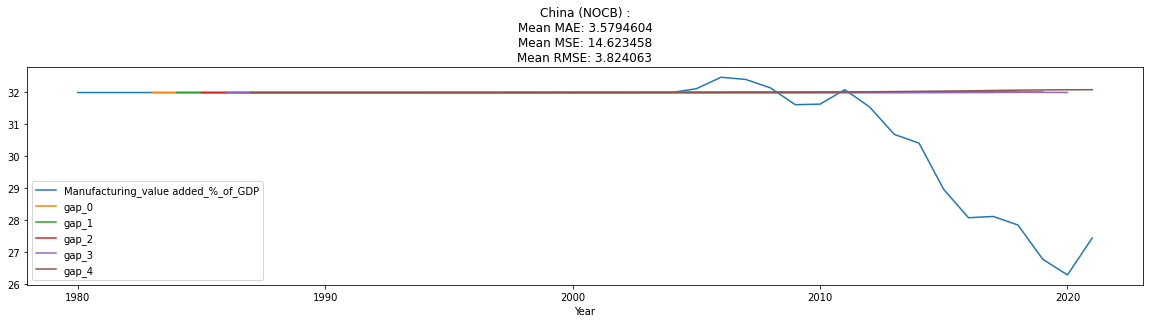

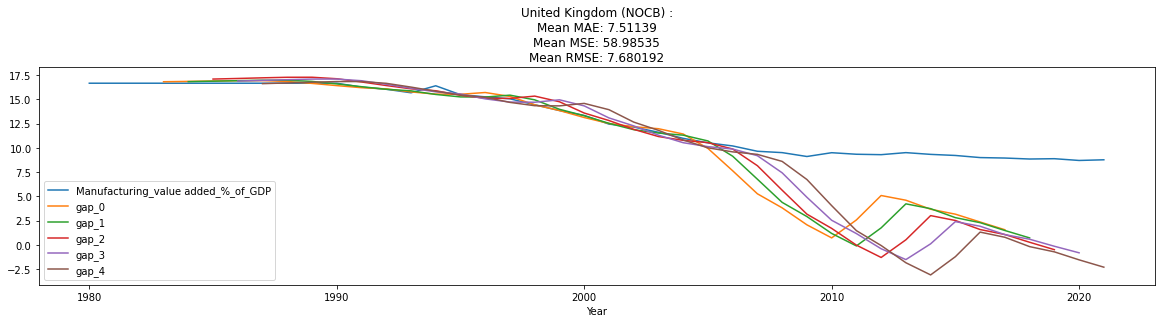

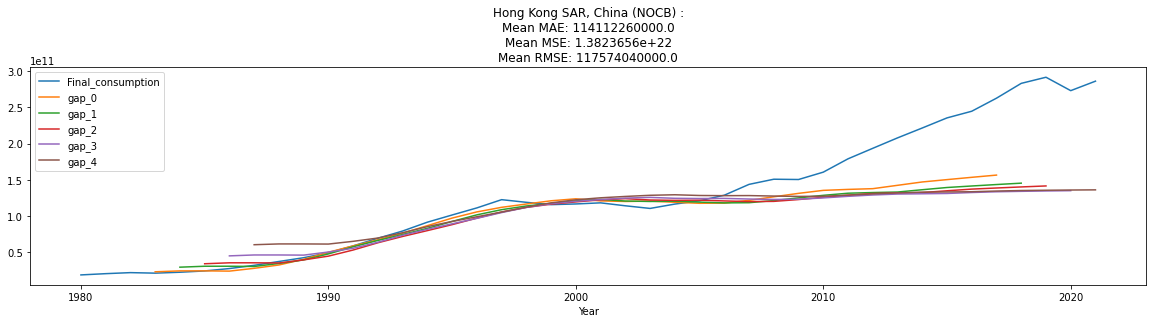

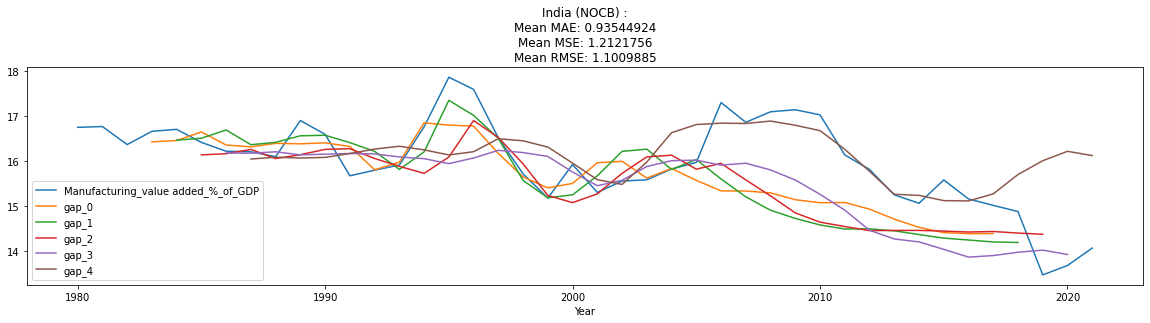

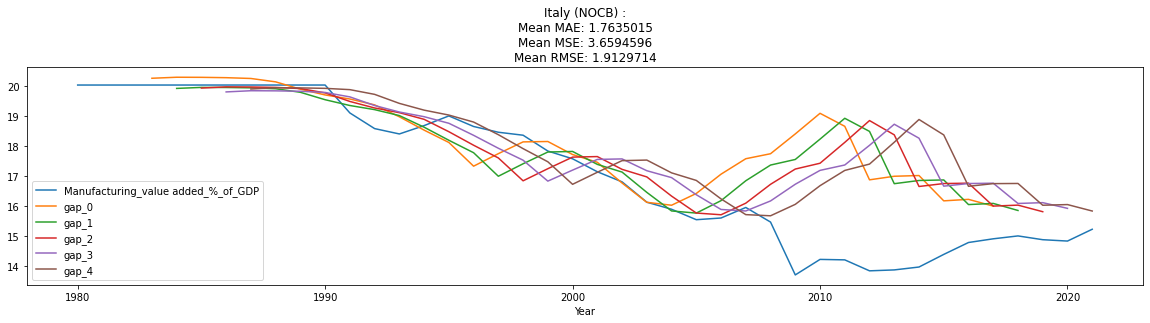

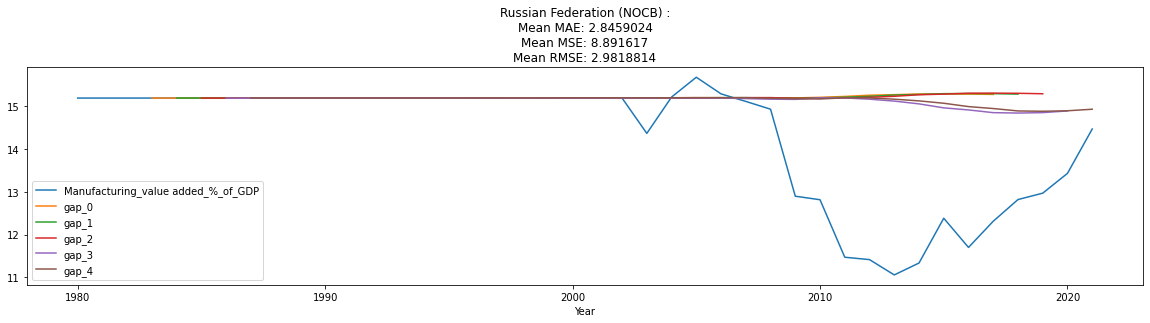

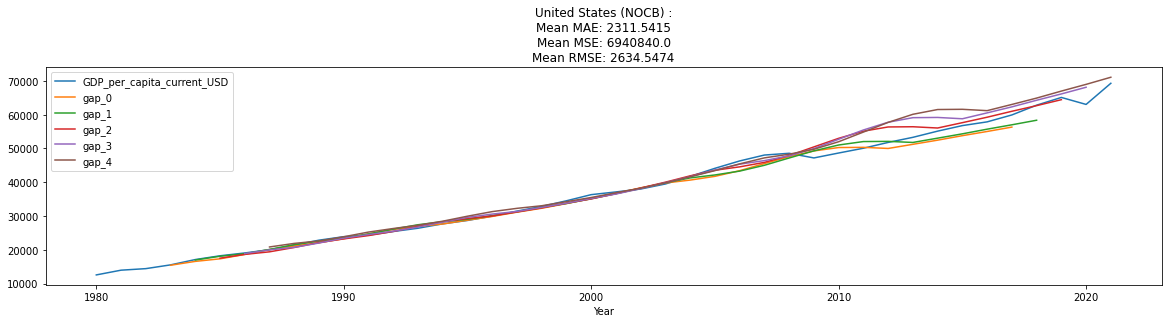

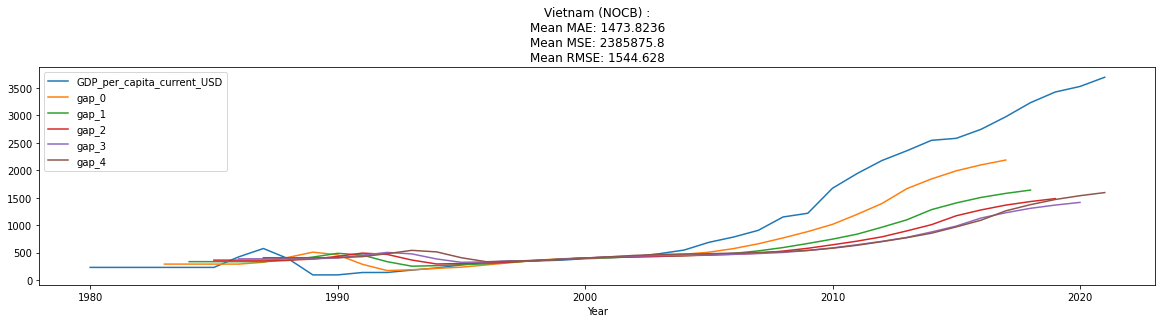

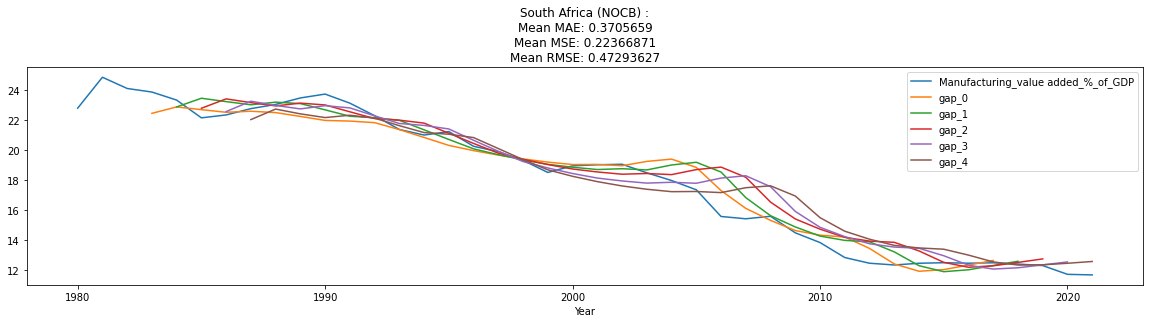

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_m, 3):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### Rolling Stats

China Rolling statistics :
Total Modelling Time:  20.506765604019165
MAE [1445852700000.0, 1651419100000.0, 2039743600000.0, 2294746000000.0, 2223267600000.0]  Mean MAE 1931005900000.0 
MSE [2.3517495e+24, 2.9820485e+24, 4.4719488e+24, 5.583652e+24, 5.127978e+24]  Mean MSE 4.103475e+24 
RMSE [1533541500000.0, 1726860900000.0, 2114698200000.0, 2362975200000.0, 2264504000000.0] Mean RMSE 2025703600000.0


CHN_Rolling statistics
2022            2.575080e+12
2023            2.896612e+12
2024            2.826507e+12
2025            3.022148e+12
2026            3.590216e+12



United Kingdom Rolling statistics :
Total Modelling Time:  19.49856400489807
MAE [645264900000.0, 723310940000.0, 672015000000.0, 618987600000.0, 478342940000.0]  Mean MAE 627584340000.0 
MSE [4.187564e+23, 5.244932e+23, 4.518235e+23, 3.8320074e+23, 2.2912629e+23]  Mean MSE 4.0148002e+23 
RMSE [647113930000.0, 724219100000.0, 672178200000.0, 619032100000.0, 478671370000.0] Mean RMSE 633624500000.0


GBR_Rolling statistics
2022            1.568175e+12
2023            1.517455e+12
2024            1.596544e+12
2025            1.665526e+12
2026            1.826445e+12



Hong Kong SAR, China Rolling statistics :
Total Modelling Time:  19.28582000732422
MAE [42516554000.0, 57863770000.0, 68382480000.0, 82108210000.0, 89773810000.0]  Mean MAE 68128970000.0 
MSE [1.9771879e+21, 3.585846e+21, 4.9642306e+21, 7.0494727e+21, 8.330214e+21]  Mean MSE 5.18139e+21 
RMSE [44465582000.0, 59881935000.0, 70457295000.0, 83961135000.0, 91270005000.0] Mean RMSE 71981875000.0


HKG_Rolling statistics
2022            1.509534e+11
2023            1.406411e+11
2024            1.384147e+11
2025            1.311907e+11
2026            1.339066e+11



India Rolling statistics :
Total Modelling Time:  20.681382656097412
MAE [2.4686358, 3.1736095, 3.0492153, 1.566307, 0.50627154]  Mean MAE 2.152808 
MSE [6.1509075, 10.164958, 9.334636, 2.5221484, 0.30388403]  Mean MSE 5.6953073 
RMSE [2.4801023, 3.1882532, 3.0552635, 1.5881274, 0.5512568] Mean RMSE 2.3864844


IND_Rolling statistics
2022               12.285029
2023               11.419683
2024               11.856453
2025               13.855844
2026               16.031448



Iran, Islamic Rep. Rolling statistics :
Total Modelling Time:  19.824265956878662
MAE [6.3146157, 5.7166066, 5.0156174, 4.422024, 4.2029247]  Mean MAE 5.1343584 
MSE [42.476147, 35.202625, 27.710928, 23.088163, 22.423735]  Mean MSE 30.180323 
RMSE [6.5173726, 5.93318, 5.2641172, 4.8050146, 4.7353706] Mean RMSE 5.493662


IRN_Rolling statistics
2022               11.490292
2023               12.322870
2024               13.306139
2025               14.161228
2026               14.669475



Italy Rolling statistics :
Total Modelling Time:  19.34118413925171
MAE [783321600000.0, 805829540000.0, 787890900000.0, 790472200000.0, 775964400000.0]  Mean MAE 788695800000.0 
MSE [6.1564286e+23, 6.5090886e+23, 6.220611e+23, 6.2730805e+23, 6.0577645e+23]  Mean MSE 6.243395e+23 
RMSE [784629100000.0, 806789250000.0, 788708500000.0, 792027800000.0, 778316400000.0] Mean RMSE 790151560000.0


ITA_Rolling statistics
2022            8.460115e+11
2023            8.308799e+11
2024            8.446490e+11
2025            8.381550e+11
2026            8.548562e+11



Russian Federation Rolling statistics :
Cannot handle RUS, Rolling statistics
United States Rolling statistics :
Total Modelling Time:  19.986125230789185
MAE [1403789400000.0, 1110847300000.0, 942448900000.0, 727051340000.0, 173797620000.0]  Mean MAE 871586860000.0 
MSE [2.0923835e+24, 1.3571944e+24, 1.0302941e+24, 6.47089e+23, 4.439583e+22]  Mean MSE 1.0342714e+24 
RMSE [1446507300000.0, 1164986800000.0, 1015034000000.0, 804418400000.0, 210703190000.0] Mean RMSE 1016991300000.0


USA_Rolling statistics
2022            1.274083e+13
2023            1.364296e+13
2024            1.436832e+13
2025            1.527145e+13
2026            1.674835e+13



Vietnam Rolling statistics :
Cannot handle VNM, Rolling statistics
South Africa Rolling statistics :
Total Modelling Time:  19.941158294677734
MAE [0.7786487, 0.15287209, 0.1538121, 0.28854513, 0.40675163]  Mean MAE 0.35612592 
MSE [0.66866773, 0.04899915, 0.035203237, 0.10922837, 0.1827944]  Mean MSE 0.20897856 
RMSE [0.81772107, 0.22135751, 0.18762526, 0.33049715, 0.42754462] Mean RMSE 0.45714173


ZAF_Rolling statistics
2022               12.701384
2023               13.490002
2024               13.136755
2025               13.226810
2026               13.187315

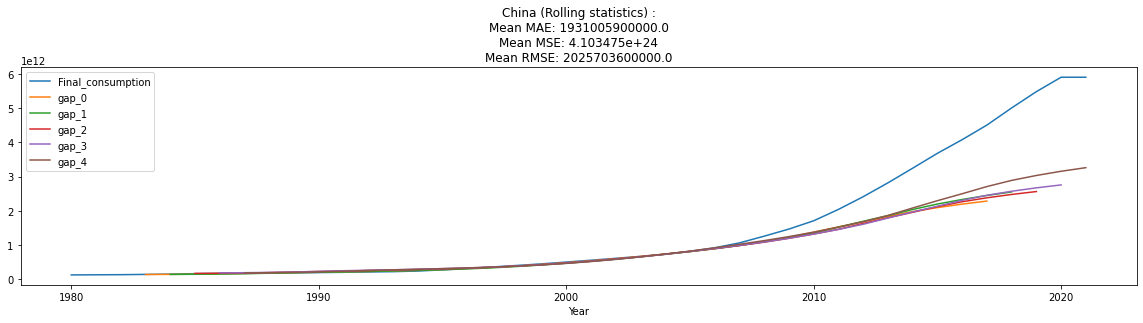

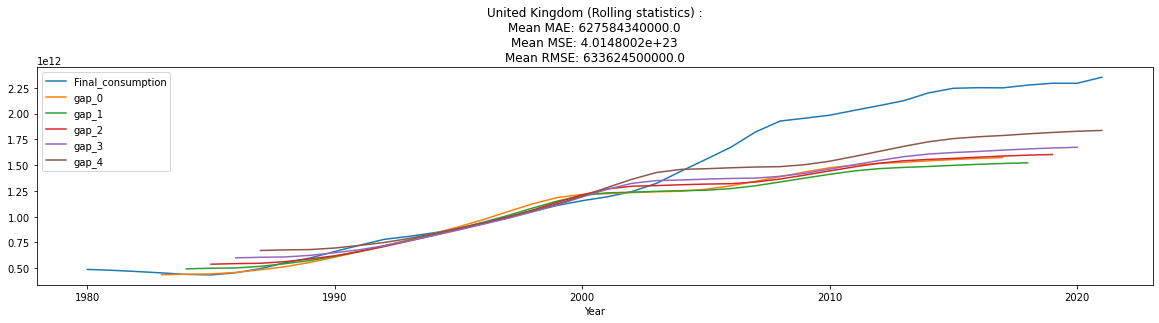

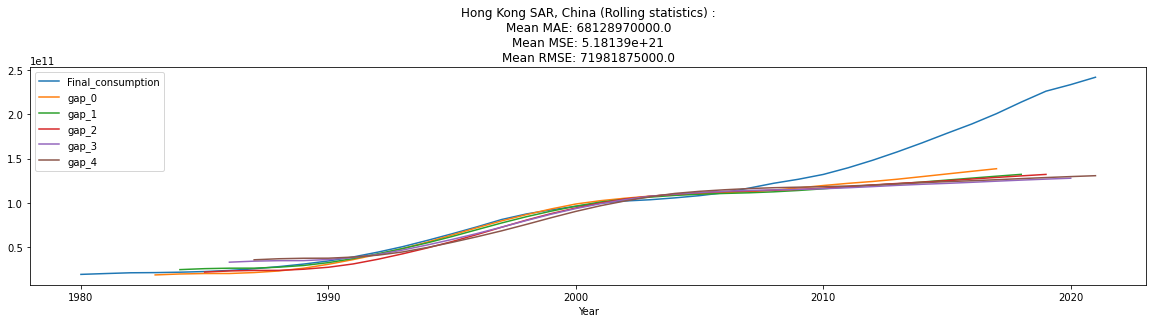

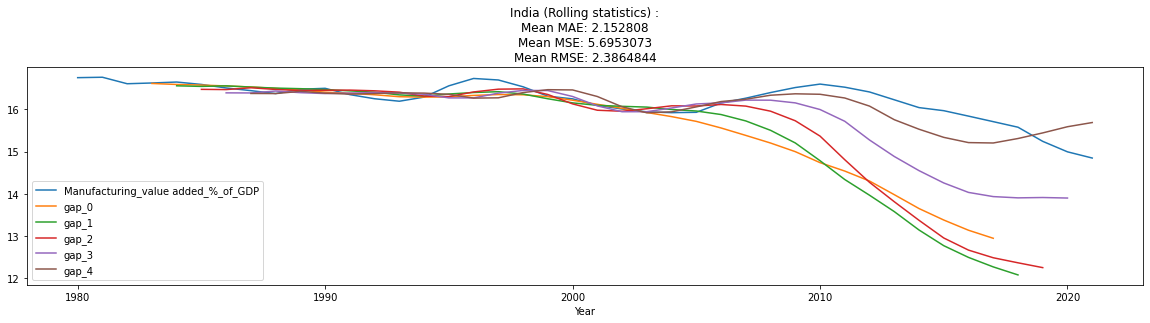

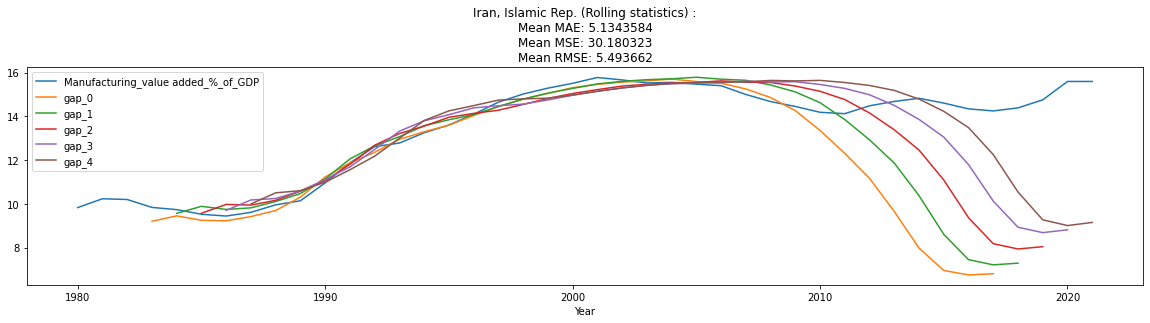

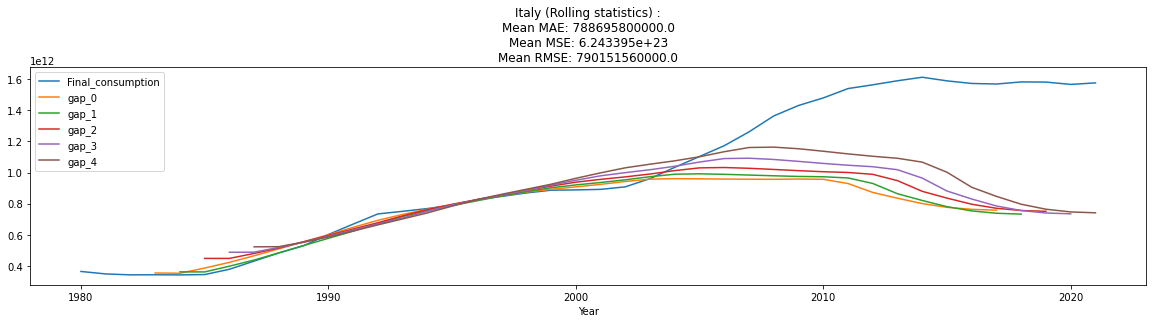

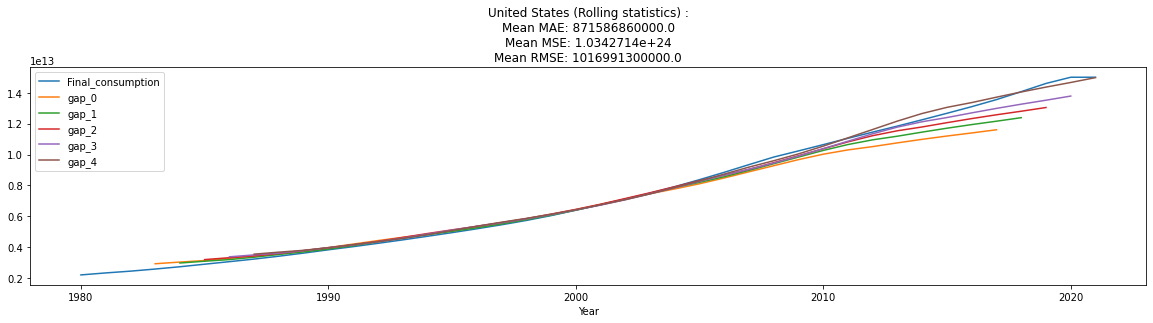

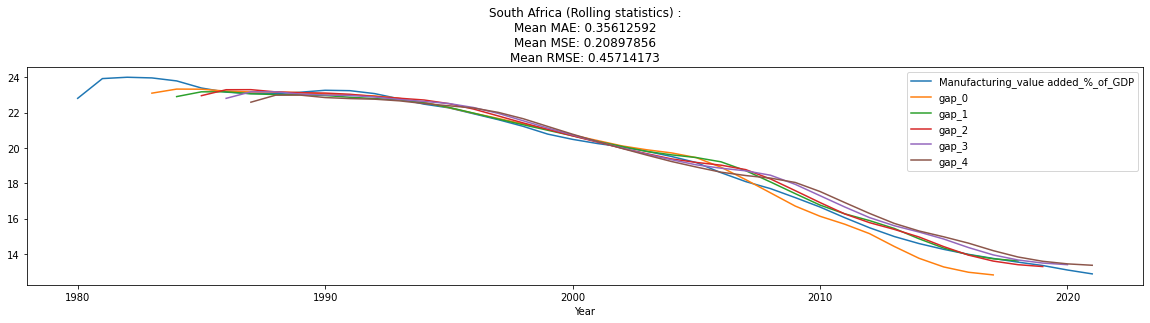

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_m, 4):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### Interpolate

China Interpolate :
Total Modelling Time:  19.370464086532593
MAE [2532387800000.0, 2858715200000.0, 3241407700000.0, 2959624400000.0, 2069774600000.0]  Mean MAE 2732382000000.0 
MSE [6.726411e+24, 8.6028495e+24, 1.1015188e+25, 9.1218573e+24, 4.4037275e+24]  Mean MSE 7.974007e+24 
RMSE [2593532400000.0, 2933061600000.0, 3318913700000.0, 3020241200000.0, 2098506000000.0] Mean RMSE 2823828500000.0


CHN_Interpolate
2022     3.729263e+12
2023     3.877710e+12
2024     3.917306e+12
2025     4.872309e+12
2026     6.629497e+12



United Kingdom Interpolate :
Total Modelling Time:  19.194368362426758
MAE [222081120000.0, 164577020000.0, 146895540000.0, 298732360000.0, 611947500000.0]  Mean MAE 288846700000.0 
MSE [6.773091e+22, 4.3660975e+22, 4.4365163e+22, 1.1258142e+23, 3.9121023e+23]  Mean MSE 1.3190974e+23 
RMSE [260251630000.0, 208952080000.0, 210630400000.0, 335531540000.0, 625468000000.0] Mean RMSE 363193800000.0


GBR_Interpolate
2022     2.231194e+12
2023     2.323517e+12
2024     2.354935e+12
2025     2.688097e+12
2026     3.058940e+12



Hong Kong SAR, China Interpolate :
Total Modelling Time:  20.73382878303528
MAE [77106586000.0, 96639386000.0, 111830330000.0, 122978920000.0, 128234150000.0]  Mean MAE 107357890000.0 
MSE [6.18592e+21, 9.715556e+21, 1.2927523e+22, 1.5412139e+22, 1.6624664e+22]  Mean MSE 1.2173161e+22 
RMSE [78650620000.0, 98567520000.0, 113699270000.0, 124145630000.0, 128936665000.0] Mean RMSE 110332050000.0


HKG_Interpolate
2022     1.723640e+11
2023     1.615866e+11
2024     1.569428e+11
2025     1.505425e+11
2026     1.530941e+11



India Interpolate :
Total Modelling Time:  22.76055645942688
MAE [2.2611632, 1.4465264, 0.80984765, 0.8140251, 4.210774]  Mean MAE 1.9084674 
MSE [5.3511767, 2.1644402, 0.70183295, 0.73541707, 20.793022]  Mean MSE 5.949178 
RMSE [2.313261, 1.4712037, 0.8377547, 0.8575646, 4.5599365] Mean RMSE 2.4390938


IND_Interpolate
2022        11.282356
2023        12.858117
2024        14.100659
2025        14.532286
2026        21.932549



Iran, Islamic Rep. Interpolate :
Total Modelling Time:  20.19988441467285
MAE [17.228598, 20.874298, 25.484375, 26.313063, 25.665733]  Mean MAE 23.113216 
MSE [309.46494, 447.98215, 669.1796, 713.5263, 683.90094]  Mean MSE 564.8108 
RMSE [17.591616, 21.165588, 25.868507, 26.711914, 26.1515] Mean RMSE 23.765749


IRN_Interpolate
2022        15.324153
2023        15.593558
2024        15.595402
2025        15.149030
2026        15.090652



Italy Interpolate :
Total Modelling Time:  19.12571144104004
MAE [1812174900000.0, 1670961400000.0, 1445508000000.0, 1229043900000.0, 1181956000000.0]  Mean MAE 1467928800000.0 
MSE [3.43178e+24, 2.8644237e+24, 2.1276698e+24, 1.5179307e+24, 1.4010602e+24]  Mean MSE 2.268573e+24 
RMSE [1852506400000.0, 1692460800000.0, 1458653400000.0, 1232043200000.0, 1183663900000.0] Mean RMSE 1506178200000.0


ITA_Interpolate
2022     6.066922e+11
2023     5.425519e+11
2024     5.810888e+11
2025     6.073169e+11
2026     5.675294e+11



Russian Federation Interpolate :
Cannot handle RUS, Interpolate
United States Interpolate :
Total Modelling Time:  19.61355972290039
MAE [1590865600000.0, 1460159500000.0, 837468600000.0, 469556700000.0, 530994170000.0]  Mean MAE 977808900000.0 
MSE [2.8041902e+24, 2.5333156e+24, 1.13608e+24, 2.9470828e+23, 3.6673154e+23]  Mean MSE 1.4270051e+24 
RMSE [1674571700000.0, 1591639300000.0, 1065870560000.0, 542870400000.0, 605583640000.0] Mean RMSE 1194573200000.0


USA_Interpolate
2022     1.487631e+13
2023     1.569320e+13
2024     1.739716e+13
2025     1.923085e+13
2026     2.009621e+13



Vietnam Interpolate :
Cannot handle VNM, Interpolate
South Africa Interpolate :
Total Modelling Time:  19.187005281448364
MAE [0.9648657, 0.8573313, 0.8837085, 0.4605061, 0.4871715]  Mean MAE 0.7307166 
MSE [1.2045935, 0.9385008, 0.9116996, 0.4024469, 0.25736287]  Mean MSE 0.7429208 
RMSE [1.0975398, 0.9687625, 0.95482963, 0.634387, 0.50730944] Mean RMSE 0.8619285


ZAF_Interpolate
2022        13.476731
2023        13.307991
2024        14.301722
2025        13.648612
2026        13.356308

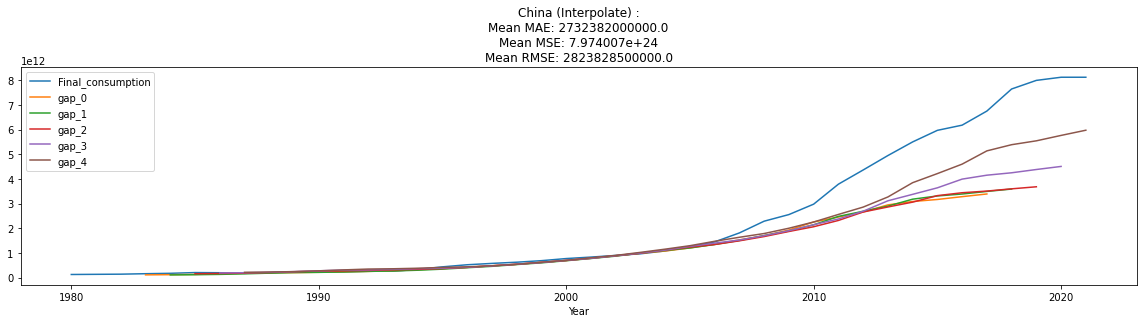

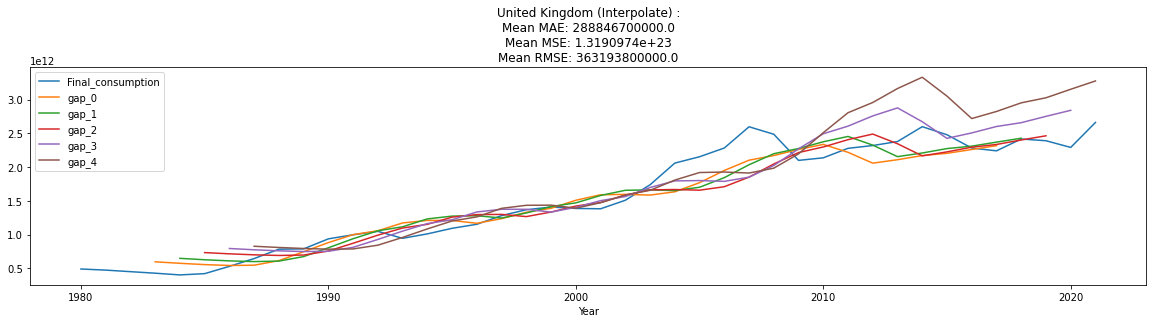

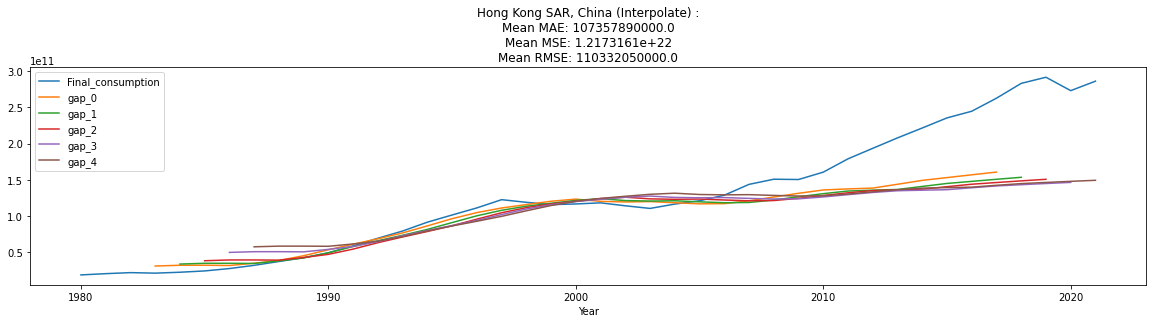

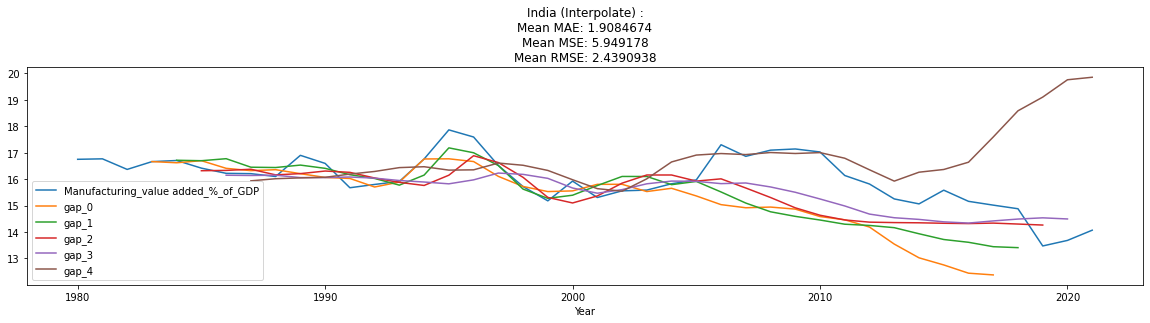

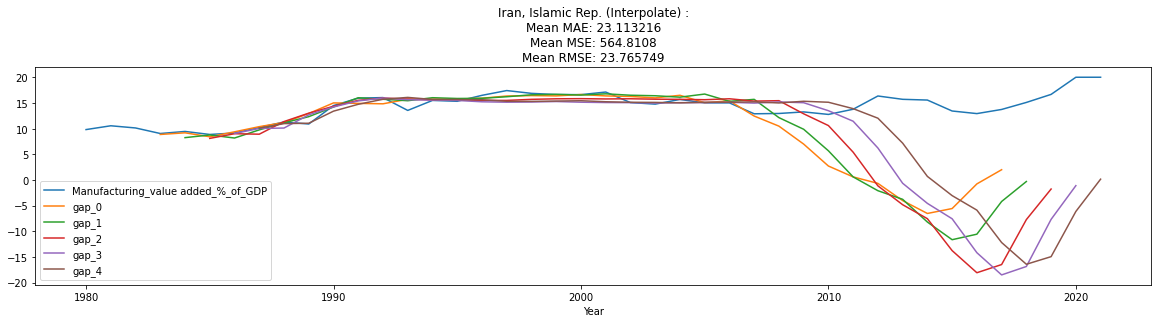

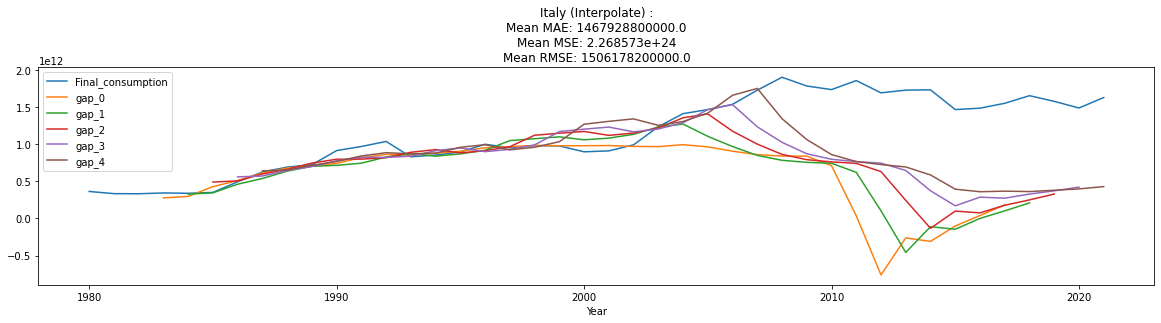

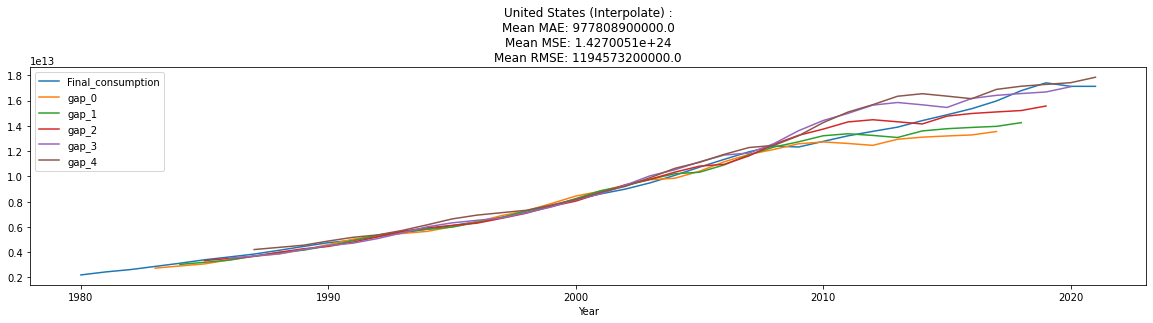

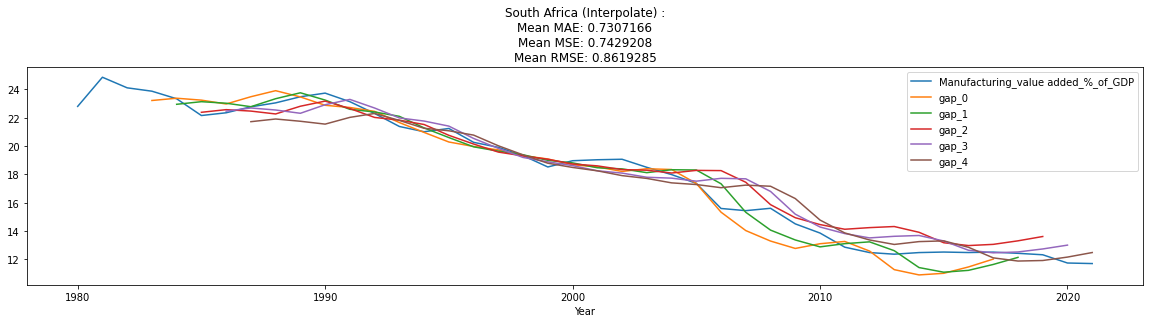

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_m, 5):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### Summary

In [ ]:
pd.DataFrame({
    'country': c,
    'method': m,
    'MAE': a,
    'MSE': s,
    'RMSE': r
})

country              method           MAE           MSE          RMSE
0      CHN                Mean  1.656582e+00  3.321583e+00  1.822521e+00
1      GBR                Mean  3.130034e+00  1.237244e+01  3.517448e+00
2      HKG                Mean  5.068020e-01  3.511030e-01  5.925394e-01
3      IND                Mean  9.334595e-01  1.495317e+00  1.222831e+00
4      IRN                Mean  5.188987e+00  3.809856e+01  6.172403e+00
5      ITA                Mean  4.752258e+00  2.334151e+01  4.831306e+00
6      RUS                Mean  1.127569e+00  1.756595e+00  1.325366e+00
7      USA                Mean  6.677325e-01  6.893723e-01  8.302845e-01
8      VNM                Mean  2.752798e-01  9.472934e-02  3.077813e-01
9      ZAF                Mean  3.857934e+00  1.517572e+01  3.895602e+00
10     CHN              Median  2.510882e+00  7.448076e+00  2.729116e+00
11     GBR              Median  2.953459e+00  1.350356e+01  3.674718e+00
12     HKG              Median  4.350917e-01  2.100029e-01  4.582607e-01
13     IND              Median  9.454225e-01  1.459338e+00  1.208031e+00
14     IRN              Median  5.428186e+00  5.095905e+01  7.138560e+00
15     ITA              Median  4.148699e+00  1.848173e+01  4.299038e+00
16     RUS              Median  8.917671e-01  1.217620e+00  1.103458e+00
17     USA              Median  8.314478e-01  1.068110e+00  1.033494e+00
18     VNM              Median  2.774726e-01  9.634827e-02  3.104002e-01
19     ZAF              Median  4.507684e+00  2.074884e+01  4.555089e+00
20     CHN                LOCF  2.849153e+12  8.589129e+24  2.930721e+12
21     GBR                LOCF  4.782610e+11  4.006001e+23  6.329298e+11
22     HKG                LOCF  1.143194e+11  1.376571e+22  1.173274e+11
23     IND                LOCF  2.236657e+00  8.843939e+00  2.973876e+00
24     IRN                LOCF  2.313238e+01  5.540551e+02  2.353837e+01
25     ITA                LOCF  1.409144e+12  2.054645e+24  1.433403e+12
26     USA                LOCF  1.156660e+12  1.907887e+24  1.381263e+12
27     ZAF                LOCF  7.704646e-01  8.546141e-01  9.244534e-01
28     CHN                NOCB  3.579460e+00  1.462346e+01  3.824063e+00
29     GBR                NOCB  7.511390e+00  5.898535e+01  7.680192e+00
30     HKG                NOCB  1.141123e+11  1.382366e+22  1.175740e+11
31     IND                NOCB  9.354492e-01  1.212176e+00  1.100989e+00
32     ITA                NOCB  1.763502e+00  3.659460e+00  1.912971e+00
33     RUS                NOCB  2.845902e+00  8.891617e+00  2.981881e+00
34     USA                NOCB  2.311542e+03  6.940840e+06  2.634547e+03
35     VNM                NOCB  1.473824e+03  2.385876e+06  1.544628e+03
36     ZAF                NOCB  3.705659e-01  2.236687e-01  4.729363e-01
37     CHN  Rolling statistics  1.931006e+12  4.103475e+24  2.025704e+12
38     GBR  Rolling statistics  6.275843e+11  4.014800e+23  6.336245e+11
39     HKG  Rolling statistics  6.812897e+10  5.181390e+21  7.198188e+10
40     IND  Rolling statistics  2.152808e+00  5.695307e+00  2.386484e+00
41     IRN  Rolling statistics  5.134358e+00  3.018032e+01  5.493662e+00
42     ITA  Rolling statistics  7.886958e+11  6.243395e+23  7.901516e+11
43     USA  Rolling statistics  8.715869e+11  1.034271e+24  1.016991e+12
44     ZAF  Rolling statistics  3.561259e-01  2.089786e-01  4.571417e-01
45     CHN         Interpolate  2.732382e+12  7.974007e+24  2.823829e+12
46     GBR         Interpolate  2.888467e+11  1.319097e+23  3.631938e+11
47     HKG         Interpolate  1.073579e+11  1.217316e+22  1.103321e+11
48     IND         Interpolate  1.908467e+00  5.949178e+00  2.439094e+00
49     IRN         Interpolate  2.311322e+01  5.648108e+02  2.376575e+01
50     ITA         Interpolate  1.467929e+12  2.268573e+24  1.506178e+12
51     USA         Interpolate  9.778089e+11  1.427005e+24  1.194573e+12
52     ZAF         Interpolate  7.307166e-01  7.429208e-01  8.619285e-01

##### Service

In [ ]:
c, m, a, s, r = [], [], [], [], []

###### Mean

China Mean :
Total Modelling Time:  19.43876075744629
MAE [1.2369705, 1.1584368, 1.2964312, 1.7409191, 2.0149848]  Mean MAE 1.4895484 
MSE [1.9919776, 1.8894135, 1.9049588, 3.1212654, 4.461875]  Mean MSE 2.673898 
RMSE [1.4113743, 1.3745594, 1.3802024, 1.7667103, 2.1123152] Mean RMSE 1.6352057


CHN_Mean
2022  30.167362
2023  29.801289
2024  27.747318
2025  26.744434
2026  26.885698



United Kingdom Mean :
Total Modelling Time:  18.907973527908325
MAE [2.7529137, 2.850774, 2.993562, 3.137992, 3.0653973]  Mean MAE 2.960128 
MSE [8.807052, 10.054061, 10.989337, 12.554248, 12.592038]  Mean MSE 10.999348 
RMSE [2.9676678, 3.170814, 3.315017, 3.5431974, 3.5485263] Mean RMSE 3.3165264


GBR_Mean
2022  11.789134
2023  11.823430
2024  11.582203
2025  12.204173
2026  12.521259



Hong Kong SAR, China Mean :
Total Modelling Time:  19.68632745742798


MAE [0.47191525, 0.415126, 0.49550518, 0.53844166, 0.64549154]  Mean MAE 0.51329595 
MSE [0.24441648, 0.21937841, 0.31395924, 0.3907944, 0.60492057]  Mean MSE 0.35469383 
RMSE [0.49438494, 0.46837848, 0.5603207, 0.6251355, 0.7777664] Mean RMSE 0.5955618


HKG_Mean
2022  1.863845
2023  2.270794
2024  2.424425
2025  2.499208
2026  2.681265



India Mean :
Total Modelling Time:  19.0073401927948
MAE [0.36466122, 0.21609418, 0.68444794, 1.2939433, 1.6974834]  Mean MAE 0.85132587 
MSE [0.17079294, 0.06426222, 0.8021253, 2.0554855, 3.2216299]  Mean MSE 1.2628592 
RMSE [0.413271, 0.25349993, 0.89561445, 1.4336964, 1.7948899] Mean RMSE 1.1237701


IND_Mean
2022  15.773293
2023  15.271932
2024  15.156704
2025  14.624031
2026  14.900194



Iran, Islamic Rep. Mean :
Total Modelling Time:  17.052205085754395
MAE [5.5762653, 1.0160619, 4.4261155, 5.769078, 7.923483]  Mean MAE 4.942201 
MSE [38.599354, 1.3362961, 22.516167, 43.316463, 71.79929]  Mean MSE 35.51351 
RMSE [6.2128377, 1.1559827, 4.7451205, 6.5815244, 8.473447] Mean RMSE 5.9593215


IRN_Mean
2022  16.477505
2023  17.759869
2024  17.718658
2025  17.086208
2026  17.454697



Italy Mean :
Total Modelling Time:  18.705533027648926
MAE [4.0605674, 4.575231, 5.1609097, 5.422343, 5.031325]  Mean MAE 4.850075 
MSE [16.686956, 21.410662, 27.487146, 30.255997, 26.127504]  Mean MSE 24.393654 
RMSE [4.084967, 4.627166, 5.2428184, 5.500545, 5.111507] Mean RMSE 4.938993


ITA_Mean
2022  19.091288
2023  19.514782
2024  19.722830
2025  19.527491
2026  19.021315



Russian Federation Mean :
Total Modelling Time:  19.11103892326355
MAE [1.5093719, 1.274947, 0.8266363, 0.7515976, 0.90425223]  Mean MAE 1.0533609 
MSE [2.5143163, 2.0175936, 1.0310271, 0.7245646, 1.5178857]  Mean MSE 1.5610775 
RMSE [1.5856596, 1.4204202, 1.015395, 0.85121363, 1.232025] Mean RMSE 1.2494309


RUS_Mean
2022  13.076580
2023  13.082860
2024  12.730201
2025  12.013297
2026  11.680122



United States Mean :
Total Modelling Time:  18.526043176651
MAE [0.9345786, 0.68065995, 0.46521822, 0.49830547, 0.9059472]  Mean MAE 0.6969419 
MSE [1.0365599, 0.67946583, 0.36276212, 0.38650033, 1.1264007]  Mean MSE 0.71833783 
RMSE [1.0181159, 0.8242972, 0.60229737, 0.6216915, 1.0613203] Mean RMSE 0.8475481


USA_Mean
2022  15.308471
2023  15.706779
2024  15.394862
2025  15.026310
2026  14.693689



Vietnam Mean :
Total Modelling Time:  19.125425100326538
MAE [0.27558887, 0.26398832, 0.27686808, 0.2870887, 0.26952168]  Mean MAE 0.27461112 
MSE [0.092847, 0.083800904, 0.09374344, 0.101688914, 0.09996263]  Mean MSE 0.094408564 
RMSE [0.30470806, 0.28948385, 0.3061755, 0.318887, 0.31616867] Mean RMSE 0.30725977


VNM_Mean
2022  1.241466
2023  1.242229
2024  1.239771
2025  1.240281
2026  1.239174



South Africa Mean :
Total Modelling Time:  17.399450540542603
MAE [5.0157495, 5.0046473, 4.5962214, 3.9763556, 4.051124]  Mean MAE 4.5288196 
MSE [25.195787, 25.083735, 21.162483, 15.971143, 16.632004]  Mean MSE 20.80903 
RMSE [5.019541, 5.0083666, 4.60027, 3.9963913, 4.078235] Mean RMSE 4.5616918


ZAF_Mean
2022  17.821981
2023  17.806829
2024  17.306391
2025  16.364981
2026  16.355112

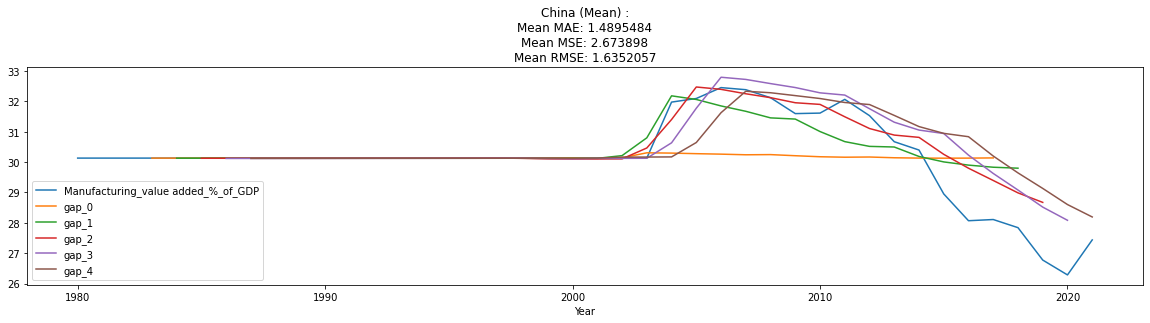

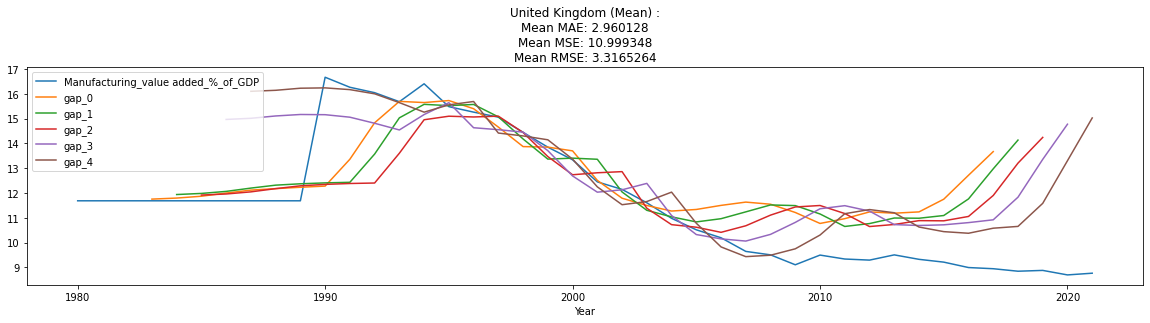

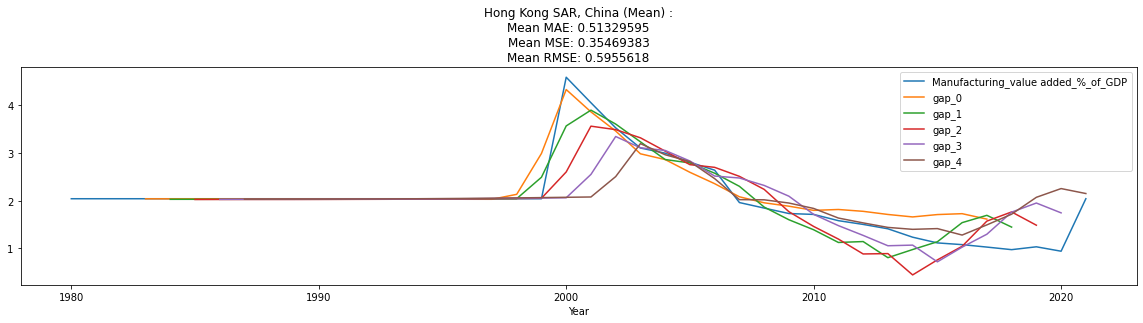

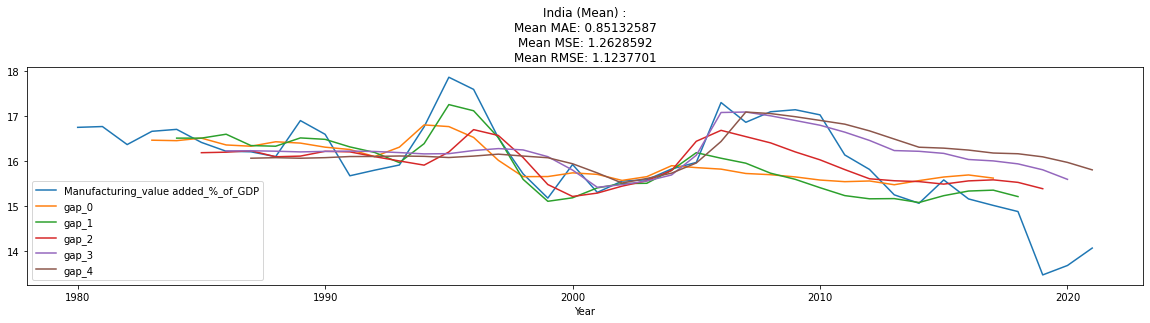

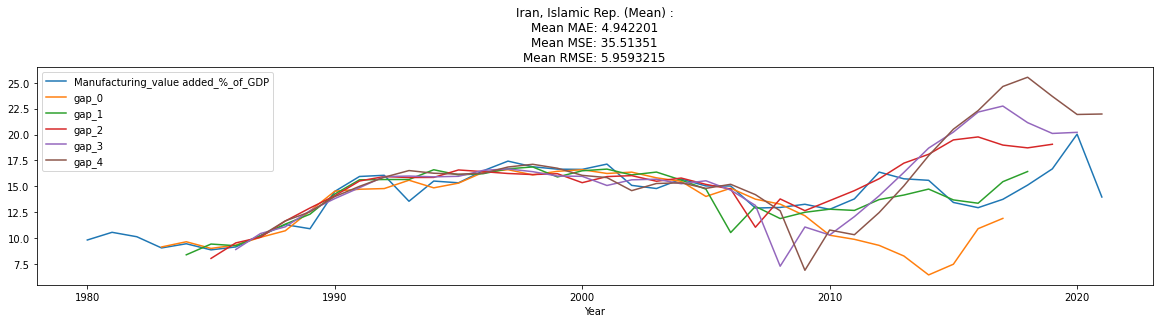

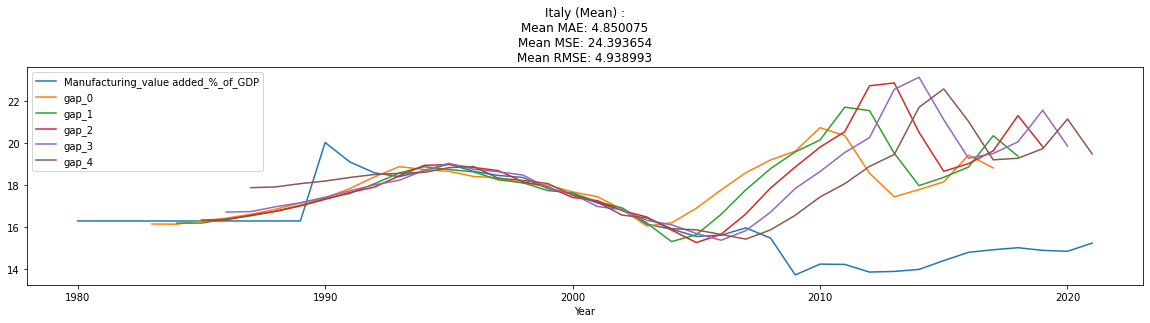

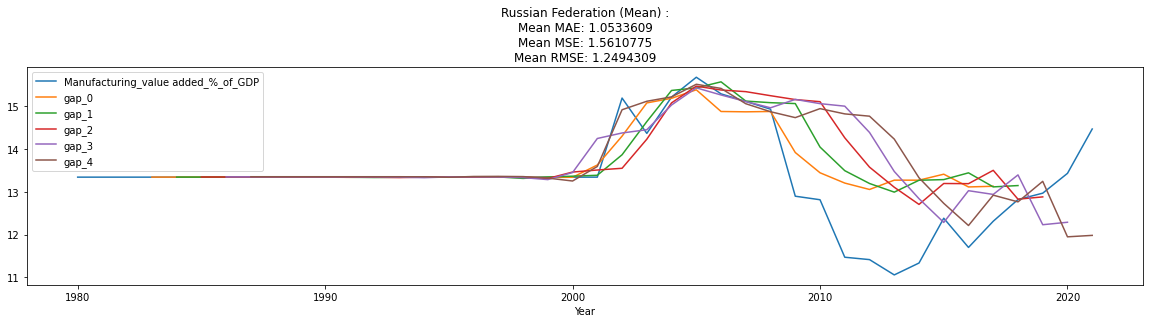

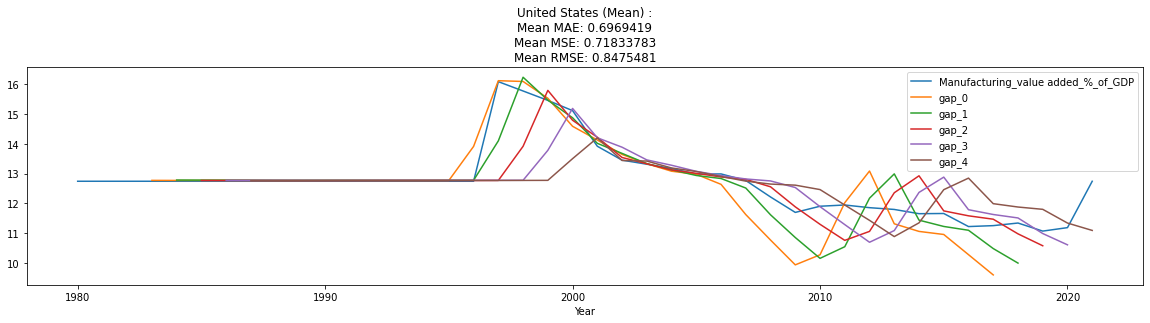

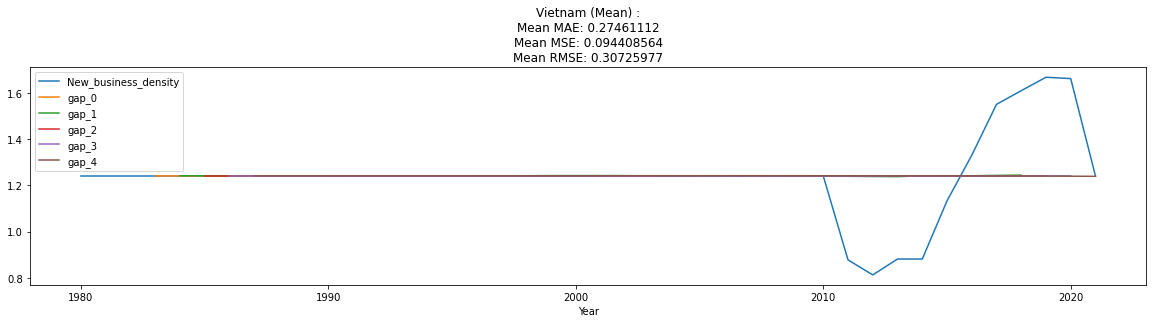

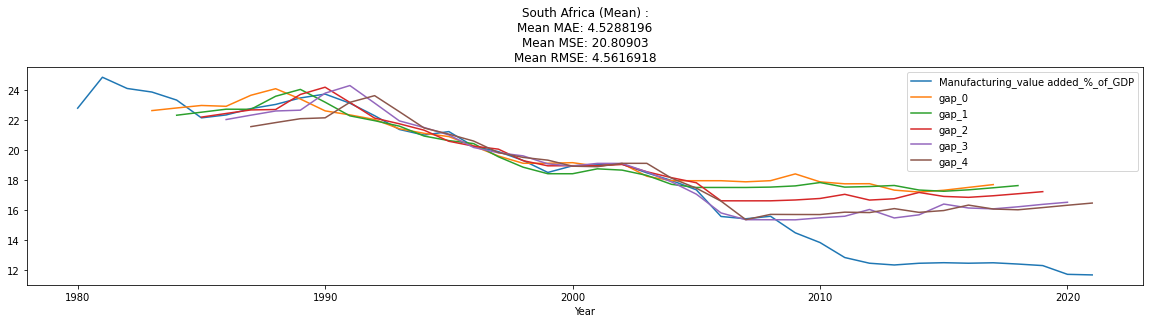

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_s, 0):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  a1, s1, r1 = pipeline(country, method)
  c.append(country)
  m.append(method)
  a.append(a1)
  s.append(s1)
  r.append(r1)
  print('\n')

###### Median

China Median :
Total Modelling Time:  21.72424054145813
MAE [1.6085078, 2.0438268, 2.5094473, 3.1188889, 3.3516705]  Mean MAE 2.5264685 
MSE [3.881258, 5.1634784, 6.8399634, 9.879238, 11.476205]  Mean MSE 7.4480286 
RMSE [1.9700909, 2.2723289, 2.6153324, 3.1431255, 3.3876548] Mean RMSE 2.7291076


CHN_Median
2022   31.108852
2023   30.787306
2024   29.635738
2025   29.231150
2026   29.151880



United Kingdom Median :
Total Modelling Time:  17.755815267562866
MAE [2.5945063, 2.623449, 2.7814665, 2.5688453, 2.3399446]  Mean MAE 2.5816422 
MSE [7.809532, 8.831372, 10.399493, 10.408149, 8.839141]  Mean MSE 9.257538 
RMSE [2.794554, 2.9717624, 3.2248244, 3.2261662, 2.9730692] Mean RMSE 3.0426202


GBR_Median
2022   11.538037
2023   11.679924
2024   11.812374
2025   12.409136
2026   12.691636



Hong Kong SAR, China Median :
Total Modelling Time:  18.370099782943726
MAE [0.9654515, 1.3369435, 1.6153374, 1.538775, 1.3029114]  Mean MAE 1.3518835 
MSE [1.1295384, 2.0438325, 2.8882675, 2.5842154, 1.7867084]  Mean MSE 2.0865126 
RMSE [1.0627974, 1.4296267, 1.6994904, 1.6075495, 1.3366781] Mean RMSE 1.4444766


HKG_Median
2022    2.087760
2023    2.488220
2024    2.760874
2025    2.698149
2026    2.500209



India Median :
Total Modelling Time:  19.46419334411621
MAE [0.35759082, 0.24472205, 0.7141927, 1.441667, 1.7614732]  Mean MAE 0.90392905 
MSE [0.16437657, 0.08202157, 0.8995633, 2.5181024, 3.4949188]  Mean MSE 1.4317966 
RMSE [0.4054338, 0.2863941, 0.9484531, 1.586853, 1.8694702] Mean RMSE 1.1965771


IND_Median
2022   15.929387
2023   15.507658
2024   15.109762
2025   14.582328
2026   14.836399



Iran, Islamic Rep. Median :
Total Modelling Time:  19.47868323326111
MAE [11.3839, 6.7813945, 0.8690383, 2.508386, 5.2512307]  Mean MAE 5.35879 
MSE [142.37825, 49.50397, 1.2805216, 9.396075, 35.105404]  Mean MSE 47.532845 
RMSE [11.932236, 7.035906, 1.1316013, 3.065302, 5.924981] Mean RMSE 6.894407


IRN_Median
2022   15.606573
2023   16.806721
2024   17.293154
2025   16.570829
2026   17.098389



Italy Median :
Total Modelling Time:  18.230041027069092
MAE [4.472087, 4.9463906, 5.3759265, 5.5838523, 5.4138656]  Mean MAE 5.158425 
MSE [20.262136, 25.183065, 30.15354, 32.423798, 30.698328]  Mean MSE 27.744171 
RMSE [4.5013485, 5.0182734, 5.491224, 5.69419, 5.540607] Mean RMSE 5.2672734


ITA_Median
2022   19.269606
2023   19.594818
2024   19.568333
2025   19.416212
2026   19.334858



Russian Federation Median :
Total Modelling Time:  21.13870620727539
MAE [0.9837508, 0.68212444, 0.501816, 0.81045514, 1.1430593]  Mean MAE 0.8242411 
MSE [1.2114247, 0.7157543, 0.30082163, 0.8359143, 2.1144946]  Mean MSE 1.035682 
RMSE [1.1006474, 0.8460226, 0.5484721, 0.9142835, 1.4541302] Mean RMSE 1.0176846


RUS_Median
2022   12.616165
2023   12.334947
2024   12.215720
2025   11.739641
2026   11.642100



United States Median :
Total Modelling Time:  18.32759404182434
MAE [0.98072165, 0.88389236, 0.55891895, 0.5863845, 0.7690719]  Mean MAE 0.7557978 
MSE [1.1696848, 1.063007, 0.5357135, 0.568752, 1.1550745]  Mean MSE 0.89844626 
RMSE [1.0815196, 1.0310223, 0.73192453, 0.7541565, 1.0747439] Mean RMSE 0.94786406


USA_Median
2022   14.756525
2023   15.206295
2024   14.584576
2025   13.854103
2026   13.954498



Vietnam Median :
Total Modelling Time:  18.27311110496521
MAE [0.272376, 0.2661148, 0.27976754, 0.29465404, 0.27635565]  Mean MAE 0.2778536 
MSE [0.09023432, 0.085138775, 0.09594486, 0.107248746, 0.10455155]  Mean MSE 0.09662366 
RMSE [0.30039027, 0.2917855, 0.30974966, 0.32748854, 0.32334432] Mean RMSE 0.31084347


VNM_Median
2022    1.231928
2023    1.229947
2024    1.232126
2025    1.230564
2026    1.231608



South Africa Median :
Total Modelling Time:  18.413655757904053
MAE [4.852755, 4.476906, 3.9684849, 3.5135384, 3.4180384]  Mean MAE 4.0459447 
MSE [23.611015, 20.1089, 15.839028, 12.590312, 12.001658]  Mean MSE 16.830183 
RMSE [4.8591166, 4.484295, 3.9798276, 3.5482829, 3.464341] Mean RMSE 4.1024604


ZAF_Median
2022   17.774078
2023   17.225079
2024   16.804502
2025   16.294834
2026   16.014429

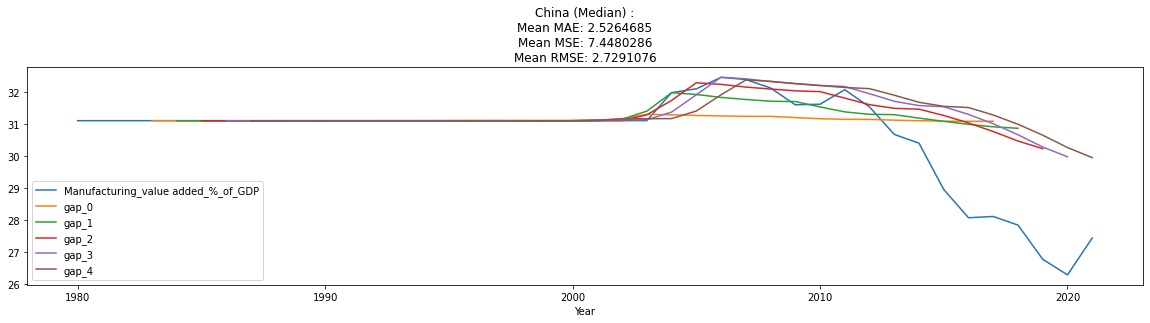

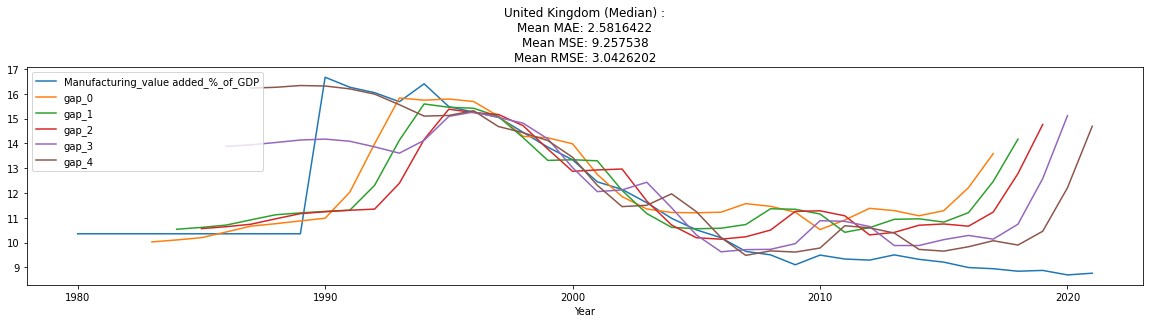

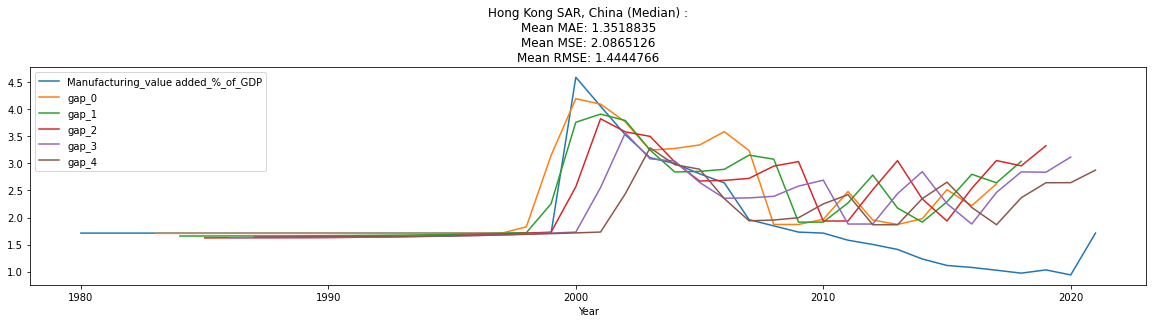

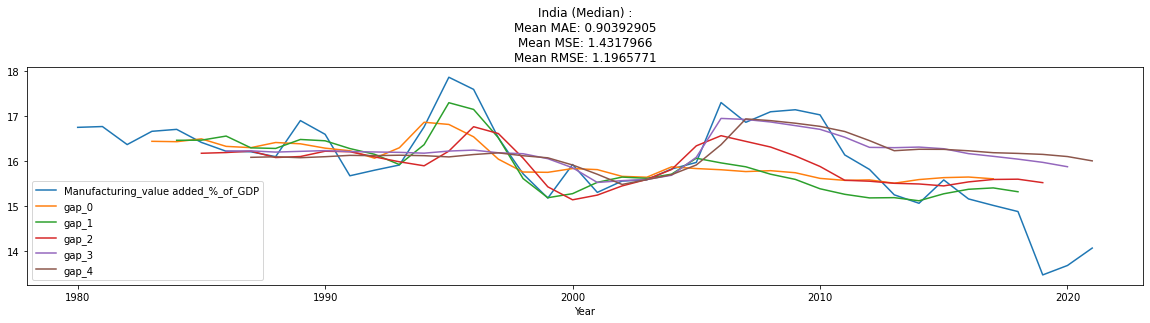

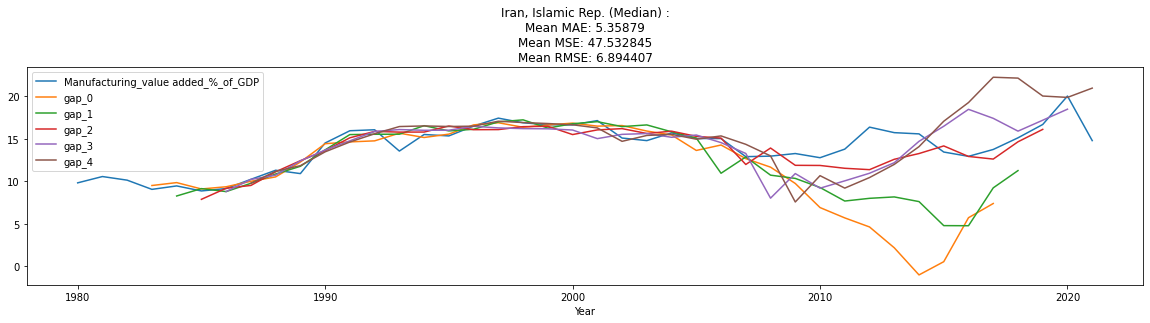

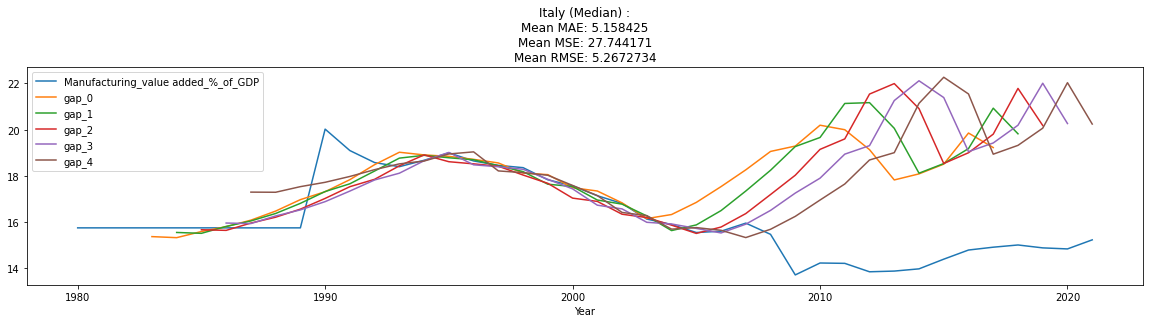

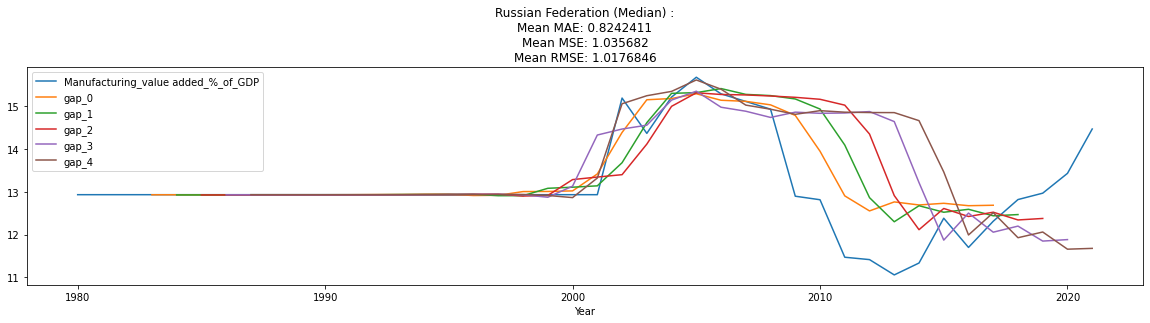

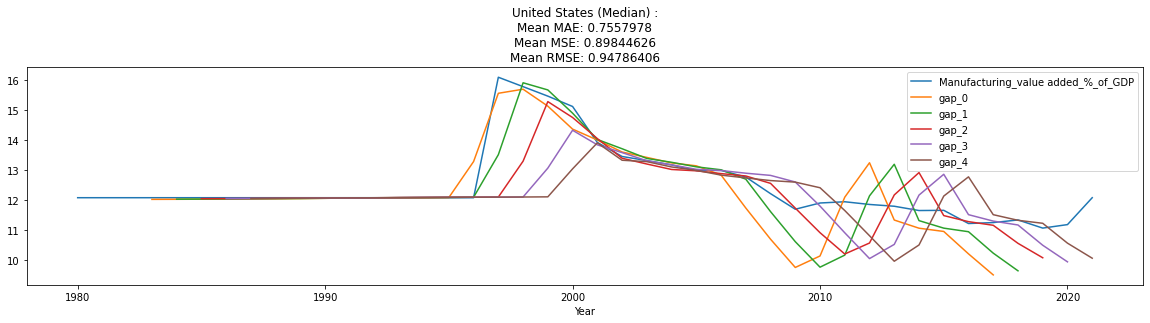

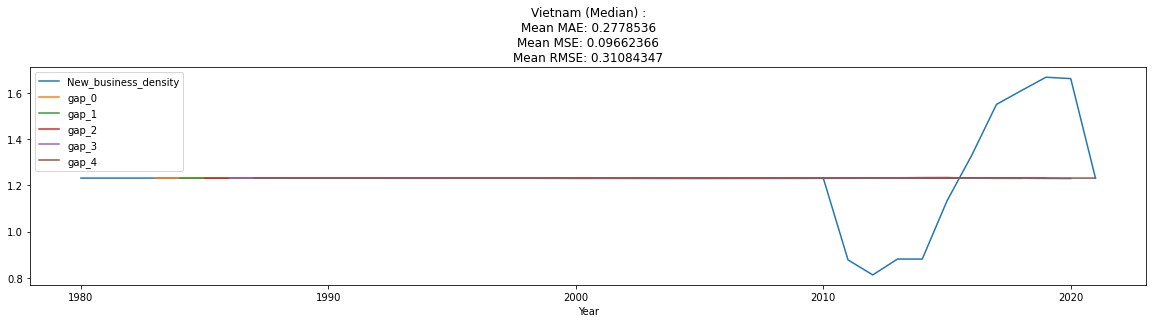

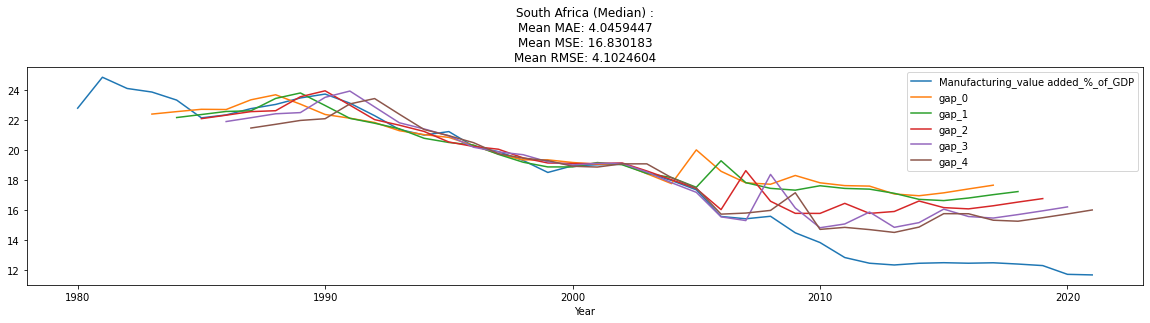

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_s, 1):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### LOCF

China LOCF :
Total Modelling Time:  18.827231407165527
MAE [2627063800000.0, 3004019000000.0, 3493812000000.0, 3376095000000.0, 2159087600000.0]  Mean MAE 2932015400000.0 
MSE [7.2357123e+24, 9.487349e+24, 1.2762291e+25, 1.1849982e+25, 4.8049964e+24]  Mean MSE 9.228067e+24 
RMSE [2689928000000.0, 3080154000000.0, 3572435000000.0, 3442380400000.0, 2192030200000.0] Mean RMSE 3037773400000.0


CHN_LOCF
2022  3.582507e+12
2023  3.677170e+12
2024  3.570470e+12
2025  4.220474e+12
2026  6.428542e+12



United Kingdom LOCF :
Total Modelling Time:  18.061741828918457
MAE [157919920000.0, 166848580000.0, 421105370000.0, 835674900000.0, 1475397700000.0]  Mean MAE 611389200000.0 
MSE [3.7217736e+22, 3.607432e+22, 2.2984418e+23, 7.6844286e+23, 2.236241e+24]  Mean MSE 6.61564e+23 
RMSE [192919000000.0, 189932400000.0, 479420680000.0, 876608750000.0, 1495406600000.0] Mean RMSE 813365850000.0


GBR_LOCF
2022  2.474160e+12
2023  2.375645e+12
2024  2.886622e+12
2025  3.286899e+12
2026  3.994130e+12



Hong Kong SAR, China LOCF :
Total Modelling Time:  18.552830696105957
MAE [80122495000.0, 102060655000.0, 115978960000.0, 127800530000.0, 134902820000.0]  Mean MAE 112173080000.0 
MSE [6.6987976e+21, 1.08481e+22, 1.3921641e+22, 1.6649997e+22, 1.841093e+22]  Mean MSE 1.3305892e+22 
RMSE [81846180000.0, 104154210000.0, 117990010000.0, 129034870000.0, 135686880000.0] Mean RMSE 115351170000.0


HKG_LOCF
2022  1.649524e+11
2023  1.516515e+11
2024  1.491598e+11
2025  1.427847e+11
2026  1.417588e+11



India LOCF :
Total Modelling Time:  19.10436177253723
MAE [2.5842302, 2.157171, 0.5585122, 0.94680595, 4.7463346]  Mean MAE 2.198611 
MSE [6.936008, 4.8465486, 0.4270772, 1.009818, 26.525846]  Mean MSE 7.9490595 
RMSE [2.6336303, 2.2014878, 0.65351146, 1.004897, 5.150325] Mean RMSE 2.8194077


IND_LOCF
2022  10.915240
2023  11.521825
2024  14.528443
2025  14.309124
2026  23.154776



Iran, Islamic Rep. LOCF :
Total Modelling Time:  18.27824115753174
MAE [17.562056, 17.479586, 22.223673, 24.32767, 20.074062]  Mean MAE 20.33341 
MSE [327.0751, 319.12082, 517.4677, 621.57745, 424.61353]  Mean MSE 441.97092 
RMSE [18.085218, 17.863953, 22.747917, 24.931456, 20.606153] Mean RMSE 21.023104


IRN_LOCF
2022  15.131895
2023  16.019627
2024  16.045908
2025  15.496013
2026  15.577259



Italy LOCF :
Total Modelling Time:  18.16382598876953
MAE [1552322300000.0, 1510846500000.0, 1237209200000.0, 1277970500000.0, 1198718300000.0]  Mean MAE 1355413600000.0 
MSE [2.5055662e+24, 2.333075e+24, 1.5528079e+24, 1.6407122e+24, 1.4409599e+24]  Mean MSE 1.8946242e+24 
RMSE [1582898100000.0, 1527440700000.0, 1246117100000.0, 1280903000000.0, 1200399800000.0] Mean RMSE 1376453500000.0


ITA_LOCF
2022  6.764910e+11
2023  5.747257e+11
2024  6.414796e+11
2025  5.608849e+11
2026  5.603941e+11



Russian Federation LOCF :
Cannot handle RUS, LOCF
United States LOCF :
Total Modelling Time:  17.668314218521118
MAE [1580366200000.0, 1127376600000.0, 1265280400000.0, 473140560000.0, 624676900000.0]  Mean MAE 1014168100000.0 
MSE [2.7420252e+24, 1.6019681e+24, 2.0479974e+24, 2.8997797e+23, 5.0608772e+23]  Mean MSE 1.4376111e+24 
RMSE [1655906100000.0, 1265688800000.0, 1431082600000.0, 538496040000.0, 711398460000.0] Mean RMSE 1199004200000.0


USA_LOCF
2022  1.502640e+13
2023  1.637327e+13
2024  1.679177e+13
2025  1.971471e+13
2026  2.049498e+13



Vietnam LOCF :
Cannot handle VNM, LOCF
South Africa LOCF :
Total Modelling Time:  17.067516803741455
MAE [0.5165682, 0.8122282, 0.36677137, 0.6336691, 0.48517212]  Mean MAE 0.56288177 
MSE [0.32413688, 0.84548235, 0.17351973, 0.5991289, 0.27019382]  Mean MSE 0.44249237 
RMSE [0.5693302, 0.9195011, 0.41655698, 0.7740342, 0.51980174] Mean RMSE 0.665201


ZAF_LOCF
2022  14.101904
2023  14.508674
2024  13.653471
2025  13.784033
2026  13.151180

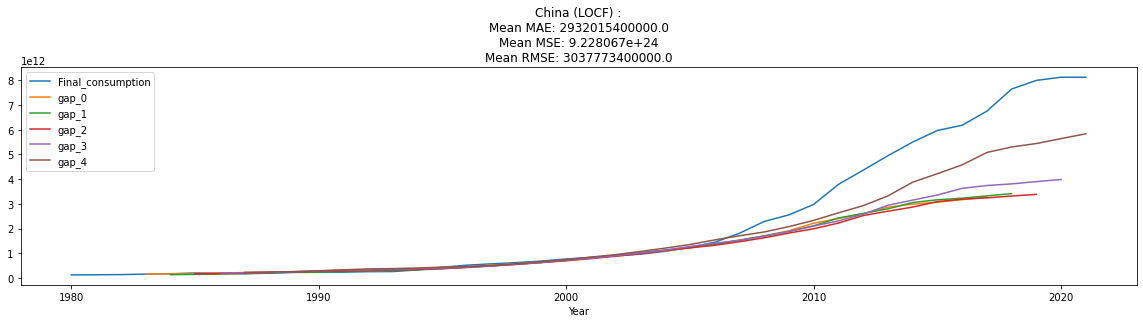

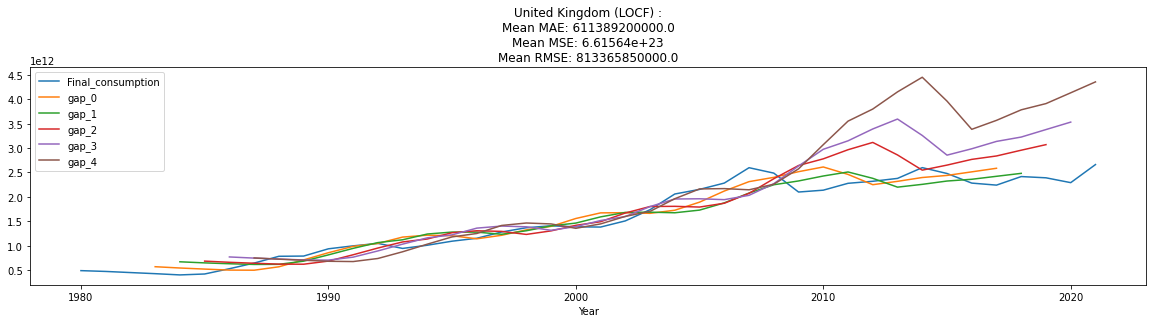

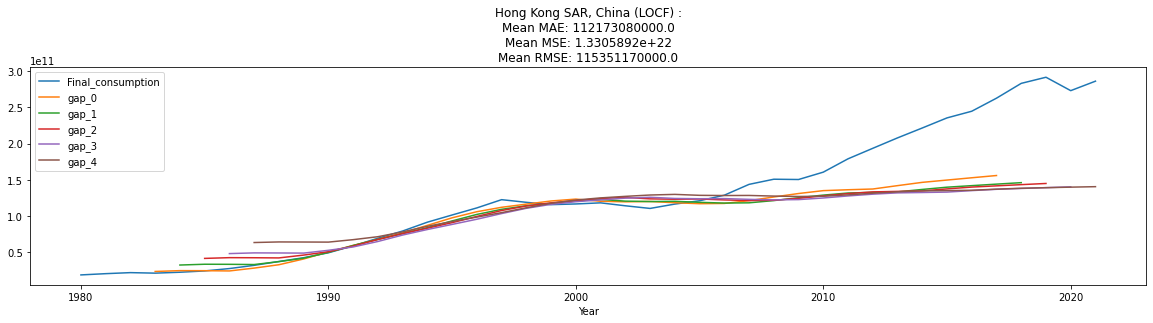

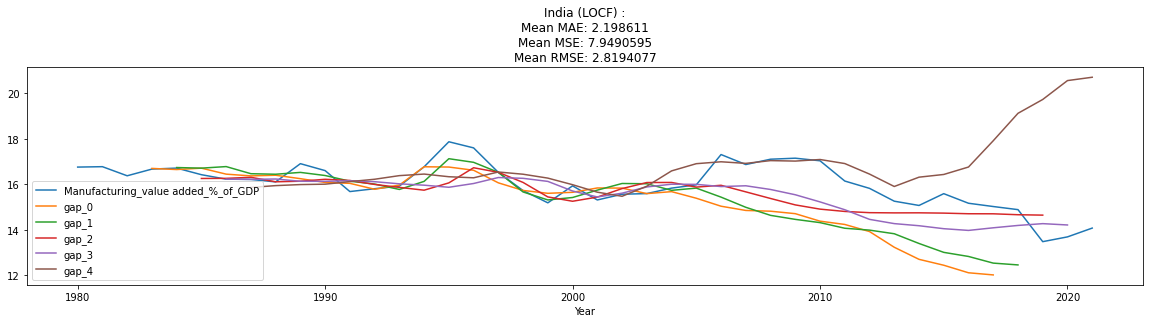

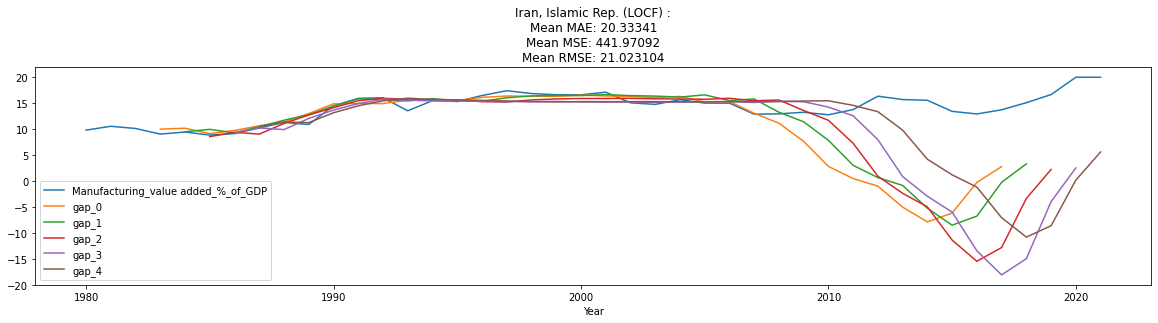

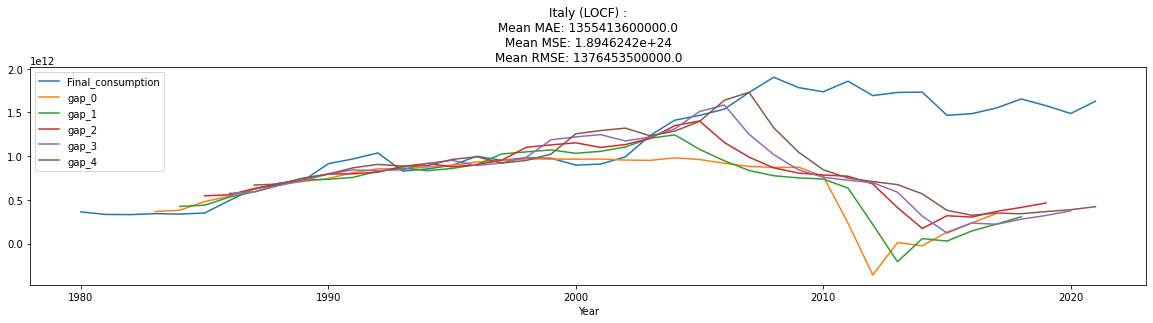

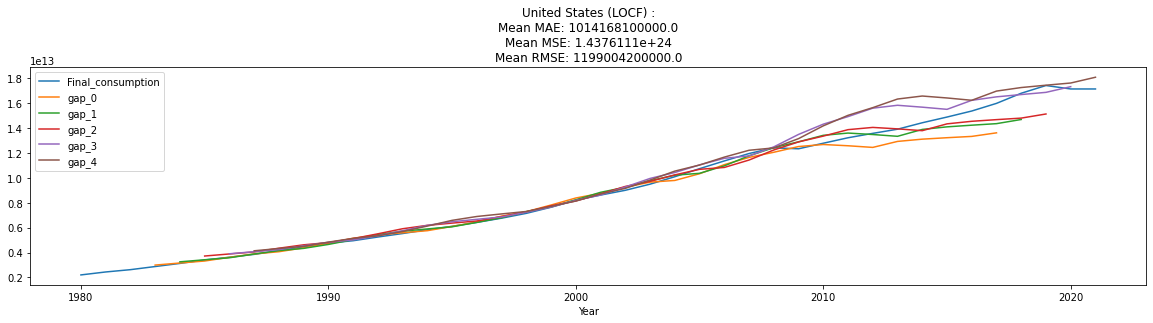

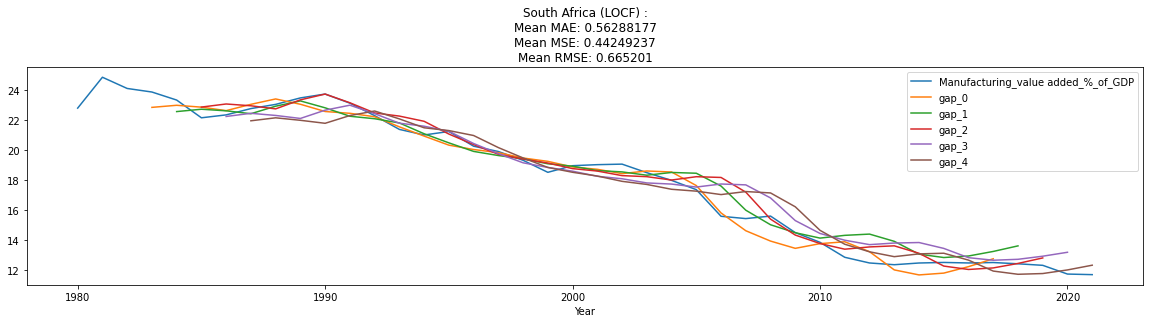

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_s, 2):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### NOCB

China NOCB :
Total Modelling Time:  17.77210021018982
MAE [2.3526802, 2.9749258, 3.618736, 4.3147235, 4.644487]  Mean MAE 3.5811102 
MSE [7.2832394, 10.14285, 14.3332815, 19.411505, 22.052078]  Mean MSE 14.644591 
RMSE [2.6987476, 3.1847842, 3.785932, 4.405849, 4.695964] Mean RMSE 3.8268251


CHN_NOCB
2022  31.976007
2023  31.981949
2024  31.976194
2025  31.994736
2026  32.118526



United Kingdom NOCB :
Total Modelling Time:  18.355660915374756
MAE [6.041202, 7.0738087, 5.780607, 7.8470225, 7.762342]  Mean MAE 6.9009967 
MSE [37.748367, 51.18661, 34.05702, 62.670094, 61.189255]  Mean MSE 49.370266 
RMSE [6.14397, 7.154482, 5.8358393, 7.9164443, 7.822356] Mean RMSE 7.0263977


GBR_NOCB
2022  2.675368
2023  1.566247
2024  2.876341
2025  0.634225
2026  0.689432



Hong Kong SAR, China NOCB :
Total Modelling Time:  18.406543731689453
MAE [82364790000.0, 101860680000.0, 117389435000.0, 131396575000.0, 135759460000.0]  Mean MAE 113754190000.0 
MSE [7.087846e+21, 1.0814943e+22, 1.4267776e+22, 1.761003e+22, 1.864906e+22]  Mean MSE 1.3685931e+22 
RMSE [84189350000.0, 103994920000.0, 119447800000.0, 132702790000.0, 136561566000.0] Mean RMSE 116986890000.0


HKG_NOCB
2022  1.602036e+11
2023  1.511952e+11
2024  1.464898e+11
2025  1.364617e+11
2026  1.402154e+11



India NOCB :
Total Modelling Time:  17.84081530570984
MAE [0.9999029, 1.0617881, 0.682508, 1.049148, 1.269638]  Mean MAE 1.0125968 
MSE [1.053276, 1.1699337, 0.5367217, 1.5358542, 2.581835]  Mean MSE 1.3755243 
RMSE [1.0262923, 1.0816348, 0.7326129, 1.2392958, 1.6068089] Mean RMSE 1.1728275


IND_NOCB
2022  13.518240
2023  13.761387
2024  14.498850
2025  13.555902
2026  16.863211



Iran, Islamic Rep. NOCB :
Cannot handle IRN, NOCB
Italy NOCB :
Total Modelling Time:  19.436947345733643
MAE [2.420883, 2.0231287, 1.8322253, 1.6986222, 1.6346856]  Mean MAE 1.9219091 
MSE [6.5829034, 4.837647, 3.8594205, 3.1850195, 2.8656912]  Mean MSE 4.2661357 
RMSE [2.565717, 2.199465, 1.9645408, 1.7846622, 1.6928352] Mean RMSE 2.0654626


ITA_NOCB
2022  16.881918
2023  16.645130
2024  16.590141
2025  16.593714
2026  16.645308



Russian Federation NOCB :
Total Modelling Time:  17.913559436798096
MAE [3.6031349, 3.5660527, 3.1818511, 2.4522526, 2.0586143]  Mean MAE 2.972381 
MSE [13.22173, 13.070973, 10.442683, 6.323522, 5.0145445]  Mean MSE 9.614691 
RMSE [3.6361697, 3.61538, 3.231514, 2.5146613, 2.239318] Mean RMSE 3.1007564


RUS_NOCB
2022  15.253265
2023  15.362532
2024  15.325262
2025  15.117061
2026  15.090319



United States NOCB :
Total Modelling Time:  18.689185857772827
MAE [4258.112, 1229.39, 1554.6888, 1759.8756, 1727.4928]  Mean MAE 2105.9119 
MSE [18718044.0, 1871427.0, 3086576.0, 4747493.0, 5035893.0]  Mean MSE 6691887.0 
RMSE [4326.4355, 1368.0011, 1756.8654, 2178.8743, 2244.0796] Mean RMSE 2586.8682


USA_NOCB
2022  60071.851562
2023  68495.054688
2024  70755.328125
2025  77277.203125
2026  80303.085938



Vietnam NOCB :
Total Modelling Time:  18.870546579360962
MAE [675.30804, 1123.5905, 1544.1862, 1811.5807, 1918.5103]  Mean MAE 1414.6353 
MSE [461331.38, 1276439.1, 2415147.8, 3319571.2, 3705605.0]  Mean MSE 2235619.0 
RMSE [679.2138, 1129.796, 1554.0746, 1821.9691, 1924.9948] Mean RMSE 1495.1986


VNM_NOCB
2022  2806.425537
2023  2329.718994
2024  1952.063232
2025  1778.527344
2026  1906.773804



South Africa NOCB :
Total Modelling Time:  18.895108699798584
MAE [0.93428105, 0.3573812, 0.30469117, 0.46948862, 0.6732847]  Mean MAE 0.5478254 
MSE [1.0517644, 0.24906318, 0.15484409, 0.36659205, 0.56989706]  Mean MSE 0.47843218 
RMSE [1.0255556, 0.4990623, 0.39350232, 0.60546845, 0.75491524] Mean RMSE 0.69168794


ZAF_NOCB
2022  11.519091
2023  12.743874
2024  12.608144
2025  12.777742
2026  12.760831

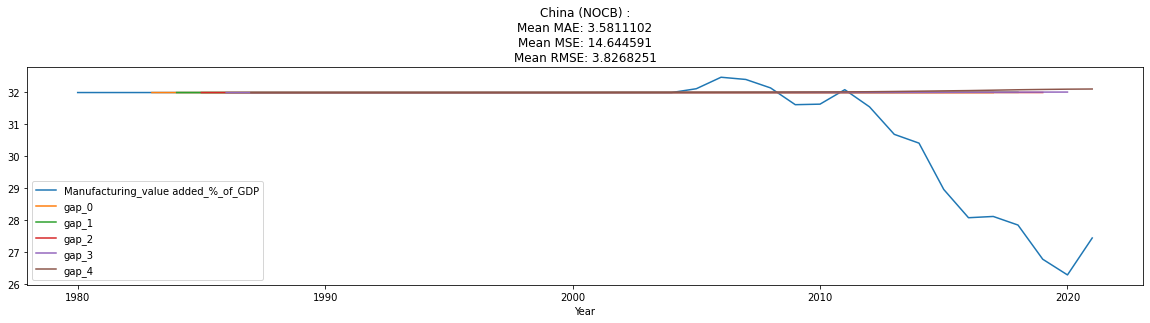

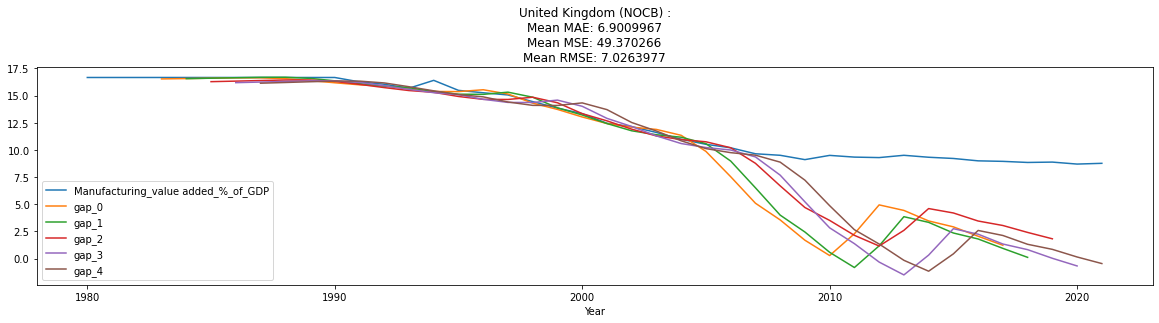

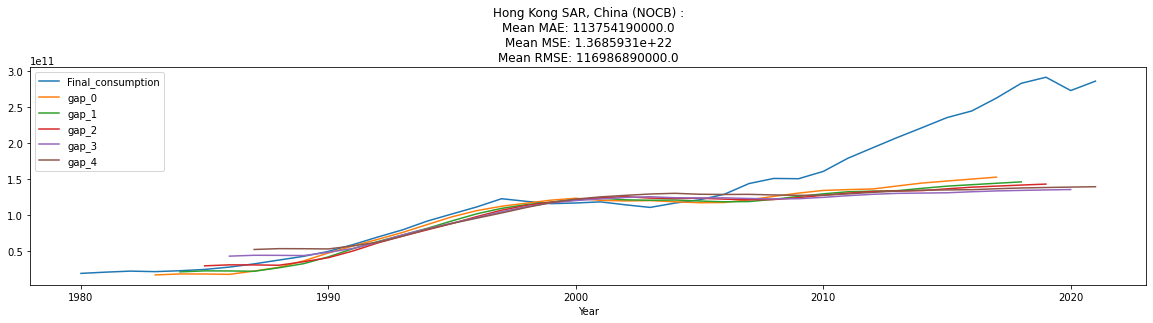

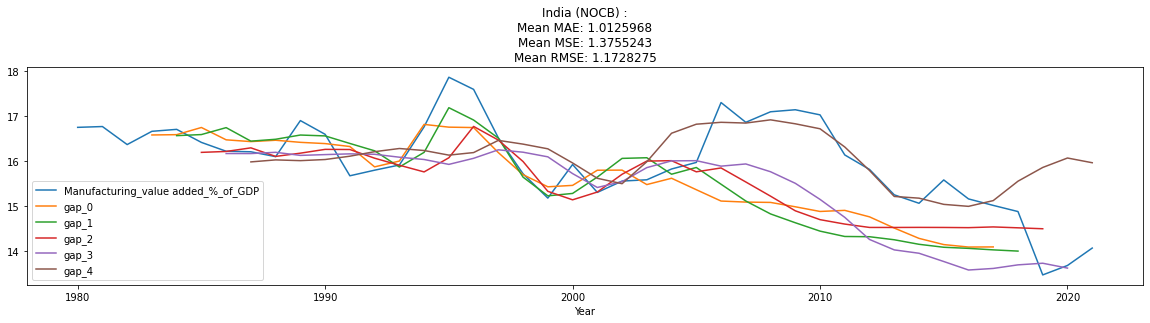

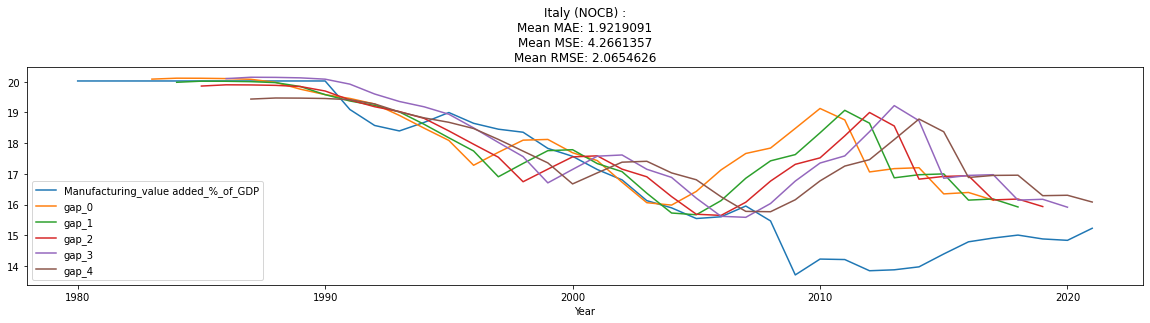

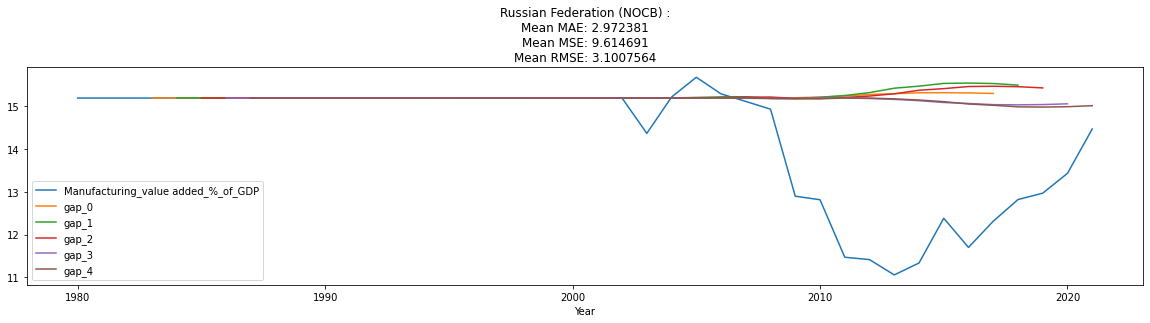

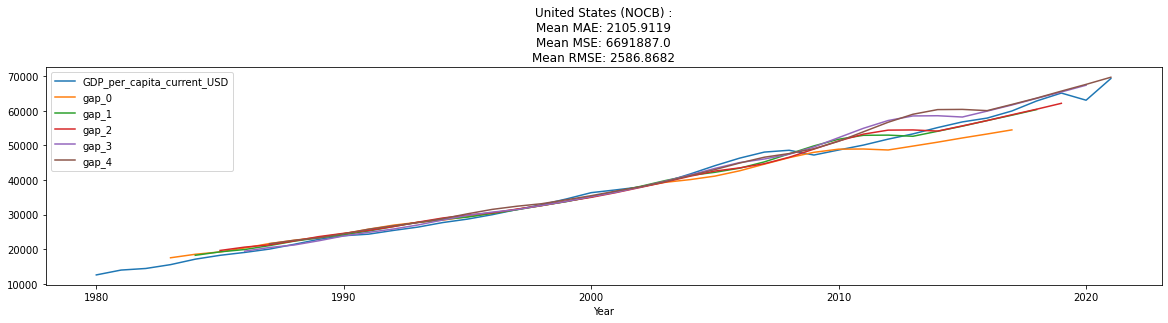

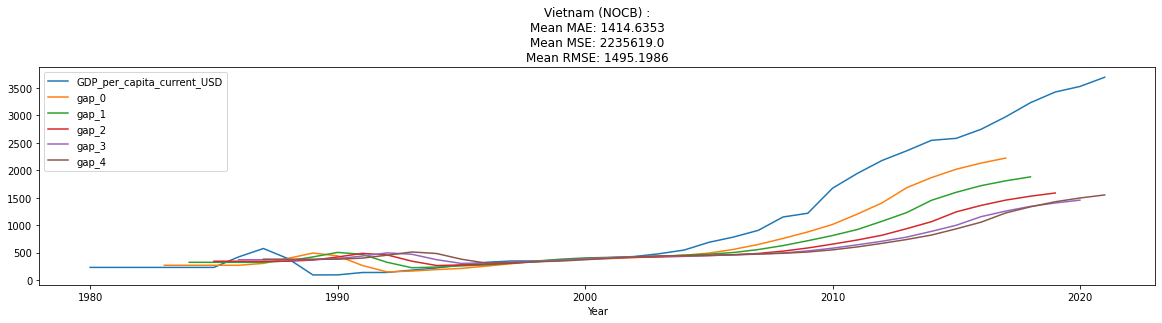

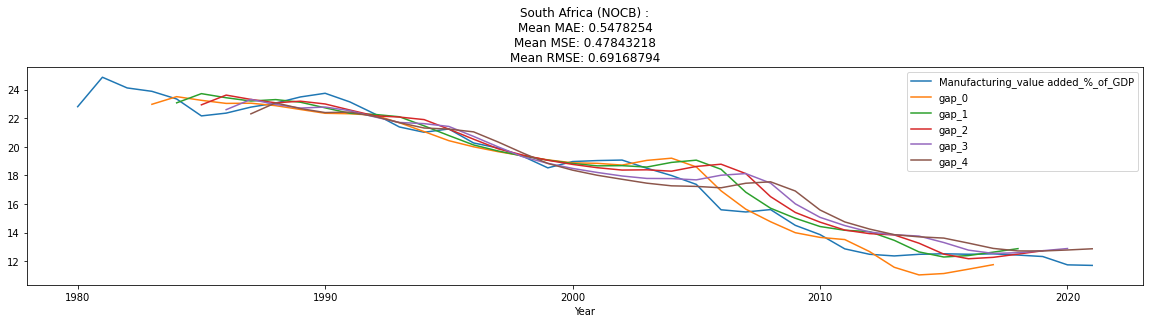

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_s, 3):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### Rolling Stats

China Rolling statistics :
Total Modelling Time:  19.27691078186035
MAE [1442090600000.0, 1731797600000.0, 2130844800000.0, 2416212700000.0, 2253287300000.0]  Mean MAE 1994846600000.0 
MSE [2.328481e+24, 3.27824e+24, 4.8939777e+24, 6.205276e+24, 5.2728634e+24]  Mean MSE 4.3957675e+24 
RMSE [1525936200000.0, 1810591100000.0, 2212233700000.0, 2491039000000.0, 2296271600000.0] Mean RMSE 2096608600000.0


CHN_Rolling statistics
2022            2.646211e+12
2023            2.738004e+12
2024            2.613531e+12
2025            2.752770e+12
2026            3.527226e+12



United Kingdom Rolling statistics :
Total Modelling Time:  18.45332670211792
MAE [711404160000.0, 699994800000.0, 603376250000.0, 529786370000.0, 442582170000.0]  Mean MAE 597428700000.0 
MSE [5.087272e+23, 4.911995e+23, 3.6422466e+23, 2.8073134e+23, 1.962036e+23]  Mean MSE 3.6821722e+23 
RMSE [713251160000.0, 700856300000.0, 603510300000.0, 529840870000.0, 442948750000.0] Mean RMSE 606809000000.0


GBR_Rolling statistics
2022            1.498013e+12
2023            1.541441e+12
2024            1.666583e+12
2025            1.754520e+12
2026            1.858973e+12



Hong Kong SAR, China Rolling statistics :
Total Modelling Time:  18.704569816589355
MAE [43573883000.0, 55734403000.0, 68342100000.0, 79102435000.0, 88005010000.0]  Mean MAE 66951565000.0 
MSE [2.0693207e+21, 3.3359663e+21, 4.958151e+21, 6.5378486e+21, 7.9991833e+21]  Mean MSE 4.980094e+21 
RMSE [45489787000.0, 57757823000.0, 70414140000.0, 80856965000.0, 89438150000.0] Mean RMSE 70569780000.0


HKG_Rolling statistics
2022            1.499405e+11
2023            1.440051e+11
2024            1.385323e+11
2025            1.377732e+11
2026            1.380900e+11



India Rolling statistics :
Total Modelling Time:  18.54981565475464
MAE [2.0753455, 3.419759, 2.8986423, 1.7012815, 0.5780123]  Mean MAE 2.1346083 
MSE [4.3242874, 11.798144, 8.429621, 2.9431713, 0.5197273]  Mean MSE 5.6029906 
RMSE [2.079492, 3.4348426, 2.9033809, 1.7155674, 0.72092116] Mean RMSE 2.3670638


IND_Rolling statistics
2022               12.969029
2023               11.201075
2024               12.187126
2025               13.564697
2026               16.532761



Iran, Islamic Rep. Rolling statistics :
Total Modelling Time:  18.477416038513184
MAE [6.1974654, 6.162609, 5.365479, 5.043832, 4.269243]  Mean MAE 5.4077253 
MSE [40.73058, 40.68299, 31.503845, 29.731476, 23.182287]  Mean MSE 33.166233 
RMSE [6.3820515, 6.378322, 5.6128287, 5.4526577, 4.814799] Mean RMSE 5.759013


IRN_Rolling statistics
2022               11.074635
2023               11.763091
2024               12.978042
2025               13.766264
2026               14.749954



Italy Rolling statistics :
Total Modelling Time:  17.77808976173401
MAE [819117400000.0, 859588700000.0, 862604170000.0, 854804300000.0, 862879740000.0]  Mean MAE 851799000000.0 
MSE [6.738919e+23, 7.415248e+23, 7.467279e+23, 7.342622e+23, 7.497115e+23]  Mean MSE 7.2922364e+23 
RMSE [820909200000.0, 861118330000.0, 864134200000.0, 856891000000.0, 865858800000.0] Mean RMSE 853945940000.0


ITA_Rolling statistics
2022            8.170270e+11
2023            7.856538e+11
2024            7.810333e+11
2025            7.794543e+11
2026            7.728429e+11



Russian Federation Rolling statistics :
Cannot handle RUS, Rolling statistics
United States Rolling statistics :
Total Modelling Time:  19.049065113067627
MAE [1772529600000.0, 739393900000.0, 873917840000.0, 509221000000.0, 163865870000.0]  Mean MAE 811785700000.0 
MSE [3.3125576e+24, 6.448633e+23, 8.9437655e+23, 3.6471342e+23, 4.203135e+22]  Mean MSE 1.0517084e+24 
RMSE [1820043200000.0, 803033800000.0, 945714800000.0, 603915100000.0, 205015500000.0] Mean RMSE 1025528370000.0


USA_Rolling statistics
2022            1.200130e+13
2023            1.418378e+13
2024            1.450358e+13
2025            1.557648e+13
2026            1.676950e+13



Vietnam Rolling statistics :
Cannot handle VNM, Rolling statistics
South Africa Rolling statistics :
Total Modelling Time:  18.553138971328735
MAE [0.6456768, 0.21178134, 0.5872202, 0.4878335, 0.3728757]  Mean MAE 0.4610775 
MSE [0.4747413, 0.068525605, 0.3649017, 0.2962165, 0.17256635]  Mean MSE 0.2753903 
RMSE [0.68901473, 0.26177394, 0.60407096, 0.54425776, 0.41541106] Mean RMSE 0.5247764


ZAF_Rolling statistics
2022               12.801798
2023               13.590244
2024               13.764532
2025               12.306685
2026               12.242110

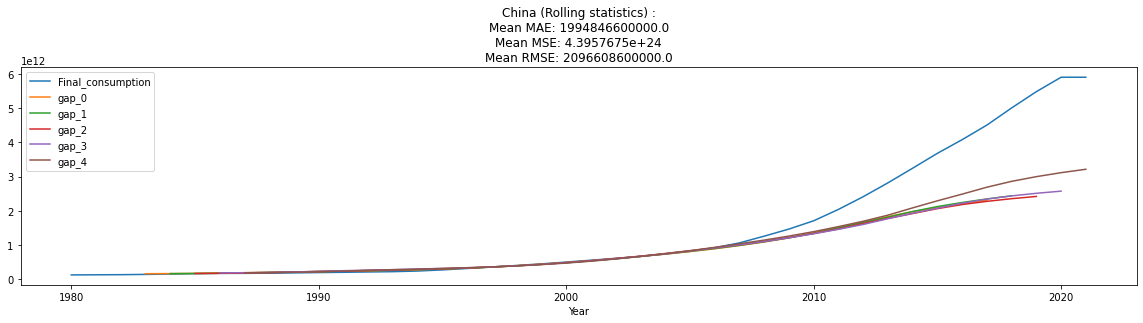

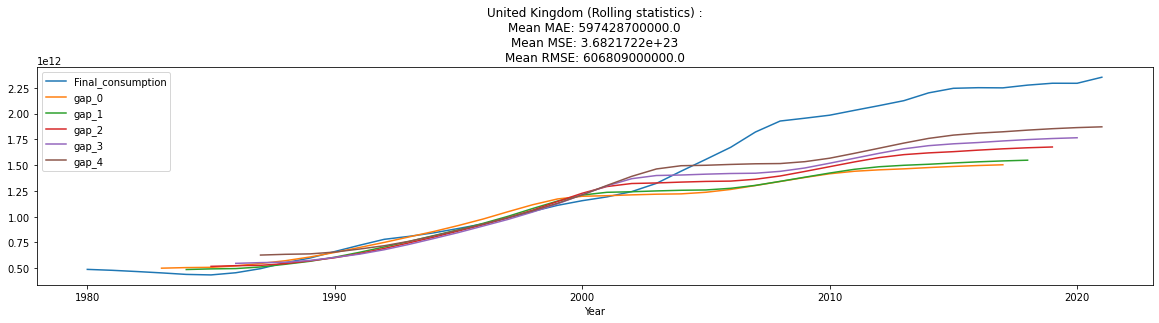

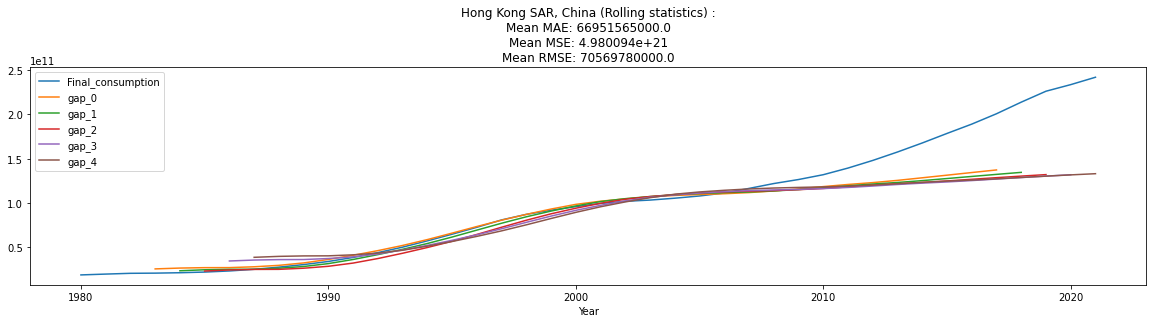

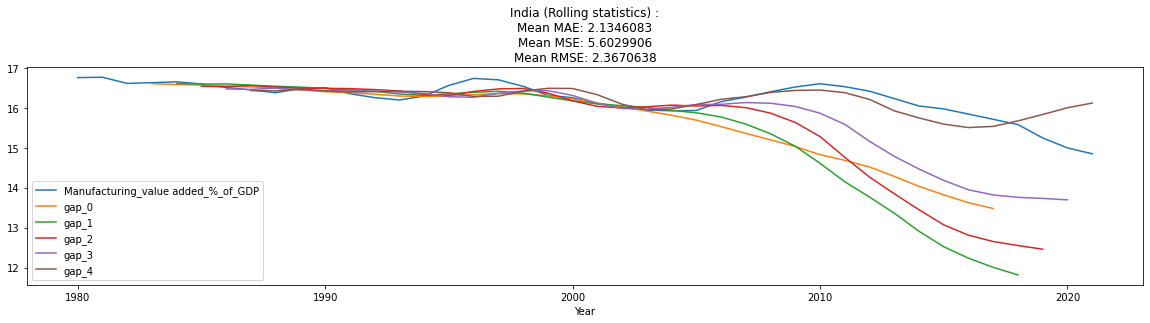

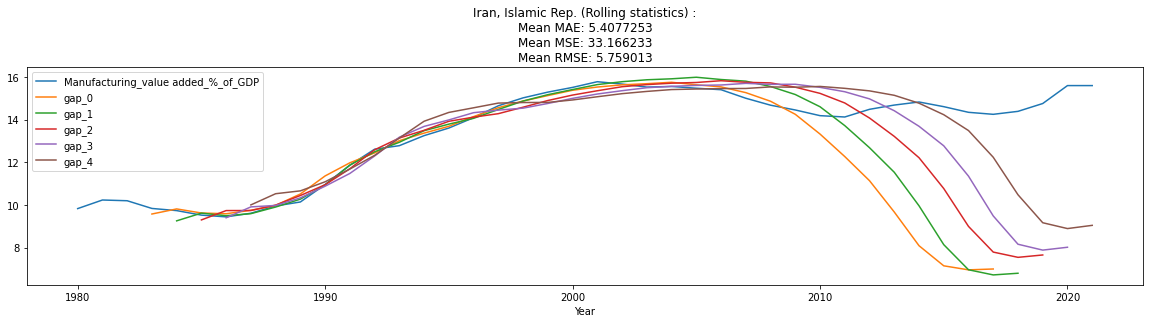

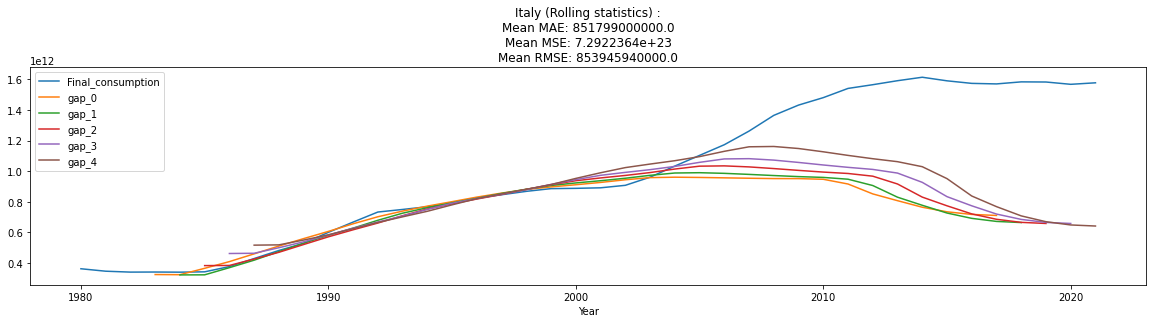

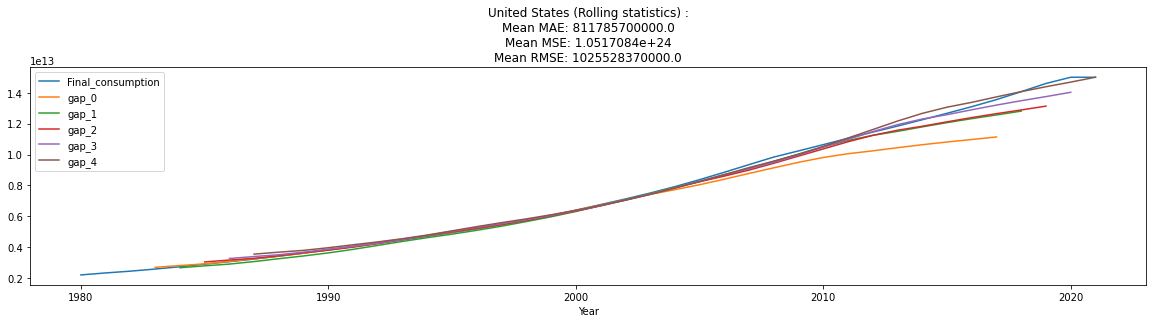

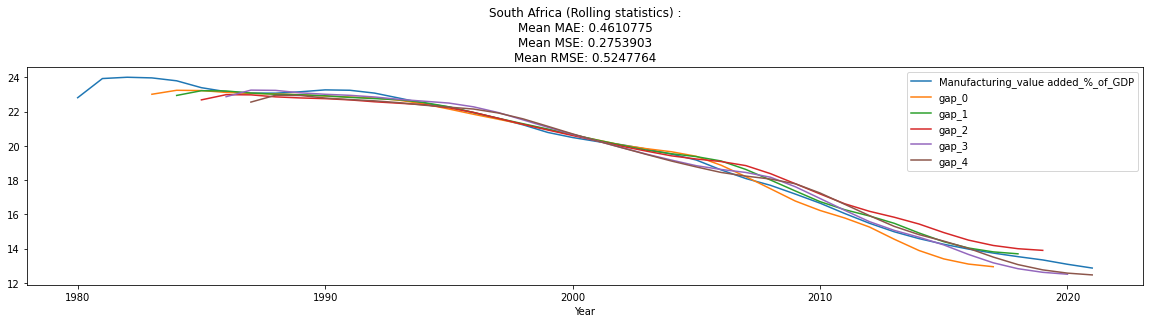

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_s, 4):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### Interpolate

China Interpolate :
Total Modelling Time:  18.53184413909912
MAE [2539646600000.0, 2964534300000.0, 2833683000000.0, 2330079300000.0, 1404906400000.0]  Mean MAE 2414569800000.0 
MSE [6.7610793e+24, 9.2313105e+24, 8.4467434e+24, 5.7000745e+24, 2.0525947e+24]  Mean MSE 6.4383604e+24 
RMSE [2600207600000.0, 3038307200000.0, 2906328100000.0, 2387482800000.0, 1432688000000.0] Mean RMSE 2537392400000.0


CHN_Interpolate
2022     3.724563e+12
2023     3.749138e+12
2024     4.564514e+12
2025     5.798925e+12
2026     7.620513e+12



United Kingdom Interpolate :
Total Modelling Time:  19.995850563049316
MAE [193753460000.0, 166476040000.0, 373612180000.0, 701667000000.0, 1224395600000.0]  Mean MAE 531980880000.0 
MSE [4.7459595e+22, 3.917557e+22, 1.7785686e+23, 5.4836377e+23, 1.5421977e+24]  Mean MSE 4.7101062e+23 
RMSE [217852230000.0, 197928190000.0, 421730780000.0, 740515900000.0, 1241852500000.0] Mean RMSE 686302170000.0


GBR_Interpolate
2022     2.289699e+12
2023     2.354874e+12
2024     2.822181e+12
2025     3.136986e+12
2026     3.719762e+12



Hong Kong SAR, China Interpolate :
Total Modelling Time:  17.781097173690796
MAE [84471415000.0, 103101235000.0, 121851570000.0, 133850096000.0, 139549210000.0]  Mean MAE 116564700000.0 
MSE [7.45554e+21, 1.1078701e+22, 1.5374308e+22, 1.827627e+22, 1.9710123e+22]  Mean MSE 1.4378989e+22 
RMSE [86345466000.0, 105255410000.0, 123993180000.0, 135189760000.0, 140392740000.0] Mean RMSE 119912420000.0


HKG_Interpolate
2022     1.566859e+11
2023     1.492854e+11
2024     1.394503e+11
2025     1.325835e+11
2026     1.340635e+11



India Interpolate :
Total Modelling Time:  18.30518341064453
MAE [2.5124443, 1.8509593, 0.64387226, 0.9002118, 4.8829756]  Mean MAE 2.1580925 
MSE [6.582875, 3.5604017, 0.4668937, 0.90049857, 27.589722]  Mean MSE 7.8200774 
RMSE [2.5657113, 1.8869027, 0.6832962, 0.94894606, 5.252592] Mean RMSE 2.7964401


IND_Interpolate
2022        10.970221
2023        12.035370
2024        14.171747
2025        14.699070
2026        23.111698



Iran, Islamic Rep. Interpolate :
Total Modelling Time:  19.072605848312378
MAE [19.802614, 19.712875, 24.679693, 31.602346, 26.701635]  Mean MAE 24.499834 
MSE [406.62106, 396.9951, 623.66406, 1034.8701, 740.21875]  Mean MSE 640.4739 
RMSE [20.164846, 19.924736, 24.973267, 32.169395, 27.20696] Mean RMSE 25.307585


IRN_Interpolate
2022        14.419292
2023        15.086402
2024        15.354509
2025        15.188242
2026        15.218368



Italy Interpolate :
Total Modelling Time:  18.227710008621216
MAE [1920765900000.0, 1766297400000.0, 1477633800000.0, 1286953900000.0, 1266316600000.0]  Mean MAE 1543593700000.0 
MSE [3.8450267e+24, 3.2100145e+24, 2.2188708e+24, 1.6629567e+24, 1.6083186e+24]  Mean MSE 2.5090374e+24 
RMSE [1960874000000.0, 1791651300000.0, 1489587400000.0, 1289556700000.0, 1268195000000.0] Mean RMSE 1583994100000.0


ITA_Interpolate
2022     5.386017e+11
2023     5.300427e+11
2024     5.405962e+11
2025     5.491091e+11
2026     5.557765e+11



Russian Federation Interpolate :
Cannot handle RUS, Interpolate
United States Interpolate :
Total Modelling Time:  17.590415000915527
MAE [1538481300000.0, 1764742800000.0, 1167328100000.0, 455124800000.0, 946958700000.0]  Mean MAE 1174527100000.0 
MSE [2.6099978e+24, 3.5112786e+24, 1.8011666e+24, 2.5891682e+23, 1.0091807e+24]  Mean MSE 1.838108e+24 
RMSE [1615548800000.0, 1873840600000.0, 1342075400000.0, 508838700000.0, 1004579850000.0] Mean RMSE 1355768400000.0


USA_Interpolate
2022     1.508974e+13
2023     1.534187e+13
2024     1.692126e+13
2025     1.904818e+13
2026     2.081327e+13



Vietnam Interpolate :
Cannot handle VNM, Interpolate
South Africa Interpolate :
Total Modelling Time:  17.79399609565735
MAE [0.81477624, 0.43403658, 0.9544851, 0.42597088, 1.1206182]  Mean MAE 0.7499774 
MSE [0.85440737, 0.28746113, 1.0379206, 0.3348279, 1.6561912]  Mean MSE 0.83416164 
RMSE [0.92434156, 0.53615403, 1.0187839, 0.57864314, 1.2869309] Mean RMSE 0.9133245


ZAF_Interpolate
2022        13.855646
2023        14.098661
2024        14.470801
2025        13.693786
2026        12.674891

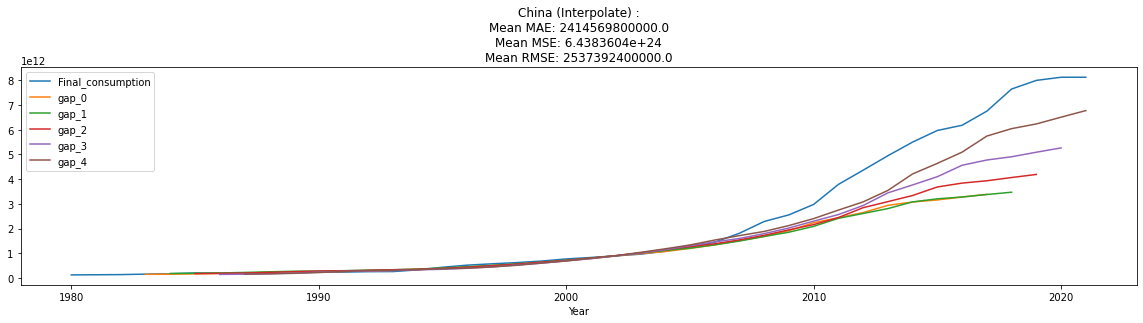

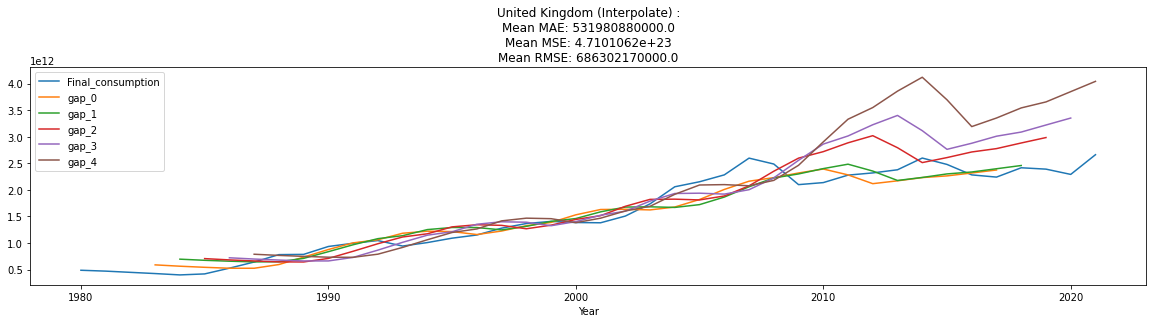

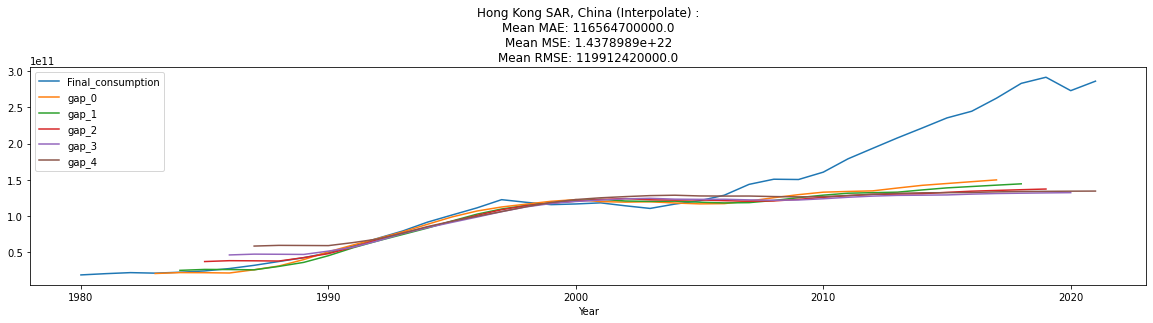

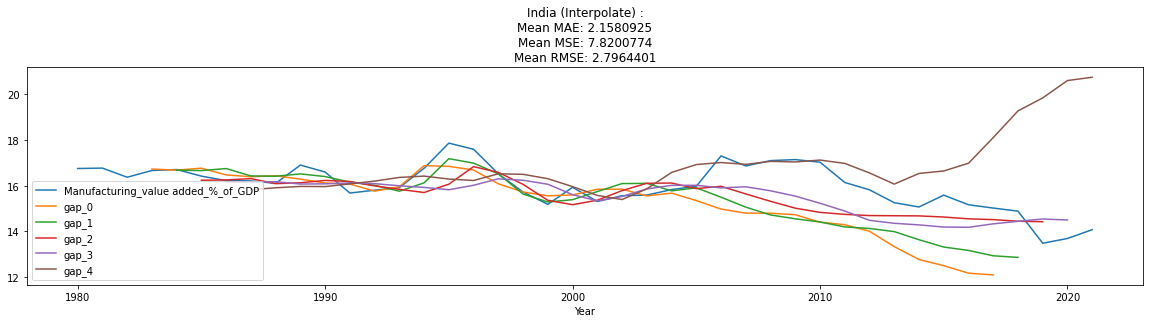

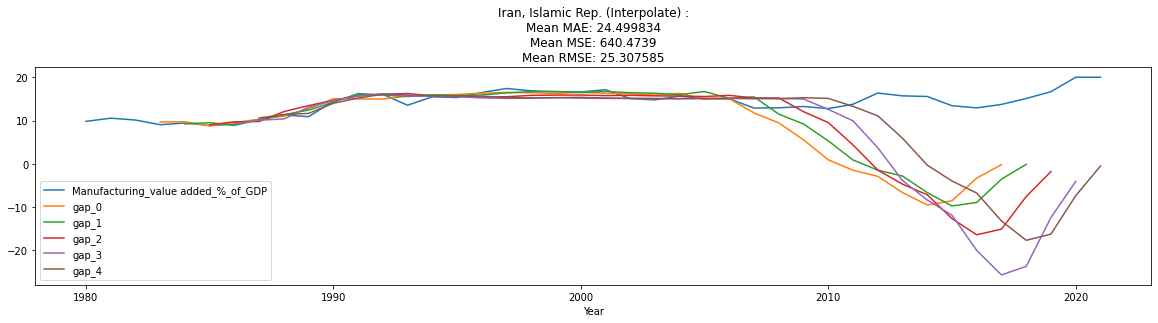

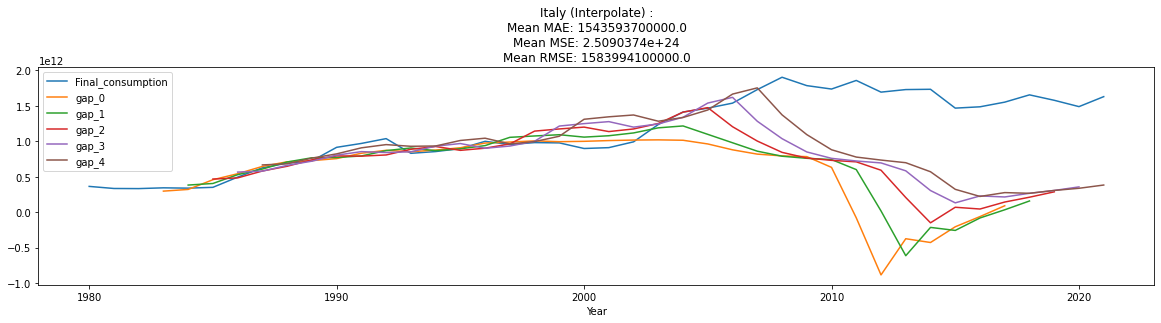

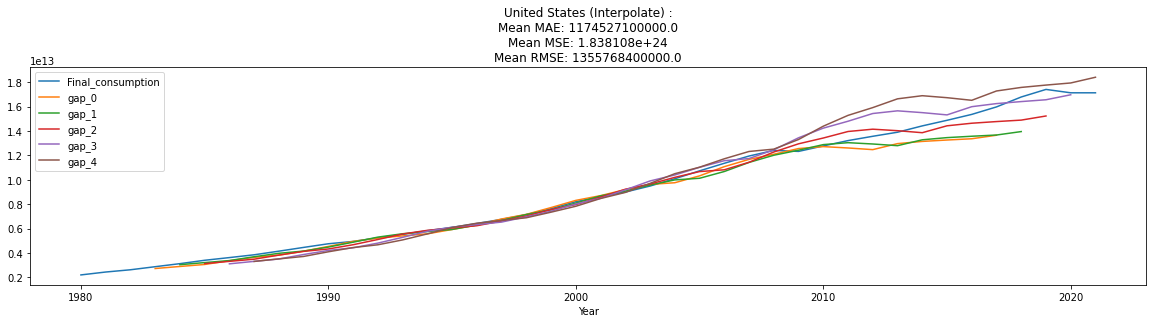

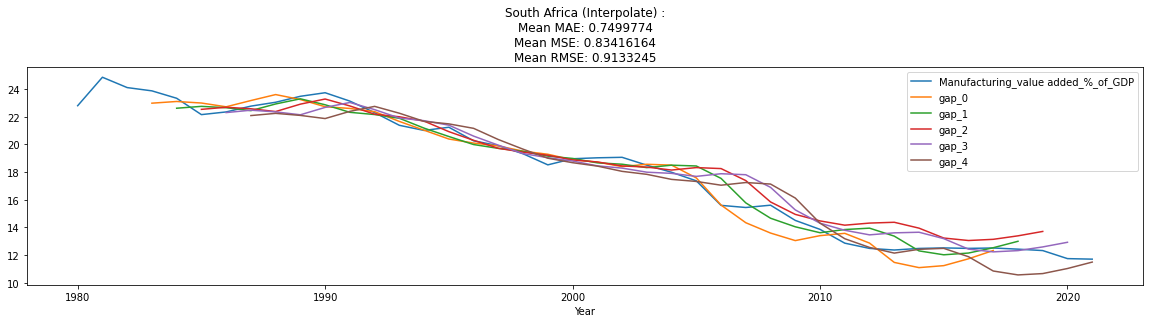

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_s, 5):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### Summary

In [ ]:
pd.DataFrame({
    'country': c,
    'method': m,
    'ME': a,
    'MSE': s,
    'RMSE': r
})

country              method            ME           MSE          RMSE
0      CHN                Mean  1.489548e+00  2.673898e+00  1.635206e+00
1      GBR                Mean  2.960128e+00  1.099935e+01  3.316526e+00
2      HKG                Mean  5.132959e-01  3.546938e-01  5.955618e-01
3      IND                Mean  8.513259e-01  1.262859e+00  1.123770e+00
4      IRN                Mean  4.942201e+00  3.551351e+01  5.959321e+00
5      ITA                Mean  4.850075e+00  2.439365e+01  4.938993e+00
6      RUS                Mean  1.053361e+00  1.561077e+00  1.249431e+00
7      USA                Mean  6.969419e-01  7.183378e-01  8.475481e-01
8      VNM                Mean  2.746111e-01  9.440856e-02  3.072598e-01
9      ZAF                Mean  4.528820e+00  2.080903e+01  4.561692e+00
10     CHN              Median  2.526469e+00  7.448029e+00  2.729108e+00
11     GBR              Median  2.581642e+00  9.257538e+00  3.042620e+00
12     HKG              Median  1.351884e+00  2.086513e+00  1.444477e+00
13     IND              Median  9.039291e-01  1.431797e+00  1.196577e+00
14     IRN              Median  5.358790e+00  4.753284e+01  6.894407e+00
15     ITA              Median  5.158425e+00  2.774417e+01  5.267273e+00
16     RUS              Median  8.242411e-01  1.035682e+00  1.017685e+00
17     USA              Median  7.557978e-01  8.984463e-01  9.478641e-01
18     VNM              Median  2.778536e-01  9.662366e-02  3.108435e-01
19     ZAF              Median  4.045945e+00  1.683018e+01  4.102460e+00
20     CHN                LOCF  2.932015e+12  9.228067e+24  3.037773e+12
21     GBR                LOCF  6.113892e+11  6.615640e+23  8.133659e+11
22     HKG                LOCF  1.121731e+11  1.330589e+22  1.153512e+11
23     IND                LOCF  2.198611e+00  7.949059e+00  2.819408e+00
24     IRN                LOCF  2.033341e+01  4.419709e+02  2.102310e+01
25     ITA                LOCF  1.355414e+12  1.894624e+24  1.376454e+12
26     USA                LOCF  1.014168e+12  1.437611e+24  1.199004e+12
27     ZAF                LOCF  5.628818e-01  4.424924e-01  6.652010e-01
28     CHN                NOCB  3.581110e+00  1.464459e+01  3.826825e+00
29     GBR                NOCB  6.900997e+00  4.937027e+01  7.026398e+00
30     HKG                NOCB  1.137542e+11  1.368593e+22  1.169869e+11
31     IND                NOCB  1.012597e+00  1.375524e+00  1.172827e+00
32     ITA                NOCB  1.921909e+00  4.266136e+00  2.065463e+00
33     RUS                NOCB  2.972381e+00  9.614691e+00  3.100756e+00
34     USA                NOCB  2.105912e+03  6.691887e+06  2.586868e+03
35     VNM                NOCB  1.414635e+03  2.235619e+06  1.495199e+03
36     ZAF                NOCB  5.478254e-01  4.784322e-01  6.916879e-01
37     CHN  Rolling statistics  1.994847e+12  4.395767e+24  2.096609e+12
38     GBR  Rolling statistics  5.974287e+11  3.682172e+23  6.068090e+11
39     HKG  Rolling statistics  6.695157e+10  4.980094e+21  7.056978e+10
40     IND  Rolling statistics  2.134608e+00  5.602991e+00  2.367064e+00
41     IRN  Rolling statistics  5.407725e+00  3.316623e+01  5.759013e+00
42     ITA  Rolling statistics  8.517990e+11  7.292236e+23  8.539459e+11
43     USA  Rolling statistics  8.117857e+11  1.051708e+24  1.025528e+12
44     ZAF  Rolling statistics  4.610775e-01  2.753903e-01  5.247764e-01
45     CHN         Interpolate  2.414570e+12  6.438360e+24  2.537392e+12
46     GBR         Interpolate  5.319809e+11  4.710106e+23  6.863022e+11
47     HKG         Interpolate  1.165647e+11  1.437899e+22  1.199124e+11
48     IND         Interpolate  2.158092e+00  7.820077e+00  2.796440e+00
49     IRN         Interpolate  2.449983e+01  6.404739e+02  2.530758e+01
50     ITA         Interpolate  1.543594e+12  2.509037e+24  1.583994e+12
51     USA         Interpolate  1.174527e+12  1.838108e+24  1.355768e+12
52     ZAF         Interpolate  7.499774e-01  8.341616e-01  9.133245e-01